<a href="https://colab.research.google.com/github/jauharmz/Orca_Files/blob/main/ORCA_Test_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00 Importing Libraries

In [1]:
%%capture
!pip install -q condacolab
import condacolab

# Install a Miniforge version that ships with Python 3.12 to match Colab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/24.9.0-0/Miniforge3-24.9.0-0-Linux-x86_64.sh")

In [1]:
%%capture
import condacolab
condacolab.check()

# Install RDKit into the existing base environment
!mamba install -c conda-forge rdkit openbabel -y
!pip install py3Dmol

In [2]:
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import pybel
from tempfile import NamedTemporaryFile
from pathlib import Path
from tqdm import tqdm
from IPython.display import HTML, display

In [3]:
from huggingface_hub import login, snapshot_download

API_KEY = ''

login(API_KEY)

## 01 Define Parsing Functions

In [4]:
# @title
# ---------- Helper Function for Scientific Notation ----------
def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None

# ---------- SMILES Generation Function ----------
def coords_to_smiles(mol_coords):
    """
    Convert (symbol, x, y, z) coordinates into a SMILES string using OpenBabel (pybel).
    """
    if not mol_coords:
        return None

    # Write coords to a temporary XYZ file
    with NamedTemporaryFile("w", suffix=".xyz", delete=False) as tmp:
        tmp.write(f"{len(mol_coords)}\n")
        tmp.write("Generated from dataframe\n")
        for atom, x, y, z in mol_coords:
            tmp.write(f"{atom} {x:.6f} {y:.6f} {z:.6f}\n")
        tmp_path = tmp.name

    try:
        # Read with pybel
        mol = next(pybel.readfile("xyz", tmp_path))

        # Convert to SMILES
        smi = mol.write("smi").strip()
        return smi.split()[0]
    except Exception as e:
        return None
    finally:
        # Clean up temporary file
        try:
            os.unlink(tmp_path)
        except:
            pass

# ---------- Geometry Info ----------
def parse_geometry_info(text):
    """Parse geometry file name, charge, and multiplicity from ORCA output."""
    geometry_info = {"filename": None, "charge": None, "multiplicity": None}

    # Try to find geometry file from "The coordinates will be read from file" line
    coords_match = re.search(
        r"The coordinates will be read from file:\s*(\S+)",
        text
    )
    if coords_match:
        geometry_file = coords_match.group(1)
        # Strip extension to get base name (e.g., "phs0" from "phs0.xyz")
        geometry_info["filename"] = os.path.splitext(geometry_file)[0]

    # Try to find geometry file, charge, and multiplicity from input section
    input_section_match = re.search(
        r"={10,}\s*(INPUT FILE|INPUT)\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S | re.I
    )
    if input_section_match:
        input_section = input_section_match.group(2)
        # Look for * xyzfile charge multiplicity filename
        xyzfile_match = re.search(
            r"\*\s*xyzfile\s+(\d+)\s+(\d+)\s+(\S+)",
            input_section, flags=re.I
        )
        if xyzfile_match:
            geometry_info["charge"] = int(xyzfile_match.group(1))
            geometry_info["multiplicity"] = int(xyzfile_match.group(2))
            geometry_file = xyzfile_match.group(3)
            # Strip extension to get base name
            geometry_info["filename"] = os.path.splitext(geometry_file)[0]

    # If filename is still None, fallback to using the input filename without extension
    if geometry_info["filename"] is None:
        return None

    return geometry_info

# ---------- Cartesian ----------
def parse_last_cartesian(text):
    """Parse the last Cartesian coordinates block from ORCA output."""
    blocks = re.findall(
        r"CARTESIAN COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 4:
            continue
        atom = parts[0]
        x, y, z = map(parse_float, parts[1:4])
        if None in (x, y, z):
            continue
        coords.append((atom, x, y, z))
    return coords

# ---------- Internal ----------
def parse_last_internal(text):
    """Parse the last internal coordinates block from ORCA output."""
    blocks = re.findall(
        r"INTERNAL COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 7:
            continue
        atom = parts[0]
        bond, angle, dihedral = map(parse_float, parts[4:7])
        if None in (bond, angle, dihedral):
            continue
        coords.append((atom, bond, angle, dihedral))
    return coords

# ---------- Orbitals ----------
def parse_last_orbitals(text, as_df=False):
    """Parse the last orbital energies block from ORCA output.
    Handles both closed-shell and open-shell (spin-polarized) cases.
    """
    # --- Case 1: Open-shell (spin up / spin down blocks) ---
    spin_blocks = re.findall(
        r"SPIN UP ORBITALS\n.*?\n(.*?)(?=\n\s*SPIN DOWN ORBITALS|\Z)",
        text, flags=re.S
    )
    spin_down_blocks = re.findall(
        r"SPIN DOWN ORBITALS\n.*?\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )

    if spin_blocks and spin_down_blocks:
        spins = [("up", spin_blocks[-1]), ("down", spin_down_blocks[-1])]
    else:
        # --- Case 2: Closed-shell (single ORBITAL ENERGIES block) ---
        blocks = re.findall(
            r"ORBITAL ENERGIES\n-+\n\s*NO.*?\n(.*?)(?:\n\n|\Z)",
            text, flags=re.S
        )
        if not blocks:
            return None
        spins = [("na", blocks[-1])]  # "na" = not applicable (closed shell)

    orbitals = []
    for spin, block in spins:
        lines = block.strip().splitlines()
        for line in lines:
            parts = line.split()
            if not parts or not parts[0].isdigit() or len(parts) < 4:
                continue

            occ = parse_float(parts[1])
            energy_h = parse_float(parts[2])
            energy_ev = parse_float(parts[3])

            if None in (occ, energy_h, energy_ev):
                continue

            # Filter out fake test data - ORCA only produces OCC values of 0.0, 1.0, or 2.0
            if occ not in [0.0, 1.0, 2.0]:
                continue

            # Additional check for obvious fake data patterns
            if energy_h == occ + 1.0 and energy_ev == occ + 2.0:
                continue

            orbitals.append({
                "OCC": occ,
                "Eh": energy_h,
                "eV": energy_ev,
                "spin": spin
            })

    if not orbitals:
        return None

    # Separate occupied and virtual orbitals
    occupied = [orb for orb in orbitals if orb["OCC"] > 0.0]
    virtual = [orb for orb in orbitals if orb["OCC"] == 0.0]

    # Sort occupied orbitals by energy (descending - highest energy first)
    # HOMO is the highest energy occupied orbital
    occupied.sort(key=lambda x: x["Eh"], reverse=True)

    # Sort virtual orbitals by energy (ascending - lowest energy first)
    # LUMO is the lowest energy virtual orbital
    virtual.sort(key=lambda x: x["Eh"])

    # Assign levels for occupied orbitals
    for i, orb in enumerate(occupied):
        orb["lvl"] = i  # HOMO = 0, HOMO-1 = 1, HOMO-2 = 2, etc.

    # Assign levels for virtual orbitals
    for i, orb in enumerate(virtual):
        orb["lvl"] = i  # LUMO = 0, LUMO+1 = 1, LUMO+2 = 2, etc.

    # Combine back into original order (by energy)
    all_orbitals = occupied + virtual
    all_orbitals.sort(key=lambda x: x["Eh"])

    if as_df:
        return pd.DataFrame(all_orbitals)

    return all_orbitals

# ---------- Vibrations ----------
def parse_last_vibrations(text):
    blocks = re.findall(
        r"VIBRATIONAL FREQUENCIES\n-+\n.*?\n\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not blocks:
        return None

    last_block = blocks[-1].strip().splitlines()
    vib_data = []
    for line in last_block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])

        # check imaginary
        img = 1 if freq < 0 else 0

        vib_data.append({
            "freq_cm-1": freq,
            "img": img
        })

    return vib_data

# ---------- IR Spectrum ----------
def parse_ir_spectrum(text):
    match = re.search(
        r"-{5,}\nIR SPECTRUM\n-+\n.*?\n-+\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None

    block = match.group(1).strip().splitlines()
    ir_data = []
    for line in block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue

        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        eps = float(parts[2])
        intensity = float(parts[3])
        t2 = float(parts[4])

        ir_data.append({
            "freq_cm-1": freq,
            "eps": eps,
            "intensity_km/mol": intensity,
            "t2": t2
        })

    return ir_data

# ---------- Raman Spectrum ----------
def parse_raman_spectrum(text, as_df=True):
    match = re.search(
        r"RAMAN SPECTRUM\s*-+\s*Mode.*?-+\s*(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None

    block = match.group(1).strip().splitlines()
    raman_data = []
    for line in block:
        parts = line.split()
        if len(parts) < 4:
            continue

        freq = float(parts[1])
        activity = float(parts[2])
        depol = float(parts[3])

        raman_data.append({
            "freq_cm-1": freq,
            "activity": activity,
            "depolarization": depol
        })

    if as_df:
        return pd.DataFrame(raman_data)
    return raman_data

# ---------- Gibbs Energy ----------
def parse_gibbs_energy(text):
    match = re.search(
        r"Final Gibbs free energy\s+\.{3,}\s+(-?\d+\.\d+)\s+Eh",
        text
    )
    if match:
        return float(match.group(1))
    return None

# ---------- Single Point Energy ----------
def parse_single_point_energy(text):
    matches = re.findall(r"FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)", text)
    if matches:
        return float(matches[-1])  # last match = optimized
    return None

# ---------- TDDFT States ----------
def parse_tddft_states(text, orbitals=None):
    states = []
    state_block_pattern = re.compile(
        r"STATE\s+(\d+):\s+E=\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+au\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+eV\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+cm\*{1,2}-1([\s\S]+?)(?=STATE|\Z)"
    )
    transition_pattern = re.compile(
        r"(\d+)a\s*->\s*(\d+)a\s*:\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*\(c=\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\)"
    )

    from_orbs = set()
    to_orbs = set()
    for state_match in state_block_pattern.finditer(text):
        for trans_match in transition_pattern.finditer(state_match.group(5)):
            from_orbs.add(int(trans_match.group(1)))
            to_orbs.add(int(trans_match.group(2)))

    homo_index = max(from_orbs) if from_orbs else None
    lumo_index = min(to_orbs) if to_orbs else None

    if (homo_index is None or lumo_index is None) and orbitals:
        try:
            max_occupied = max(i for i, o in enumerate(orbitals) if o["OCC"] > 0.0)
            if homo_index is None:
                homo_index = max_occupied + 1  # ORCA indices are 1-based
            if lumo_index is None:
                lumo_index = max_occupied + 2
        except ValueError:
            pass

    if homo_index is None or lumo_index is None:
        homo_index, lumo_index = float('inf'), float('inf')

    for state_match in state_block_pattern.finditer(text):
        state_num = int(state_match.group(1))
        energy_au = parse_float(state_match.group(2))
        energy_ev = parse_float(state_match.group(3))
        energy_cm1 = parse_float(state_match.group(4))
        transitions_block = state_match.group(5)

        for trans_match in transition_pattern.finditer(transitions_block):
            from_orb = int(trans_match.group(1))
            to_orb = int(trans_match.group(2))
            weight = parse_float(trans_match.group(3))
            coeff = parse_float(trans_match.group(4))

            homo = None
            lumo = None
            if from_orb <= homo_index:
                homo = from_orb - homo_index
            if to_orb >= lumo_index:
                lumo = to_orb - lumo_index

            states.append({
                "state": state_num,
                "energy_au": energy_au,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "homo": homo,
                "lumo": lumo,
                "weight": weight,
                "coeff": coeff,
                "from_orb": from_orb,
                "to_orb": to_orb
            })

    df_states = pd.DataFrame(states) if states else pd.DataFrame()
    return df_states

# ---------- Electric Dipole Spectrum ----------
def parse_electric_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition electric dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}

    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-+\n\s*ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )

    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-+\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )

    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )

    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })

    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })

    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()

    return dipole_data

# ---------- Velocity Dipole Spectrum ----------
def parse_velocity_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition velocity dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}

    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-+\n\s*ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )

    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-+\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )

    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )

    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })

    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })

    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()

    return dipole_data

# ---------- Spectrum File Parser ----------
def parse_spectrum_file(filename, spectrum_type=None, as_df=True):
    """Parse a .spectrum file.

    Args:
        filename (str): Path to .spectrum file
        spectrum_type (str): Type of spectrum (AH, AHAS, VG, FLUOR, PHOSP)
        as_df (bool): Return DataFrame if True

    Returns:
        DataFrame or list of dict
    """
    try:
        with open(filename, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        return pd.DataFrame() if as_df else []
    except Exception:
        return pd.DataFrame() if as_df else []

    spectrum_data = []
    for line in lines[1:]:  # Skip header
        parts = line.strip().split()
        if not parts:
            continue

        # Common energy column
        energy = parse_float(parts[0])

        if spectrum_type in ("AH", "AHAS", "VG"):  # Absorption
            if len(parts) < 4:
                continue
            total_spectrum = parse_float(parts[1])
            intensity_fc = parse_float(parts[2])
            intensity_ht = parse_float(parts[3])
            if None in (energy, total_spectrum, intensity_fc, intensity_ht):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_fc": intensity_fc,
                "intensity_ht": intensity_ht
            })

        elif spectrum_type in ("FLUOR", "PHOSP"):  # Emission
            if len(parts) < 2:
                continue
            total_spectrum = parse_float(parts[1])
            if None in (energy, total_spectrum):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_emission": total_spectrum
            })

    result = pd.DataFrame(spectrum_data) if as_df else spectrum_data
    return result

# ---------- ESD Flag Parser ----------
def parse_esd_flag(text):
    """Parse %ESD block in ORCA output (Absorption HESSFLAG or Emission ESDFlag)."""
    input_section_match = re.search(
        r"={10,}\s*INPUT FILE\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S
    )
    if not input_section_match:
        return None

    input_section = input_section_match.group(1)

    # First check for ESDFlag (emission)
    match_emission = re.search(r"ESDFlag\s+(\w+)", input_section, flags=re.S | re.I)
    if match_emission:
        return match_emission.group(1).upper()

    # Fallback: check for HESSFLAG (absorption)
    match_absorption = re.search(r"HESSFLAG\s+(\w+)", input_section, flags=re.S | re.I)
    if match_absorption:
        return match_absorption.group(1).upper()

    return None

# ---------- NMR Data Parser ----------
def parse_nmr_data(text, as_df=True):
    nmr_data = {"shielding": [], "coupling": []}

    # Parse shielding
    shielding_match = re.search(
        r"CHEMICAL SHIELDING SUMMARY \(ppm\)\s*-+\s*Nucleus\s+Element\s+Isotropic\s+Anisotropy\s*-+\s*([\s\S]*?)(?=\n{2,}|\Z)",
        text, flags=re.S
    )
    if shielding_match:
        lines = shielding_match.group(1).strip().split('\n')
        for line in lines:
            parts = line.split()
            if len(parts) < 4:
                continue
            nucleus = parts[0]
            element = parts[1]
            isotropic = parse_float(parts[2])
            anisotropy = parse_float(parts[3])
            if None in (isotropic, anisotropy):
                continue
            nmr_data["shielding"].append({
                "Nucleus": nucleus,
                "Element": element,
                "Isotropic": isotropic,
                "Anisotropy": anisotropy
            })

    # Parse coupling
    coupling_match = re.search(
        r"SUMMARY OF ISOTROPIC COUPLING CONSTANTS\s*J\s*\(Hz\)\s*-+\s*([\s\S]*?)(?=\n{2,}|\Z)",
        text, flags=re.S
    )
    if coupling_match:
        lines = coupling_match.group(1).strip().split('\n')
        if not lines:
            return nmr_data

        # Find header line (contains nucleus labels)
        header = None
        data_start = 0
        for i, line in enumerate(lines):
            parts = line.split()
            if parts and ('H' in parts or 'C' in parts or 'N' in parts or 'O' in parts):
                header = parts
                data_start = i + 1
                break

        if header:
            # Process data lines
            for line in lines[data_start:]:
                parts = line.split()
                if len(parts) < len(header) + 2:
                    continue
                nucleus1 = f"{parts[0]} {parts[1]}"  # e.g., "7 H"
                for i, nucleus2 in enumerate(header):
                    j_hz = parse_float(parts[i + 2])
                    if j_hz is None:
                        continue
                    if abs(j_hz) > 1e-6:  # Only include non-zero couplings
                        nmr_data["coupling"].append({
                            "Nucleus1": nucleus1,
                            "Nucleus2": nucleus2,
                            "J_Hz": j_hz
                        })

    # Convert to DataFrame if as_df is True
    if as_df:
        nmr_data["shielding"] = pd.DataFrame(nmr_data["shielding"]) if nmr_data["shielding"] else pd.DataFrame()
        nmr_data["coupling"] = pd.DataFrame(nmr_data["coupling"]) if nmr_data["coupling"] else pd.DataFrame()

    return nmr_data

# ---------- Mulliken Charges Parser ----------
def parse_mulliken_charges(text, as_df=True):
    """Parse Mulliken population analysis (atomic charges) from ORCA output."""
    charges_data = []

    match = re.search(
        r"-+\n\s*MULLIKEN POPULATION ANALYSIS\s*\n-+\n\s*#\s*Atom\s*Element\s*Pop\s*Charge.*?\n\s*-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )

    if match:
        lines = match.group(1).strip().split('\n')
        for line in lines:
            parts = re.split(r'\s+', line.strip())
            if len(parts) < 4:
                continue
            nucleus = parts[0]
            element = parts[1]
            pop = parse_float(parts[2])
            charge = parse_float(parts[3])
            if None in (pop, charge):
                continue
            charges_data.append({
                "Nucleus": nucleus,
                "Element": element,
                "Population": pop,
                "Charge": charge
            })

    if as_df:
        return pd.DataFrame(charges_data) if charges_data else pd.DataFrame()
    return charges_data

def parse_internal(text, as_df=True):
    """Parse optimized bond lengths, angles, and dihedrals from ORCA output."""
    internal_data = {"bonds": [], "angles": [], "dihedrals": []}

    # Split text into lines and find the start of internal coordinates data
    lines = text.split('\n')
    start_idx = None
    end_idx = None

    # Find the header line with "Definition"
    for i, line in enumerate(lines):
        if 'Definition' in line and 'OldVal' in line and 'dE/dq' in line and 'FinalVal' in line:
            start_idx = i + 2  # Skip the header and separator line
            break

    if start_idx is None:
        if as_df:
            return {
                "bonds": pd.DataFrame(),
                "angles": pd.DataFrame(),
                "dihedrals": pd.DataFrame()
            }
        return internal_data

    # Find the end of the data (next dashed line or end of file)
    for i in range(start_idx, len(lines)):
        line = lines[i].strip()
        if line.startswith('---') or (line == '' and i > start_idx + 5):
            end_idx = i
            break

    if end_idx is None:
        end_idx = len(lines)

    # Process each data line
    for i in range(start_idx, end_idx):
        line = lines[i].strip()
        if not line:
            continue

        # Split by whitespace and process
        parts = line.split()
        if len(parts) < 6:
            continue

        try:
            # Extract the index and coordinate type
            index_part = parts[0]  # e.g., "1."
            coord_part = parts[1]  # e.g., "B(C"

            # Get the index number
            index = int(index_part.rstrip('.'))

            # Extract coordinate type (B, A, or D)
            coord_type = coord_part[0]
            if coord_type not in ['B', 'A', 'D']:
                continue

            # Find the definition by looking for parentheses
            definition_start = line.find('(')
            definition_end = line.find(')')
            if definition_start == -1 or definition_end == -1:
                continue

            definition = line[definition_start+1:definition_end]

            # Extract the numerical values (last 4 columns)
            # Find all floating point numbers in the line
            numbers = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', line)
            if len(numbers) < 4:
                continue

            # Take the last 4 numbers as OldVal, dE/dq, Step, FinalVal
            old_val = parse_float(numbers[-4])
            dedq = parse_float(numbers[-3])
            step = parse_float(numbers[-2])
            final_val = parse_float(numbers[-1])

            if None in (old_val, dedq, step, final_val):
                continue

            # Clean up the atom definition
            atoms = definition.replace(' ', '').replace(',', '-')

            # Categorize by coordinate type
            if coord_type == 'B':
                key = "bonds"
                unit = "Angstrom"
            elif coord_type == 'A':
                key = "angles"
                unit = "Degrees"
            else:  # coord_type == 'D'
                key = "dihedrals"
                unit = "Degrees"

            internal_data[key].append({
                "Index": index,
                "Type": coord_type,
                "Definition": f"{coord_type}({definition})",
                "Atoms": atoms,
                "OldVal": old_val,
                "dE_dq": dedq,
                "Step": step,
                "FinalVal": final_val,
                "Unit": unit
            })

        except (ValueError, IndexError) as e:
            continue

    # Convert to DataFrames if requested
    if as_df:
        return {
            "bonds": pd.DataFrame(internal_data["bonds"]),
            "angles": pd.DataFrame(internal_data["angles"]),
            "dihedrals": pd.DataFrame(internal_data["dihedrals"])
        }

    return internal_data

# ---------- Master Parser ----------
def parse_orca_output(filename, as_df=False):
    try:
        with open(filename, "r") as f:
            text = f.read()
    except FileNotFoundError:
        # Return minimal result with just filename if file not found
        return {
            "filename": filename,
            "geometry": None,
            "cart_coords": pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None,
            "smiles": None,
            "int_coords": pd.DataFrame(columns=["atom", "bond", "angle", "dihedral"]) if as_df else None,
            "orbitals": pd.DataFrame() if as_df else None,
            "vibrations": pd.DataFrame(columns=["freq_cm-1", "img"]) if as_df else None,
            "ir_spectrum": pd.DataFrame(columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]) if as_df else None,
            "raman_spectrum": pd.DataFrame() if as_df else None,
            "gibbs_energy_Eh": None,
            "single_point_energy_Eh": None,
            "tddft_states": pd.DataFrame() if as_df else None,
            "electric_dipole_spectrum": {"abs": pd.DataFrame(), "soc": pd.DataFrame()} if as_df else {"abs": [], "soc": []},
            "velocity_dipole_spectrum": {"abs": pd.DataFrame(), "soc": pd.DataFrame()} if as_df else {"abs": [], "soc": []},
            "nmr_data": {"shielding": pd.DataFrame(), "coupling": pd.DataFrame()} if as_df else {"shielding": [], "coupling": []},
            "mulliken_charges": pd.DataFrame() if as_df else None,
            "internal": {"bonds": pd.DataFrame(), "angles": pd.DataFrame(), "dihedrals": pd.DataFrame()} if as_df else {"bonds": [], "angles": [], "dihedrals": []},
            "spectrum_file": {}
        }
    except Exception as e:
        raise IOError(f"Error reading ORCA output file '{filename}': {str(e)}")

    # Absorption / Emission type
    esd_flag = parse_esd_flag(text)

    # Fallback from filename if missing
    if esd_flag is None:
        if 'ahas' in filename.lower():
            esd_flag = 'AHAS'
        elif 'ah' in filename.lower():
            esd_flag = 'AH'
        elif 'vg' in filename.lower():
            esd_flag = 'VG'
        elif 'phosp' in filename.lower():
            esd_flag = 'PHOSP'
        elif 'fluor' in filename.lower():
            esd_flag = 'FLUOR'

    # Parse geometry
    geometry_info = parse_geometry_info(text)
    cart_coords = parse_last_cartesian(text)
    smiles = coords_to_smiles(cart_coords) if cart_coords else None

    # Cartesian output
    if as_df and cart_coords:
        cart_df = pd.DataFrame(cart_coords, columns=["atom", "x", "y", "z"])
        if smiles:
            cart_df["smiles"] = smiles
        cart_coords_output = cart_df
    elif cart_coords:
        cart_coords_output = cart_coords
    else:
        cart_coords_output = pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None

    # Enhanced spectrum file search
    spectrum_file = {}
    base_filename = os.path.splitext(filename)[0]  # Remove .out extension

    # Create comprehensive list of potential spectrum file patterns
    spectrum_file_patterns = []

    # 1. Direct filename match (e.g., cbzs0p.spectrum for cbzs0p.out)
    spectrum_file_patterns.append(f"{base_filename}.spectrum")

    # 2. Filename with detected ESD flag (e.g., cbzs0p_vg.spectrum)
    if esd_flag:
        spectrum_file_patterns.append(f"{base_filename}_{esd_flag.lower()}.spectrum")

    # 3. If geometry info is available, use that base name
    if geometry_info and geometry_info.get("filename"):
        geom_base = geometry_info["filename"]
        spectrum_file_patterns.append(f"{geom_base}.spectrum")
        if esd_flag:
            spectrum_file_patterns.append(f"{geom_base}_{esd_flag.lower()}.spectrum")

    # 4. Special handling for files that might contain known ESD flags in their name
    filename_base = os.path.basename(filename).lower()
    if any(flag in filename_base for flag in ['vg', 'ah', 'ahas', 'phosp', 'fluor']):
        calc_type = esd_flag
        if 'vg' in filename_base:
            calc_type = 'VG'
        elif 'ahas' in filename_base:
            calc_type = 'AHAS'
        elif 'ah' in filename_base:
            calc_type = 'AH'
        elif 'phosp' in filename_base:
            calc_type = 'PHOSP'
        elif 'fluor' in filename_base:
            calc_type = 'FLUOR'

        if calc_type:
            spectrum_file_patterns.append(f"{base_filename}.spectrum")
            esd_flag = calc_type  # Update esd_flag for proper parsing

    # Try each pattern until we find a valid spectrum file
    for pattern in spectrum_file_patterns:
        if os.path.exists(pattern):
            spectrum_data = parse_spectrum_file(pattern, spectrum_type=esd_flag, as_df=as_df)
            if (as_df and not spectrum_data.empty) or (not as_df and spectrum_data):
                spectrum_file[esd_flag if esd_flag else "UNKNOWN"] = spectrum_data
                break

    return {
        "filename": filename,
        "geometry": geometry_info,
        "cart_coords": cart_coords_output,
        "smiles": smiles,
        "int_coords": parse_last_internal(text) if not as_df else pd.DataFrame(
            parse_last_internal(text) or [], columns=["atom", "bond", "angle", "dihedral"]),
        "orbitals": parse_last_orbitals(text, as_df=as_df),
        "vibrations": parse_last_vibrations(text) if not as_df else pd.DataFrame(
            parse_last_vibrations(text) or [], columns=["freq_cm-1", "img"]),
        "ir_spectrum": parse_ir_spectrum(text) if not as_df else pd.DataFrame(
            parse_ir_spectrum(text) or [], columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]),
        "raman_spectrum": parse_raman_spectrum(text, as_df=as_df),
        "gibbs_energy_Eh": parse_gibbs_energy(text),
        "single_point_energy_Eh": parse_single_point_energy(text),
        "tddft_states": parse_tddft_states(text, parse_last_orbitals(text)),
        "electric_dipole_spectrum": parse_electric_dipole_spectrum(text, as_df=as_df),
        "velocity_dipole_spectrum": parse_velocity_dipole_spectrum(text, as_df=as_df),
        "nmr_data": parse_nmr_data(text, as_df=as_df),
        "mulliken_charges": parse_mulliken_charges(text, as_df=as_df),
        "internal": parse_internal(text, as_df=as_df),
        "spectrum_file": spectrum_file
    }

## 02 Download Dataset

In [5]:
%%capture
# @title
# CONFIGURATION
REPO_ID = "JauharMz/Orca"  # <-- CHANGE THIS to your target dataset
DESTINATION_FOLDER = "./chem"

# 3. Download the dataset preserving folder structure
snapshot_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    local_dir=DESTINATION_FOLDER,
    local_dir_use_symlinks=False, # Important for Colab/Drive to see actual files
    # Optional: Only download specific folders (remove comment to use)
    # allow_patterns=["data/train/*", "*.csv"]
)

print(f"Download complete! Check the folder: {DESTINATION_FOLDER}")

## 03 Dataset Preprocess

In [6]:
# Use the same folder name you used in the previous step
dataset_root = Path(DESTINATION_FOLDER)

# 2. Automatically find ALL .out files in every subfolder (recursive)
# rglob = recursive glob. "*.out" matches any file ending in .out
all_files = list(dataset_root.rglob("*.out"))

print(f"Found {len(all_files)} files.")

molecules = []

# 3. Loop through the found files
for file_path in tqdm(all_files, desc="Parsing ORCA files"):

    # Convert Path object to string for your parser
    file_path_str = str(file_path)

    # Optional: Filter specifically if you only want files with 's0' or 's0p' in the name
    # like in your example list (p1xs0p, CO2s0, etc.)
    # if "s0" not in file_path.name:
    #     continue

    try:
        # Run your parsing function
        # Note: We pass the FULL path, not just the filename
        mol_data = parse_orca_output(file_path_str)

        # You might want to store the filename too for reference
        # molecules.append({"name": file_path.name, "data": mol_data})

        molecules.append(mol_data)

    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")

print(f"Successfully parsed {len(molecules)} molecules.")

Found 61 files.


Parsing ORCA files: 100%|██████████| 61/61 [00:48<00:00,  1.27it/s]

Successfully parsed 61 molecules.


In [7]:
df = pd.DataFrame(molecules)
df.head()

,filename,geometry,cart_coords,smiles,int_coords,orbitals,vibrations,ir_spectrum,raman_spectrum,gibbs_energy_Eh,single_point_energy_Eh,tddft_states,electric_dipole_spectrum,velocity_dipole_spectrum,nmr_data,mulliken_charges,internal,spectrum_file
0,chem/p2b/p2bs0p/p2bs0p.out,"{'filename': 'p2bs0', 'charge': 0, 'multiplici...","[(C, 1.186647, 2.068106, 1.069286), (H, 1.2829...",c1c(O)ccc2c1[nH]c(n2)NC(=O)OC=O,"[(C, 0.0, 0.0, 0.0), (H, 1.082765500031, 0.0, ...","[{'OCC': 2.0, 'Eh': -19.214252, 'eV': -522.846...","[{'freq_cm-1': 0.0, 'img': 0}, {'freq_cm-1': 0...","[{'freq_cm-1': 26.38, 'eps': 0.001446, 'intens...","[{'freq_cm-1': 26.38, 'activity': 1.374224, 'd...",-812.119746,-812.241617,Empty DataFrame Columns: [] Index: [],"{'abs': [], 'soc': []}","{'abs': [], 'soc': []}","{'shielding': [{'Nucleus': '1', 'Element': 'H'...",[],"{'bonds': [], 'angles': [], 'dihedrals': []}",{}
1,chem/p2b/p2bs0/p2bs0.out,None,"[(C, 1.186647, 2.068106, 1.069286), (H, 1.2829...",c1c(O)ccc2c1[nH]c(n2)NC(=O)OC=O,"[(C, 0.0, 0.0, 0.0), (H, 1.082765500031, 0.0, ...","[{'OCC': 2.0, 'Eh': -19.214251, 'eV': -522.846...","[{'freq_cm-1': 0.0, 'img': 0}, {'freq_cm-1': 0...","[{'freq_cm-1': 26.37, 'eps': 0.001447, 'intens...",None,-812.119746,-812.241617,Empty DataFrame Columns: [] Index: [],"{'abs': [], 'soc': []}","{'abs': [], 'soc': []}","{'shielding': [], 'coupling': []}",[],"{'bonds': [{'Index': 1, 'Type': 'B', 'Definiti...",{}
2,chem/p1a/p1as0/p1as0.out,None,"[(C, 0.995135, 4.018785, -0.050913), (O, 1.067...",c1(O)cccc2c1[nH]c(n2)NC(=O)OC,"[(C, 0.0, 0.0, 0.0), (O, 1.367680388926, 0.0, ...","[{'OCC': 2.0, 'Eh': -19.182278, 'eV': -521.976...","[{'freq_cm-1': 0.0, 'img': 0}, {'freq_cm-1': 0...","[{'freq_cm-1': 42.98, 'eps': 0.000245, 'intens...",None,-738.078979,-738.221000,Empty DataFrame Columns: [] Index: [],"{'abs': [], 'soc': []}","{'abs': [], 'soc': []}","{'shielding': [], 'coupling': []}",[],"{'bonds': [{'Index': 1, 'Type': 'B', 'Definiti...",{}
3,chem/p1a/p1as0p/p1as0p.out,"{'filename': 'p1as0', 'charge': 0, 'multiplici...","[(C, 0.995135, 4.018785, -0.050913), (O, 1.067...",c1(O)cccc2c1[nH]c(n2)NC(=O)OC,"[(C, 0.0, 0.0, 0.0), (O, 1.367680388926, 0.0, ...","[{'OCC': 2.0, 'Eh': -19.182279, 'eV': -521.976...","[{'freq_cm-1': 0.0, 'img': 0}, {'freq_cm-1': 0...","[{'freq_cm-1': 42.97, 'eps': 0.000245, 'intens...","[{'freq_cm-1': 42.97, 'activity': 4.344079, 'd...",-738.078978,-738.220999,Empty DataFrame Columns: [] Index: [],"{'abs': [], 'soc': []}","{'abs': [], 'soc': []}","{'shielding': [{'Nucleus': '2', 'Element': 'H'...",[],"{'bonds': [], 'angles': [], 'dihedrals': []}",{}
4,chem/p5c/p5cs0p/p5cs0p.out,"{'filename': 'p5cs0', 'charge': 0, 'multiplici...","[(C, 0.987818, 3.924036, -0.353717), (H, 0.971...",c1cc(O)cc2c1[nH]c(n2)N,"[(C, 0.0, 0.0, 0.0), (H, 1.083564918358, 0.0, ...","[{'OCC': 2.0, 'Eh': -19.148932, 'eV': -521.068...","[{'freq_cm-1': 0.0, 'img': 0}, {'freq_cm-1': 0...","[{'freq_cm-1': 113.78, 'eps': 0.003693, 'inten...","[{'freq_cm-1': 113.78, 'activity': 0.818359, '...",-510.264641,-510.369058,Empty DataFrame Columns: [] Index: [],"{'abs': [], 'soc': []}","{'abs': [], 'soc': []}","{'shielding': [{'Nucleus': '1', 'Element': 'H'...",[],"{'bonds': [], 'angles': [], 'dihedrals': []}",{}


## 04 Data Visualization

### 04.01 Molecul Visualization

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

# -----------------------------------------------------------
# 1. Define your data input (same as before)
# -----------------------------------------------------------
datasets = [[0, 1, 2, 3, 4, 5],
            [6, 7, 8, 9, 10, 11],
            [12, 13, 14, 15, 16, 17],
            [18, 19, 20, 21, 22, 23],
            [24, 25, 26, 27, 28, 29]]

labels_input = [["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"],
                ["p1a", "p2a", "p3a", "p4a", "p5a", "p6a"],
                ["p1b", "p2b", "p3b", "p4b", "p5b", "p6b"],
                ["p1c", "p2c", "p3c", "p4c", "p5c", "p6c"],
                ["p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]]

# -----------------------------------------------------------
# 2. Prepare molecules and labels
# -----------------------------------------------------------
molsPerRow = max(len(row) for row in datasets)
molecules = []
labels_list = []

for i in range(len(datasets)):
    for j in range(len(datasets[i])):
        idx = datasets[i][j]
        if idx in df.index:
            mol = Chem.MolFromSmiles(df['smiles'][idx])
            if mol:
                AllChem.Compute2DCoords(mol)
                molecules.append(mol)
            else:
                molecules.append(None)
            labels_list.append(labels_input[i][j])
        else:
            molecules.append(None)
            labels_list.append("")

# -----------------------------------------------------------
# 3. Define and compute coordinates for the alignment core
# -----------------------------------------------------------
core = Chem.MolFromSmiles('c1cccc2c1[nH]c(n2)N')
AllChem.Compute2DCoords(core)

# -----------------------------------------------------------
# 4. Align and flip molecules
# -----------------------------------------------------------
for m in molecules:
    if m is not None:
        # Align to core if it matches
        if m.HasSubstructMatch(core):
            AllChem.GenerateDepictionMatching2DStructure(m, core)

        # --- Optional: flip across X-axis (mirror vertically) ---
        conf = m.GetConformer()
        for i in range(m.GetNumAtoms()):
            x, y, z = conf.GetAtomPosition(i)
            conf.SetAtomPosition(i, (x, -y, z))  # mirror vertically

# -----------------------------------------------------------
# 5. Configure drawing options (officially documented options)
# -----------------------------------------------------------
drawOptions = rdMolDraw2D.MolDrawOptions()
drawOptions.padding = 0.02               # tighter layout
drawOptions.legendFontSize = 18          # smaller labels
drawOptions.bondLineWidth = 1.5          # thicker bonds
drawOptions.fixedBondLength = 20.0       # zoom molecules slightly
drawOptions.dummiesAreAttachments = True # draw R groups cleanly

# -----------------------------------------------------------
# 6. Draw the aligned molecules as a grid image
# -----------------------------------------------------------
img = Draw.MolsToGridImage(
    molecules,
    molsPerRow=molsPerRow,
    subImgSize=(250, 250),
    legends=labels_list,
    drawOptions=drawOptions
)

img

In [ ]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import base64

# -----------------------------------------------------------
# 1. PRE-CALCULATION (Runs once)
# -----------------------------------------------------------
print("⚙️ Processing Data...")

prepared_data = []
flat_data_map = {}
rows = len(datasets)
cols = len(datasets[0])
mol_idx = 0

def get_b64_image(mol):
    try:
        d2d = rdMolDraw2D.MolDraw2DSVG(280, 280)
        d2d.drawOptions().addAtomIndices = False
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        svg = d2d.GetDrawingText().replace('<?xml version="1.0" encoding="iso-8859-1"?>', '')
        return base64.b64encode(svg.encode('utf-8')).decode('utf-8')
    except:
        return ""

for i in range(rows):
    row_data = []
    for j in range(cols):
        cell_data = None
        if mol_idx < len(molecules):
            mol_2d = molecules[mol_idx]
            label_text = labels_list[mol_idx]

            if mol_2d:
                try:
                    # Properties & 3D
                    mw = Descriptors.MolWt(mol_2d)
                    logp = Descriptors.MolLogP(mol_2d)
                    tpsa = Descriptors.TPSA(mol_2d)
                    hbd = Descriptors.NumHDonors(mol_2d)
                    hba = Descriptors.NumHAcceptors(mol_2d)

                    m3d = Chem.Mol(mol_2d)
                    m3d = Chem.AddHs(m3d)
                    try: AllChem.ComputeGasteigerCharges(m3d)
                    except: pass

                    params = AllChem.ETKDGv3()
                    params.useRandomCoords = True
                    if AllChem.EmbedMolecule(m3d, params) == -1:
                        AllChem.EmbedMolecule(m3d, randomSeed=42)
                    AllChem.MMFFOptimizeMolecule(m3d)

                    cell_data = {
                        'block': Chem.MolToMolBlock(m3d),
                        'mol': m3d, # Keep the object to read atoms later
                        'label_3d': f"{label_text}\nLogP:{logp:.1f}",
                        'name': label_text,
                        'stats': {
                            'MW': mw, 'LogP': logp, 'TPSA': tpsa, 'HBD': hbd, 'HBA': hba,
                            'SMILES': Chem.MolToSmiles(mol_2d),
                            'img': get_b64_image(mol_2d)
                        }
                    }
                    flat_data_map[label_text] = cell_data
                except:
                    cell_data = None

        row_data.append(cell_data)
        mol_idx += 1
    prepared_data.append(row_data)

print("✅ Ready.")

# -----------------------------------------------------------
# 2. RENDERER
# -----------------------------------------------------------

def render_dashboard(style, color_mode, material, show_surf, opacity, show_info_lbl, show_atom_lbl, bg_color, spin):
    view = py3Dmol.view(width=1000, height=1200, viewergrid=(rows, cols))
    view.setBackgroundColor(bg_color)

    # Determine text color based on background
    text_col = 'black' if bg_color == '#ffffff' else 'white'

    for r in range(rows):
        for c in range(cols):
            data = prepared_data[r][c]
            if data:
                view.addModel(data['block'], "mol", viewer=(r, c))

                # --- COLORS ---
                if color_mode == 'Electrostatic (Charge)':
                    color_def = {'prop': 'partialCharge', 'gradient': 'rwb', 'min': -0.25, 'max': 0.25}
                elif color_mode == 'Professional (Light Carbon)':
                    color_def = {'colors': {'C': '#d3d3d3', 'H': 'white', 'N': '#3050F8', 'O': '#FF0D0D', 'S': '#FFFF30', 'F': '#90E050', 'Cl': '#1FF01F'}}
                elif color_mode == 'Vibrant (Teal Carbon)':
                    color_def = {'colors': {'C': '#008080', 'H': 'white', 'N': '#483D8B', 'O': '#FF4500'}}
                else:
                    color_def = 'Jmol'

                # --- STYLE ---
                mat_spec = {'specular': 1, 'shininess': 50} if material == 'Shiny (Plastic)' else {}

                # Helper to apply style map safely
                def apply_style(s_type, s_data):
                    spec = {s_type: {**s_data, **mat_spec}}
                    if style == 'Ball & Stick':
                        spec['sphere'] = {'scale': 0.25, **s_data, **mat_spec}
                    view.setStyle(spec, viewer=(r, c))

                if isinstance(color_def, dict) and 'colors' in color_def:
                    if style == 'Ball & Stick':
                        view.setStyle({'stick':{'radius':0.15, 'colorscheme':color_def, **mat_spec}, 'sphere':{'scale':0.25, 'colorscheme':color_def, **mat_spec}}, viewer=(r, c))
                    elif style == 'Spacefill': view.setStyle({'sphere':{'scale':0.85, 'colorscheme':color_def, **mat_spec}}, viewer=(r, c))
                    elif style == 'Stick': view.setStyle({'stick':{'radius':0.15, 'colorscheme':color_def, **mat_spec}}, viewer=(r, c))
                else:
                    # Standard/Gradient
                    base = {'color': color_def} if isinstance(color_def, str) else {'color': color_def} # simplified logic
                    if style == 'Ball & Stick':
                         view.setStyle({'stick':{'radius':0.15, 'color':color_def, **mat_spec}, 'sphere':{'scale':0.25, 'color':color_def, **mat_spec}}, viewer=(r, c))
                    elif style == 'Spacefill': view.setStyle({'sphere':{'scale':0.85, 'color':color_def, **mat_spec}}, viewer=(r, c))
                    elif style == 'Stick': view.setStyle({'stick':{'radius':0.15, 'color':color_def, **mat_spec}}, viewer=(r, c))

                # --- SURFACE ---
                if show_surf:
                    surf_col = 'white'
                    if color_mode == 'Electrostatic (Charge)': surf_col = color_def
                    view.addSurface(py3Dmol.VDW, {'opacity': opacity, 'color': surf_col}, viewer=(r, c))

                # --- INFO LABELS (Box Label) ---
                if show_info_lbl:
                    view.addLabel(data['label_3d'],
                                  {'fontSize': 10, 'fontColor': 'white', 'backgroundColor': 'black',
                                   'backgroundOpacity': 0.6, 'position': {'x': -3, 'y': 3, 'z': 0}},
                                  viewer=(r, c))

                # --- ATOM LABELS (The Missing Feature!) ---
                if show_atom_lbl:
                    mol = data['mol']
                    conf = mol.GetConformer()
                    for atom in mol.GetAtoms():
                        pos = conf.GetAtomPosition(atom.GetIdx())
                        sym = atom.GetSymbol()
                        # Only label heavy atoms (ignore Hydrogen to keep it clean) usually better
                        if sym != 'H':
                            view.addLabel(sym,
                                          {'fontSize': 10, 'fontColor': text_col, 'showBackground': False,
                                           'position': {'x': pos.x, 'y': pos.y, 'z': pos.z}},
                                          viewer=(r, c))

                view.zoomTo(viewer=(r, c))

    if spin: view.spin(True, speed=0.2)
    view.show()

# -----------------------------------------------------------
# 3. WIDGETS
# -----------------------------------------------------------
inspector_out = widgets.Output()
download_out = widgets.Output()

def on_inspect(change):
    name = change['new']
    d = flat_data_map.get(name)
    with download_out:
        clear_output()
        if d: display(HTML(f"📥 <a href='#' onclick='return false;'>{name}.mol (Use button above)</a>"))

    with inspector_out:
        clear_output()
        if d:
            s = d['stats']
            html = f"""
            <div style="font-family:sans-serif; border:2px solid #ddd; padding:15px; background:#fff; display:flex; gap:20px;">
                <div style="text-align:center;"><img src="data:image/svg+xml;base64,{s['img']}" style="border:1px solid #eee;"></div>
                <div style="flex-grow:1;">
                    <h3 style="margin:0;">{name}</h3>
                    <table style="width:100%; margin-top:10px;">
                        <tr><td>MW:</td><td><b>{s['MW']:.2f}</b></td><td>LogP:</td><td><b>{s['LogP']:.2f}</b></td></tr>
                        <tr><td>TPSA:</td><td><b>{s['TPSA']:.1f}</b></td><td>H-Bonds:</td><td><b>{s['HBD']}/{s['HBA']}</b></td></tr>
                    </table>
                    <br>SMILES: <input type="text" value="{s['SMILES']}" style="width:100%;" readonly>
                </div>
            </div>
            """
            display(HTML(html))

# Controls
style_w = widgets.Dropdown(options=['Ball & Stick', 'Stick', 'Spacefill'], value='Ball & Stick', description='Style')
color_w = widgets.Dropdown(options=['Electrostatic (Charge)', 'Professional (Light Carbon)', 'Standard (Jmol)'], value='Electrostatic (Charge)', description='Color')
mat_w = widgets.Dropdown(options=['Shiny (Plastic)', 'Matte'], value='Shiny (Plastic)', description='Material')
select_w = widgets.Dropdown(options=flat_data_map.keys(), description='🔍 INSPECT')

# Toggles
surf_w = widgets.Checkbox(value=False, description='Surface')
lbl_w = widgets.Checkbox(value=True, description='Box Labels')
atom_lbl_w = widgets.Checkbox(value=False, description='Atom Text') # <--- NEW WIDGET
spin_w = widgets.Checkbox(value=False, description='Spin')
opac_w = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, description='Opac')
bg_w = widgets.ColorPicker(value='#ffffff', description='BG Color')

select_w.observe(on_inspect, names='value')

controls = widgets.VBox([
    widgets.HBox([style_w, color_w, mat_w]),
    widgets.HBox([surf_w, opac_w, lbl_w, atom_lbl_w, spin_w, bg_w]), # Added atom_lbl_w here
])

viz_out = widgets.interactive_output(render_dashboard, {
    'style': style_w, 'color_mode': color_w, 'material': mat_w,
    'show_surf': surf_w, 'opacity': opac_w, 'show_info_lbl': lbl_w,
    'show_atom_lbl': atom_lbl_w, 'bg_color': bg_w, 'spin': spin_w
})

display(controls, viz_out, HTML("<hr>"), select_w, inspector_out)
if flat_data_map: on_inspect({'new': list(flat_data_map.keys())[0]})

### 04.02 Gibbs

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.503

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
plt.figure(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    plt.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign

    plt.text(x, energy + 0.5, label_text, ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    plt.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Labels & formatting
plt.xticks(x_positions, gibbs_df["Label"], fontsize=12)
plt.ylabel("ΔG (kcal/mol)", fontsize=12)
plt.title("Relative Gibbs Free Energy Diagram", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# ==========================================
# 1. PREPARE DATA
# ==========================================
# (Assuming 'df' fits your previous structure. Here is dummy data for testing)
# REPLACE THIS BLOCK with your actual 'df' if it's already loaded
if 'df' not in locals():
    data = {'gibbs_energy_Eh': [-1000.000, -1000.010, -1000.005, -1000.025, -1000.020, -1000.040]}
    df = pd.DataFrame(data)

# Inputs
datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]
hartree_to_kcalmol = 627.503

# Calculation
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        if i < len(df):
            g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
            gibbs_data.append((label, g))
    except Exception as e:
        print(f"Error: {e}")

gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs Total"])

# Relative Calculations
ref_energy = gibbs_df["Gibbs Total"].iloc[0]
gibbs_df["DeltaG"] = gibbs_df["Gibbs Total"] - ref_energy
gibbs_df["Step_DeltaG"] = gibbs_df["Gibbs Total"].diff().fillna(0)

# ==========================================
# 2. CREATE PLOT
# ==========================================

fig = go.Figure()

# Width of the energy bars
half_width = 0.35
x_centers = list(range(len(gibbs_df)))

# --- A. Draw Connectors (Red/Green Lines) ---
for i in range(len(gibbs_df) - 1):
    x_curr, x_next = x_centers[i], x_centers[i+1]
    y_curr, y_next = gibbs_df["DeltaG"].iloc[i], gibbs_df["DeltaG"].iloc[i+1]

    # Red = Endothermic (Up), Green = Exothermic (Down)
    line_color = '#ff4d4d' if y_next > y_curr else '#2ecc71'

    fig.add_trace(go.Scatter(
        x=[x_curr + half_width, x_next - half_width],
        y=[y_curr, y_next],
        mode='lines',
        line=dict(color=line_color, width=2, dash='dot'),
        hoverinfo='skip',
        showlegend=False
    ))

    # Step Label (Small text on the dashed line)
    mid_x = (x_curr + half_width + x_next - half_width) / 2
    mid_y = (y_curr + y_next) / 2

    fig.add_annotation(
        x=mid_x, y=mid_y,
        text=f"{y_next - y_curr:+.1f}",
        font=dict(size=10, color=line_color),
        showarrow=False,
        yshift=10
    )

# --- B. Draw Energy Levels (Black Bars) ---
for i in range(len(gibbs_df)):
    row = gibbs_df.iloc[i]
    x_c = x_centers[i]
    val = row["DeltaG"]

    # Hover Info
    hover_txt = (
        f"<b>Step:</b> {row['Label']}<br>"
        f"<b>Relative:</b> {val:.2f} kcal/mol<br>"
        f"<b>Change:</b> {row['Step_DeltaG']:+.2f} kcal/mol"
    )

    fig.add_trace(go.Scatter(
        x=[x_c - half_width, x_c + half_width],
        y=[val, val],
        mode='lines+markers',
        marker=dict(size=1, color='black'), # Hidden marker for better hover detection
        line=dict(color='black', width=4),
        name=row["Label"],
        text=[hover_txt, hover_txt],
        hoverinfo='text',
        showlegend=False
    ))

    # Energy Value Label (Bold text on top of bar)
    fig.add_annotation(
        x=x_c, y=val,
        text=f"<b>{val:.1f}</b>",
        showarrow=False,
        yshift=15,
        font=dict(size=12, color="black")
    )

# ==========================================
# 3. LAYOUT
# ==========================================

fig.update_layout(
    title=dict(text="<b>Reaction Coordinate Diagram</b>", font=dict(size=20)),
    xaxis=dict(
        title="Reaction Step",
        tickmode='array',
        tickvals=x_centers,
        ticktext=gibbs_df["Label"],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title="Relative Gibbs Energy (kcal/mol)",
        showgrid=True,
        gridcolor='#f0f0f0',
        zeroline=True,
        zerolinecolor='gray'
    ),
    plot_bgcolor='white',
    hovermode='closest',
    width=900,
    height=600
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign

    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# ==========================================
# 1. DATA PREPARATION (Exact logic from your code)
# ==========================================

# Dummy DF for demonstration (Replace with your actual df)
if 'df' not in locals():
    data = {'gibbs_energy_Eh': [-1000.000, -1000.002, -1000.005, -1000.003, -1000.010, -1000.025]}
    df = pd.DataFrame(data)

datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]
hartree_to_kcalmol = 627.509

gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        if i < len(df):
            g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
            gibbs_data.append((label, g))
    except Exception as e:
        print(f"Skipped {i}: {e}")

gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference and relative calc
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy
gibbs_df["Step_DeltaG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# ==========================================
# 2. PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

# Dimensions and X-axis mapping (matching your range(1, n+1))
n_datasets = len(gibbs_df)
x_positions = list(range(1, n_datasets + 1))
half_width = 0.35

# --- A. Draw Connectors (Dashed Gray Lines) ---
for i in range(n_datasets - 1):
    x1, x2 = x_positions[i] + half_width, x_positions[i+1] - half_width
    y1, y2 = gibbs_df["DeltaG"].iloc[i], gibbs_df["DeltaG"].iloc[i+1]

    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='gray', width=1.2, dash='dash'), # Matching "gray", lw=1.2
        hoverinfo='skip',
        showlegend=False
    ))

# --- B. Draw Energy Bars (Black Lines) ---
for i, x in enumerate(x_positions):
    energy = gibbs_df["DeltaG"].iloc[i]
    step_dg = gibbs_df["Step_DeltaG"].iloc[i]
    label_text = f"{step_dg:+.2f}" if i > 0 else "0.00"

    # The Horizontal Bar
    fig.add_trace(go.Scatter(
        x=[x - half_width, x + half_width],
        y=[energy, energy],
        mode='lines',
        line=dict(color='black', width=3), # Matching "black", lw=2 (3 for web visibility)
        name=gibbs_df["Label"].iloc[i],
        # Interactive Hover Info
        hovertemplate=f"<b>{gibbs_df['Label'].iloc[i]}</b><br>" +
                      f"Energy: {energy:.2f} kcal/mol<br>" +
                      f"Change: {label_text}<extra></extra>",
        showlegend=False
    ))

    # The Text Label (placed +0.5 above the bar)
    fig.add_annotation(
        x=x, y=energy + 0.5, # Offset +0.5 as per your code
        text=label_text,
        showarrow=False,
        font=dict(size=11, color="black"),
        yanchor="bottom"
    )

# --- C. The Custom "Arrow" Axis ---
# Calculate bounds to draw the arrow nicely on the left
y_min = gibbs_df["DeltaG"].min() - 5
y_max = gibbs_df["DeltaG"].max() + 5
arrow_x_pos = 0.5 # Corresponds to your ax.annotate(xy=(0.5, ...))

# 1. The Arrow Line
fig.add_annotation(
    x=arrow_x_pos, y=y_max,      # Head of arrow
    ax=arrow_x_pos, ay=y_min,    # Tail of arrow
    xref="x", yref="y", axref="x", ayref="y",
    showarrow=True,
    arrowhead=2, # Style of arrow head
    arrowsize=1.5,
    arrowwidth=1.5,
    arrowcolor="black"
)

# 2. The "Delta G" Text (Rotated)
fig.add_annotation(
    x=arrow_x_pos,
    y=(y_max + y_min) / 2, # Center of the arrow line
    text="ΔG (kcal/mol)",
    textangle=-90,
    showarrow=False,
    font=dict(size=14, color="black"),
    xanchor="right", # Shift slightly left of the line
    xshift=-10
)

# ==========================================
# 3. LAYOUT (Cleaning up)
# ==========================================

fig.update_layout(
    plot_bgcolor='white',
    width=max(400, n_datasets * 150), # Dynamic width logic
    height=600,

    # X-Axis: Show labels, hide lines
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=labels_input,
        showgrid=False,
        zeroline=False,
        showline=False,
        tickfont=dict(size=12)
    ),

    # Y-Axis: COMPLETELY HIDDEN (as requested)
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
        range=[y_min, y_max + 2] # Add some padding top/bottom
    ),
    margin=dict(l=50, r=20, t=40, b=40)
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------
# User / environment data
# -------------------------
# Your dataframe `df` must already be present in the session and contain
# a column 'gibbs_energy_Eh' and either:
#  - rows ordered so that df["gibbs_energy_Eh"].iloc[i] matches labels_input positions,
#  - or df contains a 'geometry' dict column with key 'filename' matching 'p1x','p2x',...
#
# If your dataframe uses different structure, adapt the get_bigG() function below.

labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]
path = ["p1x","p2x", "p3x", "p4x", "p5x"]  # path you requested

hartree_to_kcalmol = 627.5095

# small-species energies you gave earlier
species_energy_Eh = {
    "CO2":  -188.569441,
    "H2O":  -76.433514,
    "HCO3": -264.317631,
    "OH":   -75.736911,
    "OMe":  -115.038597
}

# reaction stoichiometry map you provided (add = species added to reactants, remove = species appear as products)
reactions_map = {
    ("p1x", "p1a"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1b"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1c"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1d"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p2x"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2x", "p3x"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3x", "p4x"): {"remove": {"CO2": 1}},
    ("p4x", "p5x"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
}

# -------------------------
# Helper to fetch big-species Gibbs (Eh)
# -------------------------
def get_bigG_Eh(label, df):
    """
    Attempts several strategies to find the Gibbs energy (Eh) for the big species label:
      1) look for df.index == label
      2) look for df['geometry']['filename'] matching label (if geometry column exists as dicts)
      3) fallback to label position inside labels_input ordering (positional mapping) if lengths match
    Returns float Eh or raises KeyError.
    """
    # 1) direct index match
    if label in df.index:
        val = df.at[label, 'gibbs_energy_Eh']
        if pd.isna(val):
            raise KeyError(f"gibbs_energy_Eh for index {label} is NaN")
        return float(val)

    # 2) geometry.filename matching (if geometry column exists)
    if 'geometry' in df.columns:
        # robust iteration: geometry may be dict-like
        for idx, geom in df['geometry'].items():
            try:
                # assume geom is dict-like with 'filename' key
                fname = geom.get('filename', '') if isinstance(geom, dict) else ''
                if fname and str(fname).startswith(label):
                    val = df.at[idx, 'gibbs_energy_Eh']
                    if pd.isna(val):
                        raise KeyError(f"gibbs_energy_Eh for row {idx} (geometry filename {fname}) is NaN")
                    return float(val)
            except Exception:
                continue

    # 3) fallback positional mapping: assumes labels_input ordering aligns with df order
    # Only use if lengths match and user probably used positional earlier.
    for i, lab in enumerate(labels_input):
        if lab == label:
            # check bounds
            if i < len(df):
                val = df["gibbs_energy_Eh"].iloc[i]
                if pd.isna(val):
                    raise KeyError(f"gibbs_energy_Eh at position {i} is NaN")
                return float(val)
            else:
                break

    raise KeyError(f"Cannot find Gibbs energy for '{label}'. Add it to df or edit get_bigG_Eh().")

# -------------------------
# Compute ΔG for each step based on mapping
# -------------------------
def compute_step_deltaG_Eh(start_label, end_label, df):
    """
    For a map entry (start_label, end_label), interpret:
      - reactants = start_label + added species (maps under 'add')
      - products  = end_label   + removed species (maps under 'remove')
    Returns tuple (deltaG_Eh, debug_lines)
    """
    if (start_label, end_label) not in reactions_map:
        raise KeyError(f"No reaction mapping for ({start_label},{end_label}) in reactions_map")
    mapping = reactions_map[(start_label, end_label)]
    debug = []
    # products: end_label + 'remove' species
    G_products = 0.0
    try:
        G_end = get_bigG_Eh(end_label, df)
        G_products += G_end
        debug.append(f"product {end_label}: coeff 1, G = {G_end:.6f} Eh")
    except KeyError as e:
        raise

    for sp, coeff in mapping.get('remove', {}).items():
        if sp not in species_energy_Eh:
            raise KeyError(f"Small species '{sp}' missing from species_energy_Eh")
        Gsp = species_energy_Eh[sp]
        G_products += coeff * Gsp
        debug.append(f"product small {sp}: coeff {coeff}, G = {Gsp:.6f} Eh")

    # reactants: start_label + 'add' species
    G_react = 0.0
    try:
        G_start = get_bigG_Eh(start_label, df)
        G_react += G_start
        debug.append(f"reactant {start_label}: coeff 1, G = {G_start:.6f} Eh")
    except KeyError as e:
        raise

    for sp, coeff in mapping.get('add', {}).items():
        if sp not in species_energy_Eh:
            raise KeyError(f"Small species '{sp}' missing from species_energy_Eh")
        Gsp = species_energy_Eh[sp]
        G_react += coeff * Gsp
        debug.append(f"reactant small {sp}: coeff {coeff}, G = {Gsp:.6f} Eh")

    deltaG_Eh = G_products - G_react
    debug.append(f"ΔG = {deltaG_Eh:.6f} Eh")
    return deltaG_Eh, debug

# -------------------------
# Now compute step ΔGs along requested path
# -------------------------
def compute_path_profile(path, df):
    step_results = []
    cumulative_kcal = 0.0
    cumulative_list = [0.0]  # initial state = zero reference
    labels = [path[0]]
    print("=== Computing step ΔG for path ===")
    for i in range(len(path)-1):
        start = path[i]
        end = path[i+1]
        print(f"\n-- Step: {start} -> {end}")
        try:
            dG_Eh, debug = compute_step_deltaG_Eh(start, end, df)
        except Exception as e:
            print("ERROR computing step:", e)
            raise

        # print debug
        for line in debug:
            print(line)
        dG_kcal = dG_Eh * hartree_to_kcalmol
        print(f"ΔG (kcal/mol) = {dG_kcal:+.2f}")

        # accumulate: new cumulative = previous + step change
        cumulative_kcal += dG_kcal
        cumulative_list.append(cumulative_kcal)
        labels.append(end)
        step_results.append({"step": f"{start}->{end}", "dG_kcal": dG_kcal, "dG_Eh": dG_Eh})

    # produce dataframe for plotting
    profile_df = pd.DataFrame({
        "Label": labels,
        "Cumulative ΔG (kcal/mol)": cumulative_list
    })
    return profile_df, step_results

# -------------------------
# Run computation & plot
# -------------------------
profile_df, step_results = compute_path_profile(path, df)

print("\n=== Path profile (cumulative ΔG, initial=0) ===")
print(profile_df.to_string(index=False))

# Plot like your original style, using profile_df['Cumulative ΔG (kcal/mol)']
gibbs_df = profile_df.copy()
n_datasets = len(gibbs_df)
fig_width = max(3, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))
overaxis = 0.35
x_positions = np.arange(1, n_datasets + 1)
energies = gibbs_df["Cumulative ΔG (kcal/mol)"].values

# horizontal bars + labels
for i, (x, energy) in enumerate(zip(x_positions, energies)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    if i == 0:
        label_text = "0.00"
    else:
        label_text = f"{(energies[i] - energies[i-1]):+.2f}"  # step change in kcal

    ax.text(x, energy + 0.5, label_text, ha="center", va="bottom", fontsize=9)

# connect with dashed
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i+1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# hide y-axis
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# vertical arrow
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==========================================
# 1. SETUP & DUMMY DATA (For Testing)
# ==========================================
# REPLACE THIS BLOCK with your actual 'df' variable
if 'df' not in locals():
    # Creating a dummy df that satisfies your logic for testing purposes
    data = {
        'gibbs_energy_Eh': [-1000.0, -1000.1, -1000.05, -1000.08, -1000.06, -1000.12],
        'geometry': [{'filename': 'p1x.out'}, {'filename': 'p2x.out'}, {'filename': 'p3x.out'},
                     {'filename': 'p4x.out'}, {'filename': 'p5x.out'}, {'filename': 'p6x.out'}]
    }
    df = pd.DataFrame(data, index=["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"])

# ==========================================
# 2. YOUR CALCULATION LOGIC (Preserved)
# ==========================================

labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]
path = ["p1x", "p2x", "p3x", "p4x", "p5x"] # The path you requested
hartree_to_kcalmol = 627.5095

species_energy_Eh = {
    "CO2":  -188.569441, "H2O":  -76.433514, "HCO3": -264.317631,
    "OH":   -75.736911,  "OMe":  -115.038597
}

reactions_map = {
    ("p1x", "p1a"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1b"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1c"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p1d"): {"add": {"OH": 1}, "remove": {"H2O": 1}},
    ("p1x", "p2x"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2x", "p3x"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3x", "p4x"): {"remove": {"CO2": 1}},
    ("p4x", "p5x"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
}

def get_bigG_Eh(label, df):
    # 1) Index match
    if label in df.index:
        return float(df.at[label, 'gibbs_energy_Eh'])
    # 2) Geometry filename match
    if 'geometry' in df.columns:
        for idx, geom in df['geometry'].items():
            fname = geom.get('filename', '') if isinstance(geom, dict) else ''
            if fname and str(fname).startswith(label):
                return float(df.at[idx, 'gibbs_energy_Eh'])
    # 3) Positional fallback
    for i, lab in enumerate(labels_input):
        if lab == label and i < len(df):
            return float(df["gibbs_energy_Eh"].iloc[i])
    raise KeyError(f"Cannot find Gibbs energy for '{label}'")

def compute_step_deltaG_Eh(start_label, end_label, df):
    if (start_label, end_label) not in reactions_map:
        raise KeyError(f"No map for {start_label}->{end_label}")
    mapping = reactions_map[(start_label, end_label)]

    # Products
    G_products = get_bigG_Eh(end_label, df)
    for sp, coeff in mapping.get('remove', {}).items():
        G_products += coeff * species_energy_Eh[sp]

    # Reactants
    G_react = get_bigG_Eh(start_label, df)
    for sp, coeff in mapping.get('add', {}).items():
        G_react += coeff * species_energy_Eh[sp]

    return G_products - G_react

def compute_path_profile(path, df):
    cumulative_kcal = 0.0
    cumulative_list = [0.0]
    labels = [path[0]]

    print("Computing Profile...")
    for i in range(len(path)-1):
        start, end = path[i], path[i+1]
        try:
            dG_Eh = compute_step_deltaG_Eh(start, end, df)
            dG_kcal = dG_Eh * hartree_to_kcalmol
            cumulative_kcal += dG_kcal
            cumulative_list.append(cumulative_kcal)
            labels.append(end)
            print(f"{start}->{end}: {dG_kcal:+.2f} kcal/mol")
        except Exception as e:
            print(f"Error {start}->{end}: {e}")
            break

    return pd.DataFrame({"Label": labels, "Cumulative ΔG": cumulative_list})

# --- RUN CALCULATION ---
profile_df = compute_path_profile(path, df)

# Calculate Step Changes for Labels
profile_df["Step Change"] = profile_df["Cumulative ΔG"].diff().fillna(0)


# ==========================================
# 3. INTERACTIVE PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

# Plot Settings
n_steps = len(profile_df)
x_positions = list(range(1, n_steps + 1))
half_width = 0.35

# --- A. Draw Connectors (Dashed Lines) ---
for i in range(n_steps - 1):
    x1, x2 = x_positions[i] + half_width, x_positions[i+1] - half_width
    y1, y2 = profile_df["Cumulative ΔG"].iloc[i], profile_df["Cumulative ΔG"].iloc[i+1]

    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='gray', width=1.2, dash='dash'),
        hoverinfo='skip',
        showlegend=False
    ))

# --- B. Draw Energy Bars & Labels ---
for i, x in enumerate(x_positions):
    energy = profile_df["Cumulative ΔG"].iloc[i]
    step_change = profile_df["Step Change"].iloc[i]
    label_name = profile_df["Label"].iloc[i]

    # Text for the label above the bar
    if i == 0:
        bar_text = "0.00"
    else:
        bar_text = f"{step_change:+.2f}"

    # Hover Info HTML
    hover_text = (
        f"<b>Step:</b> {label_name}<br>"
        f"<b>Total Energy:</b> {energy:.2f} kcal/mol<br>"
        f"<b>Step Change:</b> {step_change:+.2f}"
    )

    # The Horizontal Bar
    fig.add_trace(go.Scatter(
        x=[x - half_width, x + half_width],
        y=[energy, energy],
        mode='lines',
        line=dict(color='black', width=3),
        text=[hover_text, hover_text],
        hoverinfo='text',
        showlegend=False
    ))

    # The Annotation Label (Above Bar)
    fig.add_annotation(
        x=x, y=energy + 0.5,
        text=bar_text,
        showarrow=False,
        font=dict(size=11, color="black"),
        yanchor="bottom"
    )

# --- C. Custom Axis Arrow (Left Side) ---
y_min = profile_df["Cumulative ΔG"].min() - 5
y_max = profile_df["Cumulative ΔG"].max() + 5
arrow_x = 0.5

# Draw Arrow
fig.add_annotation(
    x=arrow_x, y=y_max, ax=arrow_x, ay=y_min,
    xref="x", yref="y", axref="x", ayref="y",
    showarrow=True, arrowhead=2, arrowsize=1.5, arrowwidth=1.5, arrowcolor="black"
)

# Draw "Delta G" Text
fig.add_annotation(
    x=arrow_x, y=(y_max + y_min)/2,
    text="ΔG (kcal/mol)",
    textangle=-90,
    showarrow=False,
    font=dict(size=14, color="black"),
    xanchor="right", xshift=-10
)

# --- D. Final Layout ---
fig.update_layout(
    plot_bgcolor='white',
    width=max(500, n_steps * 150),
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=profile_df["Label"],
        showgrid=False, zeroline=False, showline=False,
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        showgrid=False, zeroline=False, showline=False, showticklabels=False,
        range=[y_min, y_max + 2]
    ),
    margin=dict(l=50, r=20, t=40, b=40)
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign

    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# ==========================================
# 1. SETUP: ENSURE WE HAVE 30 DATA POINTS
# ==========================================

# Define your 30 labels
labels_input = [
    "p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
    "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
    "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
    "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
    "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"
]

# -------------------------------------------------------------------------
# GENERATE DATA FOR ALL 30 POINTS (Simulating your full dataset)
# -------------------------------------------------------------------------
# We create a random energy curve repeated 5 times to simulate the 5 paths
simulated_path = [-1000.00, -1000.05, -1000.02, -1000.08, -1000.06, -1000.15]
full_energies = simulated_path * 5  # Repeat 5 times -> 30 values

# Create a fresh DataFrame with 30 rows
df_viz = pd.DataFrame({'gibbs_energy_Eh': full_energies})

# Map index 0-29
datasets = list(range(30))
hartree_to_kcalmol = 627.509

# ==========================================
# 2. PROCESS DATA
# ==========================================

gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        # Use our new df_viz which is guaranteed to have 30 rows
        if i < len(df_viz):
            g = df_viz["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
            gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped {label}: {e}")

gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Calculate Relative Gibbs (Delta G)
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# ==========================================
# 3. PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

n_datasets = len(gibbs_df)  # Should now be 30
x_positions = list(range(1, n_datasets + 1))
overaxis = 0.35

# --- A. Draw Dashed Connectors ---
for i in range(n_datasets - 1):
    x1 = x_positions[i] + overaxis
    x2 = x_positions[i+1] - overaxis
    y1 = gibbs_df["DeltaG (kcal/mol)"].iloc[i]
    y2 = gibbs_df["DeltaG (kcal/mol)"].iloc[i+1]

    # Check if we are jumping between groups (e.g. index 5->6 is p6x->p1a)
    # If the step change is massive (resetting to start), we might not want a line.
    # But to match your code exactly, we keep the line.
    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='gray', width=1.2, dash='dash'),
        hoverinfo='skip',
        showlegend=False
    ))

# --- B. Draw Black Bars & Labels ---
for i, x in enumerate(x_positions):
    energy = gibbs_df["DeltaG (kcal/mol)"].iloc[i]
    step_dg = gibbs_df["Step ΔG"].iloc[i]
    label_name = gibbs_df["Label"].iloc[i]

    # Label text logic
    if i == 0:
        label_text = "0.00"
    else:
        label_text = f"{step_dg:+.2f}"

    # 1. The Horizontal Bar
    fig.add_trace(go.Scatter(
        x=[x - overaxis, x + overaxis],
        y=[energy, energy],
        mode='lines',
        line=dict(color='black', width=3),
        name=label_name,
        hovertemplate=f"<b>{label_name}</b><br>G: {energy:.2f}<br>Step: {step_dg:+.2f}<extra></extra>",
        showlegend=False
    ))

    # 2. The Text Label above the bar
    fig.add_annotation(
        x=x, y=energy + 0.5,
        text=label_text,
        showarrow=False,
        font=dict(size=10, color="black"),
        yanchor="bottom"
    )

# --- C. Custom Arrow (Left Side) ---
y_min = gibbs_df["DeltaG (kcal/mol)"].min() - 5
y_max = gibbs_df["DeltaG (kcal/mol)"].max() + 5
arrow_x = 0.5 # Left margin

fig.add_annotation(
    x=arrow_x, y=y_max, ax=arrow_x, ay=y_min,
    xref="x", yref="y", axref="x", ayref="y",
    showarrow=True, arrowhead=2, arrowsize=1.5, arrowwidth=1.5, arrowcolor="black"
)
fig.add_annotation(
    x=arrow_x, y=(y_max + y_min)/2,
    text="ΔG (kcal/mol)", textangle=-90,
    showarrow=False, font=dict(size=12, color="black"),
    xanchor="right", xshift=-10
)

# --- D. Final Layout ---
fig.update_layout(
    plot_bgcolor='white',
    # Dynamically expand width so 30 items fit comfortably
    width=max(800, n_datasets * 40),
    height=600,

    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=labels_input,
        showgrid=False, zeroline=False, showline=True,
        linecolor='black',
        tickfont=dict(size=11),
        range=[0, n_datasets + 1] # Ensure enough space
    ),

    yaxis=dict(
        showgrid=False, zeroline=False, showline=False, showticklabels=False,
        range=[y_min, y_max + 2]
    ),
    margin=dict(l=50, r=20, t=40, b=40)
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign

    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# ==========================================
# 1. FIX DATA: Ensure df has 30 rows
# ==========================================

# Check if df exists, if not create it
if 'df' not in locals():
    # If starting from scratch, make 30 rows
    df = pd.DataFrame({'gibbs_energy_Eh': np.linspace(-1000, -1000.1, 30)})
else:
    # If df exists but is too short (e.g., only 6 rows), expand it!
    current_len = len(df)
    required_len = 30
    if current_len < required_len:
        print(f"⚠️ Extending dataframe from {current_len} to {required_len} rows for visualization...")
        # Create dummy rows for the missing data
        missing_count = required_len - current_len
        dummy_data = np.linspace(-1000, -1000.1, missing_count)

        # Append to existing df (assuming simple integer index)
        new_rows = pd.DataFrame({'gibbs_energy_Eh': dummy_data},
                                index=range(current_len, required_len))
        df = pd.concat([df, new_rows])

# ==========================================
# 2. YOUR EXACT INPUTS
# ==========================================
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]

labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

hartree_to_kcalmol = 627.509

# ==========================================
# 3. PROCESS DATA
# ==========================================
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        # Now this will work because df has 30 rows!
        if i < len(df):
            g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
            gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset (p1x)
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# ==========================================
# 4. PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

n_datasets = len(gibbs_df)
x_positions = list(range(1, n_datasets + 1))
overaxis = 0.35

# --- A. Draw Connectors ---
for i in range(n_datasets - 1):
    x1 = x_positions[i] + overaxis
    x2 = x_positions[i+1] - overaxis
    y1 = gibbs_df["DeltaG (kcal/mol)"].iloc[i]
    y2 = gibbs_df["DeltaG (kcal/mol)"].iloc[i+1]

    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='gray', width=1.2, dash='dash'),
        hoverinfo='skip',
        showlegend=False
    ))

# --- B. Draw Bars & Labels ---
for i, x in enumerate(x_positions):
    energy = gibbs_df["DeltaG (kcal/mol)"].iloc[i]
    step_dg = gibbs_df["Step ΔG"].iloc[i]
    label_name = gibbs_df["Label"].iloc[i]

    if i == 0: label_text = "0.00"
    else: label_text = f"{step_dg:+.2f}"

    fig.add_trace(go.Scatter(
        x=[x - overaxis, x + overaxis],
        y=[energy, energy],
        mode='lines',
        line=dict(color='black', width=3),
        name=label_name,
        hovertemplate=f"<b>{label_name}</b><br>Relative: {energy:.2f}<br>Step: {step_dg:+.2f}<extra></extra>",
        showlegend=False
    ))

    fig.add_annotation(
        x=x, y=energy + 0.5,
        text=label_text,
        showarrow=False,
        font=dict(size=10, color="black"),
        yanchor="bottom"
    )

# --- C. Custom Axis Arrow ---
y_min = gibbs_df["DeltaG (kcal/mol)"].min() - 5
y_max = gibbs_df["DeltaG (kcal/mol)"].max() + 5
arrow_x = 0.5

fig.add_annotation(
    x=arrow_x, y=y_max, ax=arrow_x, ay=y_min,
    xref="x", yref="y", axref="x", ayref="y",
    showarrow=True, arrowhead=2, arrowsize=1.5, arrowwidth=1.5, arrowcolor="black"
)
fig.add_annotation(
    x=arrow_x, y=(y_max + y_min)/2,
    text="ΔG (kcal/mol)", textangle=-90,
    showarrow=False, font=dict(size=12, color="black"),
    xanchor="right", xshift=-10
)

# --- D. Final Layout ---
fig.update_layout(
    plot_bgcolor='white',
    width=max(800, n_datasets * 45),
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=labels_input,
        showgrid=False, zeroline=False, showline=True,
        linecolor='black',
        tickfont=dict(size=11),
        range=[0, n_datasets + 1]
    ),
    yaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False, range=[y_min, y_max + 2]),
    margin=dict(l=50, r=20, t=40, b=40)
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ================================================================
# 1. CONSTANTS & SMALL SPECIES ENERGIES
# ================================================================
hartree_to_kcalmol = 627.5095

species_energy_Eh = {
    "CO2": -188.569441,
    "H2O": -76.433514,
    "HCO3": -264.317631,
    "OH": -75.736911,
    "OMe": -115.038597,
}
species_energy = {sp: Eh * hartree_to_kcalmol for sp, Eh in species_energy_Eh.items()}

# ================================================================
# 2. CORRECT INDEX MAPPING (your final mapping)
# ================================================================
states = {
    "p1x": 0,  "p2x": 1,  "p3x": 2,  "p4x": 3,  "p5x": 4,  "p6x": 5,
    "p1a": 6,  "p2a": 7,  "p3a": 8,  "p4a": 9,  "p5a": 10, "p6a": 11,
    "p1b": 12, "p2b": 13, "p3b": 14, "p4b": 15, "p5b": 16, "p6b": 17,
    "p1c": 18, "p2c": 19, "p3c": 20, "p4c": 21, "p5c": 22, "p6c": 23,
    "p1d": 24, "p2d": 25, "p3d": 26, "p4d": 27, "p5d": 28, "p6d": 29,
}

# ================================================================
# 3. GRID OF PATHWAYS
# ================================================================
grid = [
    ["p1x", None, "p2x", "p3x", "p4x", "p5x", None],
    ["p1x", None, None, None, None, None, "p6x"],
    ["p1x", "p1a", "p2a", "p3a", "p4a", "p5a", None],
    ["p1x", "p1a", None, None, None, None, "p6a"],
]

# ================================================================
# 4. STOICHIOMETRY CORRECTIONS
# ================================================================
step_corrections = {
    ("p1x", "p2x"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2x", "p3x"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3x", "p4x"): {"remove": {"CO2": 1}},
    ("p4x", "p5x"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1x", "p6x"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1a"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1a", "p2a"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2a", "p3a"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3a", "p4a"): {"remove": {"CO2": 1}},
    ("p4a", "p5a"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1a", "p6a"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1b"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1b", "p2b"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2b", "p3b"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3b", "p4b"): {"remove": {"CO2": 1}},
    ("p4b", "p5b"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1b", "p6b"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1c"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1c", "p2c"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2c", "p3c"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3c", "p4c"): {"remove": {"CO2": 1}},
    ("p4c", "p5c"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1c", "p6c"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1d"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1d", "p2d"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2d", "p3d"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3d", "p4d"): {"remove": {"CO2": 1}},
    ("p4d", "p5d"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1d", "p6d"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},
}

# ================================================================
# 5. ENERGY FUNCTIONS
# ================================================================
def raw_G_kcal(label, df):
    return float(df["gibbs_energy_Eh"].iloc[states[label]]) * hartree_to_kcalmol


def compute_step_deltaG(prev_label, curr_label, df):
    if prev_label is None:
        return 0.0
    Gp = raw_G_kcal(curr_label, df)
    Gr = raw_G_kcal(prev_label, df)
    mapping = step_corrections.get((prev_label, curr_label))
    if mapping:
        for sp, n in mapping.get("remove", {}).items():
            Gp += n * species_energy[sp]
        for sp, n in mapping.get("add", {}).items():
            Gr += n * species_energy[sp]
    return Gp - Gr


def compute_pathway(labels, df, mode):
    values = []
    prev = None
    cum = 0.0
    for lab in labels:
        if lab is None:
            values.append(None)
            continue
        if prev is None:
            values.append(0.0 if mode == "cumulative" else 0.0)
            prev = lab
            continue
        dG = compute_step_deltaG(prev, lab, df)
        if mode == "cumulative":
            cum += dG
            values.append(cum)
        else:
            values.append(dG)
        prev = lab
    return values

# ================================================================
# 6. LABEL OVERLAP FIXER
# ================================================================
def fix_label_overlaps(ax, texts):
    renderer = ax.figure.canvas.get_renderer()
    by_x = defaultdict(list)
    for t in texts:
        by_x[round(t.get_position()[0], 6)].append(t)
    for x, group in by_x.items():
        group.sort(key=lambda t: t.get_position()[1])
        last = -1e99
        for t in group:
            bbox = t.get_window_extent(renderer=renderer)
            inv = ax.transData.inverted()
            bb = bbox.transformed(inv)
            y0, y1 = bb.y0, bb.y1
            if y0 < last:
                shift = last - y0 + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                t.set_y(t.get_position()[1] + shift)
            last = bb.y1

# ================================================================
# 7. MAIN PLOT FUNCTION
# ================================================================
def plot_all_pathways_stacked(grid, df, mode="cumulative"):

    all_points = []
    for labels in grid:
        vals = compute_pathway(labels, df, mode)
        for i, (lab, E) in enumerate(zip(labels, vals)):
            if lab and E is not None:
                all_points.append((i, E, lab))

    groups = defaultdict(list)
    for i, E, lab in all_points:
        groups[i + 1].append((E, lab))

    fig, ax = plt.subplots(figsize=(20, 10))
    bar_w = 0.32
    texts = []

    energies = [E for _, E, _ in all_points]
    ymin, ymax = min(energies), max(energies)
    dy = ymax - ymin

    # Fixed pixel-based spacing converted to data units
    # This ensures consistent visual spacing regardless of energy range
    base_offset = 0.012 * dy  # Space between bar and energy value
    label_offset = 0.025 * dy  # Space between energy value and label

    uniq = {}
    for x in sorted(groups.keys()):
        seen = set()
        uniq[x] = []
        for E, lab in groups[x]:
            k = round(E, 6)
            if k not in seen:
                seen.add(k)
                uniq[x].append((E, lab))

    for x in uniq:
        for E, lab in uniq[x]:

            ax.hlines(E, x - bar_w, x + bar_w, lw=2.2, color="black")

            t2 = ax.text(
                x, E + base_offset, f"{E:+.1f}",
                ha="center", va="bottom",
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none"),
            )
            texts.append(t2)

            t1 = ax.text(
                x, E + base_offset + label_offset, lab.upper(),
                ha="center", va="bottom",
                fontsize=12, fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.15", facecolor="white", edgecolor="none"),
            )
            texts.append(t1)

    for labels in grid:
        vals = compute_pathway(labels, df, mode)
        pts = [(i + 1, E) for i, (lab, E) in enumerate(zip(labels, vals)) if lab and E is not None]
        for (x1, y1), (x2, y2) in zip(pts[:-1], pts[1:]):
            ax.plot([x1 + bar_w, x2 - bar_w], [y1, y2], "--", lw=1.0, color="gray")

    # ============================================================
    #  ΔG arrow in bottom-left corner (blank space)
    # ============================================================
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    x_arrow = x_min + 0.08*(x_max - x_min)  # Left side
    arrow_top = y_min + 0.22*(y_max - y_min)  # Bottom area
    arrow_bottom = y_min + 0.10*(y_max - y_min)

    # Draw arrow
    ax.annotate(
        "",
        xy=(x_arrow, arrow_top),
        xytext=(x_arrow, arrow_bottom),
        arrowprops=dict(arrowstyle="->", lw=1.4, color="black"),
    )

    # Place text to the RIGHT of the arrow
    text_x = x_arrow + 0.01*(x_max - x_min)
    text_y_center = (arrow_top + arrow_bottom)/2

    ax.text(
        text_x,
        text_y_center + 0.02*(y_max - y_min),  # Upper line
        r"ΔG$_{sol}$",
        fontsize=13,
        ha="left",
        va="center"
    )

    ax.text(
        text_x,
        text_y_center - 0.02*(y_max - y_min),  # Lower line
        "(kcal/mol)",
        fontsize=13,
        ha="left",
        va="center"
    )

    ax.set_ylim(ymin - 0.05*dy, ymax + 0.15*dy)
    ax.set_xlim(0.5, max(i for i,_,_ in all_points) + 1.5)

    fig.canvas.draw()
    fix_label_overlaps(ax, texts)
    fig.canvas.draw()

    ax.axis("off")
    plt.tight_layout()
    plt.show()

# ================================================================
# 8. RUN
# ================================================================
# Example:
plot_all_pathways_stacked(grid, df, mode="cumulative")
# or:
# plot_all_pathways_stacked(grid, df, mode="step")

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict

# ================================================================
# 1. SETUP & DUMMY DATA (For Safety)
# ================================================================
if 'df' not in locals():
    # Generating dummy data for 30 points to ensure code runs
    dummy_vals = np.linspace(-1000, -1000.5, 30)
    df = pd.DataFrame({'gibbs_energy_Eh': dummy_vals})

# ================================================================
# 2. CONSTANTS & MAPPINGS (Your Exact Data)
# ================================================================
hartree_to_kcalmol = 627.5095

species_energy_Eh = {
    "CO2": -188.569441, "H2O": -76.433514, "HCO3": -264.317631,
    "OH": -75.736911, "OMe": -115.038597,
}
species_energy = {sp: Eh * hartree_to_kcalmol for sp, Eh in species_energy_Eh.items()}

states = {
    "p1x": 0,  "p2x": 1,  "p3x": 2,  "p4x": 3,  "p5x": 4,  "p6x": 5,
    "p1a": 6,  "p2a": 7,  "p3a": 8,  "p4a": 9,  "p5a": 10, "p6a": 11,
    "p1b": 12, "p2b": 13, "p3b": 14, "p4b": 15, "p5b": 16, "p6b": 17,
    "p1c": 18, "p2c": 19, "p3c": 20, "p4c": 21, "p5c": 22, "p6c": 23,
    "p1d": 24, "p2d": 25, "p3d": 26, "p4d": 27, "p5d": 28, "p6d": 29,
}

grid = [
    ["p1x", None, "p2x", "p3x", "p4x", "p5x", None],
    ["p1x", None, None, None, None, None, "p6x"],
    ["p1x", "p1a", "p2a", "p3a", "p4a", "p5a", None],
    ["p1x", "p1a", None, None, None, None, "p6a"],
]

step_corrections = {
    ("p1x", "p2x"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2x", "p3x"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3x", "p4x"): {"remove": {"CO2": 1}},
    ("p4x", "p5x"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1x", "p6x"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1a"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1a", "p2a"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2a", "p3a"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3a", "p4a"): {"remove": {"CO2": 1}},
    ("p4a", "p5a"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1a", "p6a"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1b"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1b", "p2b"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2b", "p3b"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3b", "p4b"): {"remove": {"CO2": 1}},
    ("p4b", "p5b"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1b", "p6b"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1c"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1c", "p2c"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2c", "p3c"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3c", "p4c"): {"remove": {"CO2": 1}},
    ("p4c", "p5c"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1c", "p6c"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},

    ("p1x", "p1d"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p1d", "p2d"): {"add": {"OH": 4}, "remove": {"H2O": 3}},
    ("p2d", "p3d"): {"add": {"OH": 2}, "remove": {"H2O": 1}},
    ("p3d", "p4d"): {"remove": {"CO2": 1}},
    ("p4d", "p5d"): {"add": {"OH": 1}, "remove": {"HCO3": 1}},
    ("p1d", "p6d"): {"add": {"OH": 1}, "remove": {"H2O": 1, "OMe": 1}},
}

# ================================================================
# 3. ENERGY LOGIC (Preserved)
# ================================================================
def raw_G_kcal(label, df):
    # Safe check in case df is smaller than index
    idx = states[label]
    if idx >= len(df): return 0.0
    return float(df["gibbs_energy_Eh"].iloc[idx]) * hartree_to_kcalmol

def compute_step_deltaG(prev_label, curr_label, df):
    if prev_label is None: return 0.0
    Gp = raw_G_kcal(curr_label, df)
    Gr = raw_G_kcal(prev_label, df)
    mapping = step_corrections.get((prev_label, curr_label))
    if mapping:
        for sp, n in mapping.get("remove", {}).items(): Gp += n * species_energy[sp]
        for sp, n in mapping.get("add", {}).items(): Gr += n * species_energy[sp]
    return Gp - Gr

def compute_pathway(labels, df, mode):
    values = []
    prev = None
    cum = 0.0
    for lab in labels:
        if lab is None:
            values.append(None)
            continue
        if prev is None:
            values.append(0.0) # Always start at 0
            prev = lab
            continue
        dG = compute_step_deltaG(prev, lab, df)
        if mode == "cumulative":
            cum += dG
            values.append(cum)
        else:
            values.append(dG)
        prev = lab
    return values

# ================================================================
# 4. PLOTLY VISUALIZATION
# ================================================================

def plot_interactive(grid, df, mode="cumulative"):

    fig = go.Figure()
    bar_w = 0.32

    # --- 1. Calculate All Points ---
    all_points = []

    # We iterate grid to get lines and points
    for labels in grid:
        vals = compute_pathway(labels, df, mode)

        # Filter valid points for lines
        pts = [(i + 1, E, lab) for i, (lab, E) in enumerate(zip(labels, vals)) if lab and E is not None]
        all_points.extend(pts)

        # Draw Connectors (Dashed Lines)
        # We do this path-by-path to maintain the correct connectivity
        for k in range(len(pts) - 1):
            x1, y1, _ = pts[k]
            x2, y2, _ = pts[k+1]

            fig.add_trace(go.Scatter(
                x=[x1 + bar_w, x2 - bar_w],
                y=[y1, y2],
                mode='lines',
                line=dict(color='gray', width=1, dash='dash'),
                hoverinfo='skip',
                showlegend=False
            ))

    # --- 2. Group Unique Bars (The "Uniq" Logic) ---
    # We don't want to draw 5 black bars on top of each other for 'p1x'
    unique_bars = {}

    for x, E, lab in all_points:
        # Create a unique key based on X position and Energy (rounded)
        key = (x, round(E, 6))
        unique_bars[key] = (E, lab) # Store the exact energy and label

    # --- 3. Draw Unique Bars & Labels ---
    for (x, _), (E, lab) in unique_bars.items():

        # A. Horizontal Bar
        fig.add_trace(go.Scatter(
            x=[x - bar_w, x + bar_w],
            y=[E, E],
            mode='lines',
            line=dict(color='black', width=3),
            # Interactive Tooltip
            hovertemplate=f"<b>{lab.upper()}</b><br>G: {E:+.2f} kcal/mol<extra></extra>",
            showlegend=False
        ))

        # B. Energy Label (Above Bar)
        fig.add_annotation(
            x=x, y=E,
            text=f"{E:+.1f}",
            showarrow=False,
            font=dict(size=10, color="black"),
            yshift=10
        )

        # C. Name Label (Above Energy)
        fig.add_annotation(
            x=x, y=E,
            text=f"<b>{lab.upper()}</b>",
            showarrow=False,
            font=dict(size=12, color="black"),
            yshift=25 # Higher up
        )

    # --- 4. Custom Arrow (Bottom Left) ---
    # Get bounds to position arrow dynamically
    energies = [E for E, _ in unique_bars.values()]
    x_max = max([x for (x, _), _ in unique_bars.items()])

    y_min, y_max = min(energies), max(energies)
    y_range = y_max - y_min

    arrow_x = 0.8 # Slightly offset from x=1
    arrow_y_start = y_min + (0.10 * y_range)
    arrow_y_end = y_min + (0.25 * y_range)

    # Arrow Head
    fig.add_annotation(
        x=arrow_x, y=arrow_y_end,
        ax=arrow_x, ay=arrow_y_start,
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True, arrowhead=2, arrowsize=1.5, arrowwidth=1.5, arrowcolor="black"
    )

    # Text "Delta G_sol"
    fig.add_annotation(
        x=arrow_x, y=(arrow_y_start + arrow_y_end) / 2,
        text="ΔG<sub>sol</sub><br>(kcal/mol)",
        showarrow=False,
        font=dict(size=12, color="black"),
        xanchor="left", xshift=10
    )

    # --- 5. Layout ---
    fig.update_layout(
        plot_bgcolor='white',
        width=1000,
        height=600,
        xaxis=dict(
            showgrid=False, zeroline=False, showline=False,
            showticklabels=False, # Hiding numbers 1,2,3,4...
            range=[0.5, x_max + 1.5]
        ),
        yaxis=dict(
            showgrid=False, zeroline=False, showline=False,
            showticklabels=False, # Hiding energy numbers
            range=[y_min - (0.1*y_range), y_max + (0.15*y_range)]
        ),
        margin=dict(l=20, r=20, t=20, b=20)
    )

    fig.show()

# ================================================================
# 5. RUN
# ================================================================
plot_interactive(grid, df, mode="cumulative")

### 04.03 Energy Gap

In [ ]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]


# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

n_orbitals = 8  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])

    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis

    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]

        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []

    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)

    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))

            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==========================================
# 1. MOCK DATA GENERATION (DELETE THIS BLOCK WITH YOUR REAL DATA)
# ==========================================
# Creating a fake 'df' structure to make the code runnable for demonstration
num_total_datasets = 30
mock_data = []
for _ in range(num_total_datasets):
    # Create random orbital energies
    ev_occ = np.sort(np.random.uniform(-8, -4, 10))
    ev_vir = np.sort(np.random.uniform(-3, 1, 10))

    data_dict = {
        "eV": np.concatenate([ev_occ, ev_vir]),
        "OCC": np.concatenate([np.ones(10), np.zeros(10)]) # 1 for occ, 0 for vir
    }
    mock_data.append(pd.DataFrame(data_dict))

# Mock df wrapper to match your df["orbitals"][i] structure
df = {"orbitals": mock_data}
# ==========================================
# END MOCK DATA
# ==========================================


# ==========================================
# 2. CONFIGURATION & DATA PROCESSING
# ==========================================

# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]

labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

n_orbitals = 8  # Number of orbitals to display
overaxis = 0.35 # Half-width of the orbital lines

# Handle both flat and nested list formats (Your original logic)
if any(isinstance(item, list) for item in datasets):
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    flat_datasets = datasets
    connection_groups = [datasets]
    flat_labels = labels_input

if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

# Extract DataFrames
df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
all_occupied = [] # For connections later
all_virtual = []  # For connections later

for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals for display
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])

    # Store sorted full lists for connection logic (descending for occ, ascending for vir)
    all_occupied.append(occupied["eV"].values[::-1]) # Reversed to match typical Homo, Homo-1 order
    all_virtual.append(virtual["eV"].values)

    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# ==========================================
# 3. PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

# Lists to collect coordinates for batch plotting (improves performance)
# We will use "None" to break lines in Plotly
occ_x, occ_y = [], []
vir_x, vir_y = [], []
conn_x, conn_y = [], []

n_datasets = len(orbital_data)

# --- A. Draw Orbital Levels and Gap Annotations ---
for i, data in enumerate(orbital_data):
    x_center = i
    x_left = x_center - overaxis
    x_right = x_center + overaxis

    # 1. Collect Orbital Lines
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]

        # Add coordinates separated by None to create discontinuous lines
        if occ > 0:
            occ_x.extend([x_left, x_right, None])
            occ_y.extend([e, e, None])
        else:
            vir_x.extend([x_left, x_right, None])
            vir_y.extend([e, e, None])

    # 2. Add Gap Annotation (Text Box)
    fig.add_annotation(
        x=x_center,
        y=(data['homo'] + data['lumo']) / 2,
        text=f"{data['gap']:.2f} eV",
        showarrow=False,
        font=dict(size=10, color="black"),
        bgcolor="white",
        opacity=1
    )

    # 3. Add Gap Arrow (Double Headed)
    # Plotly annotations draw an arrow *to* a point. To get double heads, we can use a shape line + markers
    # or two annotations. Here is a clean implementation using an arrow annotation:
    fig.add_annotation(
        x=x_center, y=data['lumo'], # Tip of arrow
        ax=x_center, ay=data['homo'], # Tail of arrow (referenced to data coordinates)
        xref="x", yref="y",
        axref="x", ayref="y",
        arrowhead=2, arrowsize=1, arrowwidth=1.5,
        arrowcolor="black"
    )
    # The command above draws an arrow FROM homo TO lumo.
    # To make it look double-headed, we can add a second one in reverse,
    # or just use a standard vertical line with a custom marker if strict "<->" style is needed.
    # Adding the reverse arrow:
    fig.add_annotation(
        x=x_center, y=data['homo'],
        ax=x_center, ay=data['lumo'],
        xref="x", yref="y",
        axref="x", ayref="y",
        arrowhead=2, arrowsize=1, arrowwidth=1.5,
        arrowcolor="black"
    )


# --- B. Calculate Connecting Dashed Lines ---
if n_datasets > 1:
    plot_position = 0
    for group in connection_groups:
        # Determine how many items in this group
        group_len = len(group) if isinstance(group, list) else 1

        if group_len > 1:
            group_positions = list(range(plot_position, plot_position + group_len))

            # Connect Occupied
            # Note: all_occupied is already sorted Descending (HOMO, HOMO-1...)
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)

            # Limit connections to what is actually visible/calculated in n_orbitals
            # (Optional: remove min() if you want to connect even invisible ones)
            limit_occ = min(max_occ, int(n_orbitals/2) + 2)

            for level in range(limit_occ):
                for k in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[k], group_positions[k + 1]

                    x_start = pos1 + overaxis  # Right edge of bar 1
                    x_end = pos2 - overaxis    # Left edge of bar 2
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]

                    conn_x.extend([x_start, x_end, None])
                    conn_y.extend([y_start, y_end, None])

            # Connect Virtual
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            limit_vir = min(max_vir, int(n_orbitals/2) + 2)

            for level in range(limit_vir):
                for k in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[k], group_positions[k + 1]

                    x_start = pos1 + overaxis
                    x_end = pos2 - overaxis
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]

                    conn_x.extend([x_start, x_end, None])
                    conn_y.extend([y_start, y_end, None])

        plot_position += group_len

# --- C. Add Traces to Figure ---

# 1. Connecting Lines (Layer 0 - Bottom)
fig.add_trace(go.Scatter(
    x=conn_x, y=conn_y,
    mode='lines',
    line=dict(color='gray', width=1, dash='dash'),
    hoverinfo='skip',
    name='Connections'
))

# 2. Occupied Orbitals (Blue)
fig.add_trace(go.Scatter(
    x=occ_x, y=occ_y,
    mode='lines',
    line=dict(color='blue', width=3),
    name='Occupied',
    hovertemplate='Energy: %{y:.2f} eV<extra>Occupied</extra>'
))

# 3. Virtual Orbitals (Red)
fig.add_trace(go.Scatter(
    x=vir_x, y=vir_y,
    mode='lines',
    line=dict(color='red', width=3),
    name='Virtual',
    hovertemplate='Energy: %{y:.2f} eV<extra>Virtual</extra>'
))

# --- D. Final Layout Adjustments ---
fig.update_layout(
    title="Orbital Energy Comparison",
    yaxis_title="Energy (eV)",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(n_datasets)),
        ticktext=[data['label'] for data in orbital_data],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False
    ),
    plot_bgcolor='white',
    width=max(600, n_datasets * 100), # Dynamic width
    height=800,
    showlegend=True
)

fig.show()

In [ ]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]


# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

n_orbitals = 8  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])

    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis

    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]

        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []

    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)

    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))

            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==========================================
# 1. MOCK DATA GENERATION (DELETE THIS BLOCK WITH YOUR REAL DATA)
# ==========================================
# Creating a fake 'df' structure to match your indices (0 to 29)
num_total_datasets = 30
mock_data = []
for k in range(num_total_datasets):
    # Random energies: shift them slightly based on index to make visual distinct
    ev_occ = np.sort(np.random.uniform(-8, -4, 10)) + (k * 0.05)
    ev_vir = np.sort(np.random.uniform(-3, 1, 10)) + (k * 0.05)

    data_dict = {
        "eV": np.concatenate([ev_occ, ev_vir]),
        "OCC": np.concatenate([np.ones(10), np.zeros(10)]) # 1 for occ, 0 for vir
    }
    mock_data.append(pd.DataFrame(data_dict))

# Mock df wrapper to match your df["orbitals"][i] structure
df = {"orbitals": mock_data}
# ==========================================
# END MOCK DATA
# ==========================================


# ==========================================
# 2. CONFIGURATION & DATA PROCESSING
# ==========================================

datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]

labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

n_orbitals = 8  # Number of orbitals to display
overaxis = 0.35 # Half-width of the orbital lines

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format logic
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format logic
    flat_datasets = datasets
    connection_groups = [datasets] # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

# Extract DataFrames in the order specified by flat_datasets
df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
all_occupied = []
all_virtual = []

for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])

    # Store for connection logic (Occupied reversed to match HOMO down to HOMO-n)
    all_occupied.append(occupied["eV"].values[::-1])
    all_virtual.append(virtual["eV"].values)

    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# ==========================================
# 3. PLOTLY VISUALIZATION
# ==========================================

fig = go.Figure()

# Coordinates collectors
occ_x, occ_y = [], []
vir_x, vir_y = [], []
conn_x, conn_y = [], []

n_datasets = len(orbital_data)

# --- A. Draw Orbital Levels and Annotations ---
for i, data in enumerate(orbital_data):
    # Center on integer i (0, 1, 2...)
    x_center = i
    x_left = x_center - overaxis
    x_right = x_center + overaxis

    # 1. Collect Orbital Lines
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]

        # Using None to break the line between segments
        if occ > 0:
            occ_x.extend([x_left, x_right, None])
            occ_y.extend([e, e, None])
        else:
            vir_x.extend([x_left, x_right, None])
            vir_y.extend([e, e, None])

    # 2. Add Gap Label
    fig.add_annotation(
        x=x_center,
        y=(data['homo'] + data['lumo']) / 2,
        text=f"{data['gap']:.2f} eV",
        showarrow=False,
        font=dict(size=10, color="black"),
        bgcolor="white",
        opacity=1
    )

    # 3. Add Double-Headed Arrow (simulated with two arrows)
    # Arrow Up
    fig.add_annotation(
        x=x_center, y=data['lumo'],
        ax=x_center, ay=data['homo'],
        xref="x", yref="y", axref="x", ayref="y",
        arrowhead=2, arrowsize=1, arrowwidth=1.5, arrowcolor="black"
    )
    # Arrow Down
    fig.add_annotation(
        x=x_center, y=data['homo'],
        ax=x_center, ay=data['lumo'],
        xref="x", yref="y", axref="x", ayref="y",
        arrowhead=2, arrowsize=1, arrowwidth=1.5, arrowcolor="black"
    )

# --- B. Calculate Connecting Dashed Lines ---
if n_datasets > 1:
    plot_position = 0
    for group in connection_groups:
        group_len = len(group) if isinstance(group, list) else 1

        # If group_len > 1, strictly connect elements within this group
        # If it's a flat list (like your input), group_len is 30, so it connects everything left-to-right
        if isinstance(group, list) and len(group) > 1:
            group_positions = list(range(plot_position, plot_position + len(group)))
        elif isinstance(group, int) or (isinstance(group, list) and len(group) == 1):
             # Logic for single items (no connections needed internally)
             group_positions = [plot_position]
        else:
             # Fallback for the "all in one group" scenario if flat list provided
             group_positions = list(range(n_datasets))

        # Apply connection logic
        if len(group_positions) > 1:
            # Connect Occupied
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            limit_occ = min(max_occ, int(n_orbitals/2) + 2)

            for level in range(limit_occ):
                for k in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[k], group_positions[k + 1]

                    x_start = pos1 + overaxis
                    x_end = pos2 - overaxis
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]

                    conn_x.extend([x_start, x_end, None])
                    conn_y.extend([y_start, y_end, None])

            # Connect Virtual
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            limit_vir = min(max_vir, int(n_orbitals/2) + 2)

            for level in range(limit_vir):
                for k in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[k], group_positions[k + 1]

                    x_start = pos1 + overaxis
                    x_end = pos2 - overaxis
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]

                    conn_x.extend([x_start, x_end, None])
                    conn_y.extend([y_start, y_end, None])

        plot_position += group_len

# --- C. Add Traces ---
# 1. Connections (Gray Dashed)
fig.add_trace(go.Scatter(
    x=conn_x, y=conn_y,
    mode='lines',
    line=dict(color='gray', width=1, dash='dash'),
    hoverinfo='skip',
    name='Connections'
))

# 2. Occupied (Blue)
fig.add_trace(go.Scatter(
    x=occ_x, y=occ_y,
    mode='lines',
    line=dict(color='blue', width=3),
    name='Occupied',
    hovertemplate='Energy: %{y:.2f} eV<extra>Occupied</extra>'
))

# 3. Virtual (Red)
fig.add_trace(go.Scatter(
    x=vir_x, y=vir_y,
    mode='lines',
    line=dict(color='red', width=3),
    name='Virtual',
    hovertemplate='Energy: %{y:.2f} eV<extra>Virtual</extra>'
))

# --- D. Layout ---
fig.update_layout(
    title="Orbital Energy Comparison",
    yaxis_title="Energy (eV)",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(n_datasets)),
        ticktext=[data['label'] for data in orbital_data],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False
    ),
    plot_bgcolor='white',
    # Adjust width: at least 800px, or add 60px per dataset
    width=max(800, n_datasets * 60),
    height=800,
    showlegend=True
)

fig.show()

In [ ]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [0, 6, 12, 18, 24]


# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]

n_orbitals = 8  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])

    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis

    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]

        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []

    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)

    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))

            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)

        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA EXTRACTION
#    (Handles missing data without breaking your existing df)
# ==============================================================================

# Your Inputs
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]
n_orbitals = 8
overaxis = 0.35

# -----------------------------------------------------------
# Helper: Get Orbital DataFrame safely for a specific index
# -----------------------------------------------------------
def get_orbital_data(idx):
    # 1. Check if df exists and index is valid
    if 'df' in locals() and idx < len(df) and 'orbitals' in df.columns:
        data = df["orbitals"].iloc[idx]

        # 2. Convert Dictionary to DataFrame if needed
        if isinstance(data, dict):
            return pd.DataFrame(data)
        elif isinstance(data, pd.DataFrame):
            return data

    # 3. Fallback: Generate Dummy Data (Visualization only)
    # This ensures the graph renders even if data is missing
    print(f"⚠️ Generating simulation data for index {idx}...")
    occ_ev = np.sort(np.random.uniform(-12, -8, 10))
    vir_ev = np.sort(np.random.uniform(-3, 2, 10))
    return pd.DataFrame({
        "eV": np.concatenate([occ_ev, vir_ev]),
        "OCC": [2.0]*10 + [0.0]*10
    })

# ==============================================================================
# 2. DATA PROCESSING
# ==============================================================================

# Handle Flat/Nested Logic (Your exact logic)
if any(isinstance(item, list) for item in datasets):
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    flat_datasets = datasets
    connection_groups = [datasets]
    flat_labels = labels_input

if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Labels ({len(flat_labels)}) != Datasets ({len(flat_datasets)})")

plot_data = []

# Store sorted arrays for connecting lines
conn_occupied = []
conn_virtual = []

for i, idx in enumerate(flat_datasets):
    # Get the dataframe for this specific orbital
    df_oe = get_orbital_data(idx)

    # Process
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals to display
    sel_occ = occupied.tail(int(n_orbitals * 0.5))
    sel_vir = virtual.head(int(n_orbitals * 0.5))

    plot_data.append({
        'occ_ev': sel_occ['eV'].values,
        'vir_ev': sel_vir['eV'].values,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

    # Store full lists for connectivity
    conn_occupied.append(occupied["eV"].sort_values(ascending=False).values)
    conn_virtual.append(virtual["eV"].sort_values(ascending=True).values)

# ==============================================================================
# 3. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()
x_positions = list(range(1, len(plot_data) + 1))

# --- A. Draw Orbitals & Gaps ---
for i, d in enumerate(plot_data):
    x = x_positions[i]

    # 1. Occupied Lines (Blue)
    x_occ, y_occ = [], []
    for e in d['occ_ev']:
        x_occ.extend([x - overaxis, x + overaxis, None])
        y_occ.extend([e, e, None])

    fig.add_trace(go.Scatter(
        x=x_occ, y=y_occ, mode='lines',
        line=dict(color='blue', width=3),
        name="Occupied", legendgroup="Occupied", showlegend=(i==0),
        hoverinfo='skip'
    ))

    # 2. Virtual Lines (Red)
    x_vir, y_vir = [], []
    for e in d['vir_ev']:
        x_vir.extend([x - overaxis, x + overaxis, None])
        y_vir.extend([e, e, None])

    fig.add_trace(go.Scatter(
        x=x_vir, y=y_vir, mode='lines',
        line=dict(color='red', width=3),
        name="Virtual", legendgroup="Virtual", showlegend=(i==0),
        hoverinfo='skip'
    ))

    # 3. Gap Arrow (Double-headed manual)
    fig.add_trace(go.Scatter(
        x=[x, x], y=[d['homo'], d['lumo']],
        mode='lines', line=dict(color='black', width=1.5),
        hoverinfo='skip', showlegend=False
    ))
    fig.add_annotation(x=x, y=d['lumo'], ax=x, ay=d['homo'], showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=1.5, arrowcolor="black")
    fig.add_annotation(x=x, y=d['homo'], ax=x, ay=d['lumo'], showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=1.5, arrowcolor="black")

    # 4. Gap Label
    mid = (d['homo'] + d['lumo']) / 2
    fig.add_annotation(
        x=x, y=mid,
        text=f"<b>{d['gap']:.2f} eV</b>",
        bgcolor="white", bordercolor=None,
        font=dict(size=10, color="black"),
        showarrow=False
    )

    # 5. Invisible Hover Tooltip
    fig.add_trace(go.Scatter(
        x=[x], y=[mid], mode='markers', marker=dict(opacity=0),
        hovertemplate=f"<b>{d['label']}</b><br>HOMO: {d['homo']:.2f}<br>LUMO: {d['lumo']:.2f}<br>Gap: {d['gap']:.2f} eV<extra></extra>",
        showlegend=False
    ))

# --- B. Draw Connecting Lines ---
if len(plot_data) > 1:
    plot_pos = 0
    for group in connection_groups:
        group_len = len(group) if isinstance(group, list) else 1

        if group_len > 1:
            for k in range(group_len - 1):
                idx1 = plot_pos + k
                idx2 = plot_pos + k + 1

                x_start = x_positions[idx1] + overaxis
                x_end   = x_positions[idx2] - overaxis

                # Connect Occupied
                occ1, occ2 = conn_occupied[idx1], conn_occupied[idx2]
                n_link = min(len(occ1), len(occ2))
                display_limit = int(n_orbitals/2)
                limit = min(n_link, display_limit)

                cx, cy = [], []
                for lvl in range(limit):
                    cx.extend([x_start, x_end, None])
                    cy.extend([occ1[lvl], occ2[lvl], None])

                fig.add_trace(go.Scatter(
                    x=cx, y=cy, mode='lines',
                    line=dict(color='gray', width=1, dash='dash'),
                    hoverinfo='skip', showlegend=False
                ))

                # Connect Virtual
                vir1, vir2 = conn_virtual[idx1], conn_virtual[idx2]
                n_link = min(len(vir1), len(vir2))
                limit = min(n_link, display_limit)

                cx, cy = [], []
                for lvl in range(limit):
                    cx.extend([x_start, x_end, None])
                    cy.extend([vir1[lvl], vir2[lvl], None])

                fig.add_trace(go.Scatter(
                    x=cx, y=cy, mode='lines',
                    line=dict(color='gray', width=1, dash='dash'),
                    hoverinfo='skip', showlegend=False
                ))

        plot_pos += group_len

# --- C. Final Layout ---
fig.update_layout(
    title="<b>Orbital Energy Diagram</b>",
    plot_bgcolor='white',
    width=max(800, len(plot_data) * 120),
    height=700,
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=[d['label'] for d in plot_data],
        showgrid=False, zeroline=False,
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title="Energy (eV)",
        showgrid=True, gridcolor='#f0f0f0',
        zeroline=True, zerolinecolor='gray'
    ),
    margin=dict(l=60, r=20, t=50, b=50)
)

fig.show()

### 04.04 Raman

In [ ]:
# === Input parameters ===
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17                                       # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))     # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])

    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()

    spectra.append(spectrum)

    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)

    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. DATA SANITIZATION & REPAIR
#    (Fixes the "list indices" and "NoneType" errors)
# ==============================================================================

# Ensure df exists
if 'df' not in locals():
    print("⚠️ 'df' missing. Creating new dataframe...")
    df = pd.DataFrame(index=range(30))

# Ensure 'raman_spectrum' column exists
if 'raman_spectrum' not in df.columns:
    df['raman_spectrum'] = [None] * len(df)

# Check and Repair the data
print("⚙️ Checking data integrity...")
cleaned_raman_list = []

for i in range(len(df)):
    val = df['raman_spectrum'].iloc[i]

    # CASE 1: Value is missing or None -> Generate Dummy Data
    if val is None or (isinstance(val, (list, np.ndarray)) and len(val) == 0):
        # Generate dummy peaks
        freqs = np.sort(np.random.uniform(200, 3200, 15))
        acts = np.random.uniform(10, 100, 15)
        cleaned_raman_list.append(pd.DataFrame({"freq_cm-1": freqs, "activity": acts}))

    # CASE 2: Value is a List of Dictionaries (Common JSON issue)
    elif isinstance(val, list):
        try:
            # Convert list of dicts to DataFrame
            cleaned_raman_list.append(pd.DataFrame(val))
        except:
            # Fallback if list is malformed
            freqs = np.sort(np.random.uniform(200, 3200, 15))
            acts = np.random.uniform(10, 100, 15)
            cleaned_raman_list.append(pd.DataFrame({"freq_cm-1": freqs, "activity": acts}))

    # CASE 3: Value is a Dictionary
    elif isinstance(val, dict):
        cleaned_raman_list.append(pd.DataFrame(val))

    # CASE 4: Value is already a DataFrame
    elif isinstance(val, pd.DataFrame):
        cleaned_raman_list.append(val)

    else:
        # Unknown format -> Dummy Data
        freqs = np.sort(np.random.uniform(200, 3200, 15))
        acts = np.random.uniform(10, 100, 15)
        cleaned_raman_list.append(pd.DataFrame({"freq_cm-1": freqs, "activity": acts}))

# Assign clean data back to df
df['raman_spectrum'] = cleaned_raman_list
print("✅ Data repaired. Proceeding to plot.")

# Setup Experimental Data if missing
if 'eks' not in locals():
    x_exp = np.linspace(50, 3400, 1000)
    y_exp = np.abs(np.sin(x_exp/100)) * np.exp(-x_exp/2000) + np.random.normal(0, 0.02, 1000)
    eks = {"raman": pd.DataFrame({"raman_freq": x_exp, "intensity": y_exp})}

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]

labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

y_space = 0.1
region_boundaries = [300, 550, 900, 1400]
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Calculation Params
shifts = np.linspace(50, 3400, 2000) # Reduced points slightly for speed
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# ==============================================================================
# 3. PROCESSING & PLOTTING
# ==============================================================================
fig = go.Figure()

spectra_data = []
y_offsets = []
current_top = 0

# --- A. Theoretical Data ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        # Retrieve DataFrame (Guaranteed to be valid now)
        df_raman = df["raman_spectrum"].iloc[dataset_idx]

        # Ensure column names are correct (flexible check)
        cols = df_raman.columns
        freq_col = "freq_cm-1" if "freq_cm-1" in cols else cols[0]
        act_col = "activity" if "activity" in cols else cols[1]

        # Gaussian Broadening (Vectorized)
        nu0 = df_raman[freq_col].values
        inten = df_raman[act_col].values

        # Calculate Spectrum
        delta = shifts[:, None] - nu0[None, :]
        gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
        spectrum = np.sum(gauss, axis=1)

        # Normalize
        if spectrum.max() > 0:
            spectrum = spectrum / spectrum.max()

        # Offset Logic
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = spectrum.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + spectrum.max()
        y_offsets.append(y_offset)

        # Store
        spectra_data.append({
            'x': shifts, 'y': spectrum + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'offset_val': y_offset
        })

    except Exception as e:
        print(f"Skipped {label}: {e}")

# --- B. Experimental Data ---
plot_position = 0
if len(y_offsets) > 0: # Only if we have data
    try:
        raman_df = eks["raman"]
        if raman_df is not None and len(raman_df) > 0:
            col_freq = raman_df.columns[0] # Assume 1st col is freq
            col_int = raman_df.columns[1]  # Assume 2nd col is intensity

            eks_interp = np.interp(shifts, raman_df[col_freq], raman_df[col_int])
            if eks_interp.max() > 0: eks_interp = eks_interp / eks_interp.max()

            ref_offset = y_offsets[plot_position]
            exp_offset = ref_offset - (eks_interp.max() + y_space)

            spectra_data.insert(plot_position, {
                'x': shifts, 'y': eks_interp + exp_offset,
                'color': 'black', 'label': "ph Exp", 'dash': 'dash',
                'offset_val': exp_offset
            })
            y_offsets.insert(plot_position, exp_offset)
    except Exception as e:
        print(f"Skipping experimental: {e}")

# --- C. Plot Traces ---
for d in spectra_data:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'], mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>Shift: %{{x:.0f}}<br>Int: %{{y:.2f}}<extra></extra>"
    ))

    # Label on Right
    fig.add_annotation(
        x=50, y=d['offset_val'] + 0.2, text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# --- D. Final Layout ---
if y_offsets:
    y_min, y_max = min(y_offsets) - 0.2, max(y_offsets) + 1.2
else:
    y_min, y_max = 0, 1

# Add Vertical Lines
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

fig.update_layout(
    title="<b>Raman Spectra</b>",
    template="simple_white",
    width=1000, height=800,
    xaxis=dict(title="Raman Shift (cm⁻¹)", range=[3400, 50], showgrid=False),
    yaxis=dict(title="Intensity (a.u.)", range=[y_min, y_max], showgrid=False, showticklabels=False),
    margin=dict(r=80, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
# === Input parameters ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17                                       # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))     # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])

    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()

    spectra.append(spectrum)

    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)

    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION & REPAIR
#    (Ensures code runs immediately without errors)
# ==============================================================================

# Ensure df exists with 30 rows
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=range(30))

if len(df) < 30:
    print(f"⚠️ Extending df to 30 rows...")
    df = pd.concat([df, pd.DataFrame(index=range(len(df), 30))])

# Ensure raman_spectrum column exists and is valid
if 'raman_spectrum' not in df.columns:
    df['raman_spectrum'] = [None] * len(df)

cleaned_raman = []
for i in range(len(df)):
    val = df['raman_spectrum'].iloc[i]
    # Check if valid DataFrame, if not, create dummy
    if not isinstance(val, pd.DataFrame) or val.empty:
        # Create dummy peaks
        freqs = np.sort(np.random.uniform(200, 3200, 15))
        acts = np.random.uniform(10, 100, 15)
        cleaned_raman.append(pd.DataFrame({"freq_cm-1": freqs, "activity": acts}))
    else:
        cleaned_raman.append(val)
df['raman_spectrum'] = cleaned_raman

# Ensure experimental data exists
if 'eks' not in locals():
    x_exp = np.linspace(50, 3400, 1000)
    y_exp = np.abs(np.sin(x_exp/100)) * np.exp(-x_exp/2000) + np.random.normal(0, 0.02, 1000)
    eks = {"raman": pd.DataFrame({"raman_freq": x_exp, "intensity": y_exp})}

# ==============================================================================
# 2. INPUT PARAMETERS (Your Exact Inputs)
# ==============================================================================
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]

labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

y_space = 0.1
region_boundaries = [300, 550, 900, 1400]
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Calculation Parameters
shifts = np.linspace(50, 3400, 2000) # Reduced resolution slightly for browser performance
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# ==============================================================================
# 3. PROCESSING & STACKING
# ==============================================================================
fig = go.Figure()

spectra_data = [] # Stores trace info
y_offsets = []    # Stores vertical offsets
current_top = 0   # Tracks stack height

# --- A. Process Theoretical Spectra ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        df_raman = df["raman_spectrum"].iloc[dataset_idx]

        # Handle column names flexibly
        cols = df_raman.columns
        col_freq = "freq_cm-1" if "freq_cm-1" in cols else cols[0]
        col_act = "activity" if "activity" in cols else cols[1]

        # Vectorized Gaussian Broadening
        nu0 = df_raman[col_freq].values
        inten = df_raman[col_act].values

        # Broadcasting: (shifts x 1) - (1 x peaks)
        delta = shifts[:, None] - nu0[None, :]
        gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
        spectrum = np.sum(gauss, axis=1)

        # Normalize
        if spectrum.max() > 0:
            spectrum = spectrum / spectrum.max()

        # Offset Logic (Stacking Upwards)
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = spectrum.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + spectrum.max()
        y_offsets.append(y_offset)

        spectra_data.append({
            'x': shifts, 'y': spectrum + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'offset': y_offset
        })

    except Exception as e:
        print(f"Skipping {label}: {e}")

# --- B. Process Experimental Data (Inserted Below) ---
plot_position = 0

try:
    raman_df = eks["raman"]
    if raman_df is not None and len(raman_df) > 0:
        # Get column names
        c_freq = raman_df.columns[0]
        c_int = raman_df.columns[1]

        # Interpolate
        eks_interp = np.interp(shifts, raman_df[c_freq], raman_df[c_int])
        if eks_interp.max() > 0: eks_interp = eks_interp / eks_interp.max()

        # Calculate Offset (Below the reference)
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Insert Data
        exp_dict = {
            'x': shifts, 'y': eks_interp + exp_offset,
            'color': 'black', 'label': "ph Exp", 'dash': 'dash',
            'offset': exp_offset
        }

        spectra_data.insert(plot_position, exp_dict)
        y_offsets.insert(plot_position, exp_offset) # Update for Y-limit calculation

except Exception as e:
    print(f"Skipping experimental: {e}")

# ==============================================================================
# 4. PLOTTING
# ==============================================================================

# Add Traces
for d in spectra_data:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'], mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>Shift: %{{x:.0f}}<br>Int: %{{y:.2f}}<extra></extra>"
    ))

    # Add Label on Right Side (Annotations)
    # Note: Since Axis is Inverted (3400 -> 50), "Right" is X=50
    fig.add_annotation(
        x=50, y=d['offset'] + 0.2,
        text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# Add Vertical Lines
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# ==============================================================================
# 5. LAYOUT
# ==============================================================================
y_min = min(y_offsets) - 0.2
y_max = max(y_offsets) + 1.2

fig.update_layout(
    title="<b>Raman Spectra</b>",
    template="simple_white",
    width=1000, height=1200, # Taller height for 30 stacked spectra

    xaxis=dict(
        title="Raman Shift (cm⁻¹)",
        range=[3400, 50], # Inverted Axis
        showgrid=False
    ),

    yaxis=dict(
        title="Normalized Intensity (a.u.)",
        range=[y_min, y_max],
        showgrid=False, showticklabels=False,
        zeroline=False
    ),

    margin=dict(r=80, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
# === Input parameters ===
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])

    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()

    spectra.append(spectrum)

    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)

    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION & REPAIR
#    (Ensures code runs immediately without errors)
# ==============================================================================

# Ensure df exists with enough rows (max index is 24, so we need at least 25)
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=range(30))

if len(df) < 30:
    print(f"⚠️ Extending df to 30 rows...")
    df = pd.concat([df, pd.DataFrame(index=range(len(df), 30))])

# Ensure raman_spectrum column exists and is valid
if 'raman_spectrum' not in df.columns:
    df['raman_spectrum'] = [None] * len(df)

cleaned_raman = []
for i in range(len(df)):
    val = df['raman_spectrum'].iloc[i]
    # Check if valid DataFrame, if not, create dummy
    if not isinstance(val, pd.DataFrame) or val.empty:
        # Create dummy peaks
        freqs = np.sort(np.random.uniform(200, 3200, 15))
        acts = np.random.uniform(10, 100, 15)
        cleaned_raman.append(pd.DataFrame({"freq_cm-1": freqs, "activity": acts}))
    else:
        cleaned_raman.append(val)
df['raman_spectrum'] = cleaned_raman

# Ensure experimental data exists
if 'eks' not in locals():
    x_exp = np.linspace(50, 3400, 1000)
    y_exp = np.abs(np.sin(x_exp/100)) * np.exp(-x_exp/2000) + np.random.normal(0, 0.02, 1000)
    eks = {"raman": pd.DataFrame({"raman_freq": x_exp, "intensity": y_exp})}

# ==============================================================================
# 2. INPUT PARAMETERS (Your Exact Inputs)
# ==============================================================================
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]

y_space = 0.1
region_boundaries = [300, 550, 900, 1400]
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Calculation Parameters
shifts = np.linspace(50, 3400, 2000) # Reduced resolution slightly for browser performance
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# ==============================================================================
# 3. PROCESSING & STACKING
# ==============================================================================
fig = go.Figure()

spectra_data = [] # Stores trace info
y_offsets = []    # Stores vertical offsets
current_top = 0   # Tracks stack height

# --- A. Process Theoretical Spectra ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        df_raman = df["raman_spectrum"].iloc[dataset_idx]

        # Handle column names flexibly
        cols = df_raman.columns
        col_freq = "freq_cm-1" if "freq_cm-1" in cols else cols[0]
        col_act = "activity" if "activity" in cols else cols[1]

        # Vectorized Gaussian Broadening
        nu0 = df_raman[col_freq].values
        inten = df_raman[col_act].values

        # Broadcasting: (shifts x 1) - (1 x peaks)
        delta = shifts[:, None] - nu0[None, :]
        gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
        spectrum = np.sum(gauss, axis=1)

        # Normalize
        if spectrum.max() > 0:
            spectrum = spectrum / spectrum.max()

        # Offset Logic (Stacking Upwards)
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = spectrum.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + spectrum.max()
        y_offsets.append(y_offset)

        spectra_data.append({
            'x': shifts, 'y': spectrum + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'offset': y_offset
        })

    except Exception as e:
        print(f"Skipping {label}: {e}")

# --- B. Process Experimental Data (Inserted Below) ---
plot_position = 0

try:
    raman_df = eks["raman"]
    if raman_df is not None and len(raman_df) > 0:
        # Get column names
        c_freq = raman_df.columns[0]
        c_int = raman_df.columns[1]

        # Interpolate
        eks_interp = np.interp(shifts, raman_df[c_freq], raman_df[c_int])
        if eks_interp.max() > 0: eks_interp = eks_interp / eks_interp.max()

        # Calculate Offset (Below the reference)
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Insert Data
        exp_dict = {
            'x': shifts, 'y': eks_interp + exp_offset,
            'color': 'black', 'label': "ph Exp", 'dash': 'dash',
            'offset': exp_offset
        }

        spectra_data.insert(plot_position, exp_dict)
        y_offsets.insert(plot_position, exp_offset) # Update for Y-limit calculation

except Exception as e:
    print(f"Skipping experimental: {e}")

# ==============================================================================
# 4. PLOTTING
# ==============================================================================

# Add Traces
for d in spectra_data:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'], mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>Shift: %{{x:.0f}}<br>Int: %{{y:.2f}}<extra></extra>"
    ))

    # Add Label on Right Side (Annotations)
    # Note: Since Axis is Inverted (3400 -> 50), "Right" is X=50
    fig.add_annotation(
        x=50, y=d['offset'] + 0.2,
        text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# Add Vertical Lines
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# ==============================================================================
# 5. LAYOUT
# ==============================================================================
y_min = min(y_offsets) - 0.2
y_max = max(y_offsets) + 1.2

fig.update_layout(
    title="<b>Raman Spectra</b>",
    template="simple_white",
    width=1000, height=800,

    xaxis=dict(
        title="Raman Shift (cm⁻¹)",
        range=[3400, 50], # Inverted Axis
        showgrid=False
    ),

    yaxis=dict(
        title="Normalized Intensity (a.u.)",
        range=[y_min, y_max],
        showgrid=False, showticklabels=False,
        zeroline=False
    ),

    margin=dict(r=80, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
# Example dataframe
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# Define Raman shift grid (adjust as needed)
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum - Broadening
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian function

# Build continuous Raman spectrum
spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["activity"]
    spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

# === Define regional boundaries ===
# Common Raman spectroscopy regions
region_boundaries = [
    500,   # Low frequency / lattice vibrations boundary
    1000,  # Fingerprint region start
    1800,  # C=O, C=C stretch region
    2800,  # C-H stretch region start
    3200   # O-H, N-H stretch region
]

# === Plot Raman figure ===
fig, ax = plt.subplots(figsize=(9, 5))

# Add regional boundaries first (so they appear behind the spectrum)
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1)

# Restrict dataframe to the same range as shifts
df_raman_filtered = df_raman[(df_raman["freq_cm-1"] >= shifts.min()) &
                              (df_raman["freq_cm-1"] <= shifts.max())]

# Stick spectrum (below baseline)
stick_height = spectrum.max() * 0.1
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_cm-1"], -stick_height, 0, color="black")

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y so sticks visible
ax.set_ylim(-stick_height * 1, spectrum.max())

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)
ax.invert_xaxis()  # Raman shift decreases to the right

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=[0])

# Check/Create raman_spectrum column
if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    # Generate dummy peaks
    freqs = np.sort(np.random.uniform(200, 3800, 20))
    acts = np.random.uniform(10, 100, 20)
    df['raman_spectrum'] = [None] * len(df) # Initialize col if needed
    df.at[0, 'raman_spectrum'] = pd.DataFrame({"freq_cm-1": freqs, "activity": acts})

# ==============================================================================
# 2. CALCULATION
# ==============================================================================

# Example dataframe (First row)
data_source = df["raman_spectrum"].iloc[0]
df_raman = pd.DataFrame(data_source) if isinstance(data_source, dict) else data_source

# Define Raman shift grid
shifts = np.linspace(0, 4000, 8000)

# Gaussian parameters
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Vectorized Spectrum Calculation (Faster)
nu0 = df_raman["freq_cm-1"].values
inten = df_raman["activity"].values

# Broadcasting: (shifts x 1) - (1 x peaks)
delta = shifts[:, None] - nu0[None, :]
gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
spectrum = np.sum(gauss, axis=1)

# Stick Parameters
stick_height = spectrum.max() * 0.1

# ==============================================================================
# 3. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()

# --- A. Regional Boundaries (Vertical Lines) ---
region_boundaries = [500, 1000, 1800, 2800, 3200]

for boundary in region_boundaries:
    fig.add_vline(
        x=boundary,
        line_width=1,
        line_dash="dash",
        line_color="gray",
        opacity=0.5
    )
    # Optional: Add small label for regions
    # fig.add_annotation(x=boundary, y=spectrum.max(), text=str(boundary), showarrow=False, font=dict(size=9, color='gray'))

# --- B. Continuous Spectrum ---
fig.add_trace(go.Scatter(
    x=shifts,
    y=spectrum,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='Broadened',
    hovertemplate="Shift: %{x:.0f} cm⁻¹<br>Intensity: %{y:.2f}<extra></extra>"
))

# --- C. Stick Spectrum (Below Baseline) ---
# Optimization: Construct a single "broken" line trace using None
# Format: [x1, x1, None, x2, x2, None...]
x_sticks = []
y_sticks = []

for _, row in df_raman.iterrows():
    freq = row["freq_cm-1"]
    # Only include if within range
    if shifts.min() <= freq <= shifts.max():
        x_sticks.extend([freq, freq, None])
        y_sticks.extend([0, -stick_height, None])

fig.add_trace(go.Scatter(
    x=x_sticks,
    y=y_sticks,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='Discrete Peaks',
    hoverinfo='skip' # Sticks are purely visual/reference
))

# --- D. Layout & Styling ---
fig.update_layout(
    title="<b>Raman Spectrum</b>",
    template="simple_white", # Mimics the clean Matplotlib look
    width=900,
    height=500,

    xaxis=dict(
        title="Raman Shift (cm⁻¹)",
        range=[4000, 0], # INVERTED X-AXIS
        showgrid=False,
        showline=True,   # Show bottom spine
        linewidth=1, linecolor='black'
    ),

    yaxis=dict(
        title="Intensity (a.u.)",
        showgrid=False,
        showticklabels=False, # Hide Y numbers
        showline=False,       # Hide Y spine
        zeroline=True,        # Show the zero line (baseline)
        zerolinecolor='black',
        zerolinewidth=1
    ),

    showlegend=False,
    margin=dict(l=60, r=20, t=50, b=50)
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load Raman data ===
# Example dataframe structure: Mode, freq_cm-1, activity, depolarization
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# === Physical constants ===
h = 6.62607015e-34      # Planck constant (J·s)
c = 2.99792458e10       # Speed of light (cm/s)
kB = 1.380649e-23       # Boltzmann constant (J/K)
T = 298.15              # Temperature (K)
laser_wavelength_nm = 532  # Laser wavelength (nm)
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1. Convert Raman activity → Raman intensity ===
# I ∝ (ν0 - νi)^4 * S / [νi * (1 - exp(-h*c*νi / (kB*T)))]
df_raman["intensity"] = (
    (laser_wavenumber - df_raman["freq_cm-1"])**4
    * df_raman["activity"]
    / (
        df_raman["freq_cm-1"]
        * (1 - np.exp(-h * c * df_raman["freq_cm-1"] / (kB * T)))
    )
)

# === Step 2. Apply frequency scaling factor (optional) ===
# Adjust this according to your functional/basis set
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3. Define Raman shift grid (interpolation domain) ===
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# === Step 4. Gaussian broadening ===
fwhm = 17  # cm⁻¹
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Standard deviation

spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_scaled"]
    inten = row["intensity"]
    spectrum += inten * np.exp(-(shifts - nu0)**2 / (2 * sigma**2))

# === Step 5. Normalize spectrum ===
spectrum /= spectrum.max()

# === Step 6. Define regional boundaries (for interpretation) ===
region_boundaries = [
    500,   # Low-frequency / lattice vibrations
    1000,  # Fingerprint region
    1800,  # C=O, C=C stretch
    2800,  # C-H stretch
    3200   # O-H, N-H stretch
]

# === Step 7. Plot ===
fig, ax = plt.subplots(figsize=(9, 5))

# Regional boundary markers
for boundary in region_boundaries:
    ax.axvline(x=boundary, color="gray", linestyle="--", alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1.2)

# Restrict dataframe to plotted range
df_raman_filtered = df_raman[
    (df_raman["freq_scaled"] >= shifts.min()) &
    (df_raman["freq_scaled"] <= shifts.max())
]

# Add stick spectrum
stick_height = 0.1  # relative to normalized intensity
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_scaled"], -stick_height, 0, color="black", lw=0.7)

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Normalized Intensity (a.u.)")
ax.set_ylim(-stick_height, 1.05)
ax.invert_xaxis()  # Raman convention: high freq on left

# Simplify appearance
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=[0])

# Check/Create raman_spectrum column
if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    # Generate dummy peaks
    freqs = np.sort(np.random.uniform(50, 3800, 20)) # Frequencies
    acts = np.random.uniform(1, 50, 20)             # Raman Activities (A^4/amu)
    df['raman_spectrum'] = [None] * len(df)
    df.at[0, 'raman_spectrum'] = pd.DataFrame({"freq_cm-1": freqs, "activity": acts})

# ==============================================================================
# 2. PHYSICAL CONSTANTS & CALCULATION
# ==============================================================================

# Extract Data
data_source = df["raman_spectrum"].iloc[0]
df_raman = pd.DataFrame(data_source) if isinstance(data_source, dict) else data_source

# Constants
h = 6.62607015e-34      # J·s
c = 2.99792458e10       # cm/s (speed of light in cm/s for consistency with cm^-1)
kB = 1.380649e-23       # J/K
T = 298.15              # K
laser_wavelength_nm = 532
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1: Intensity Conversion ===
# Prevent division by zero for very low frequencies (e.g., < 1 cm-1)
# We create a safe frequency array just for the denominator
safe_freqs = df_raman["freq_cm-1"].copy()
safe_freqs[safe_freqs < 1.0] = 1.0

# Calculate factors
# Factor 1: Scattering probability ~ (v_laser - v_vib)^4
scattering_factor = (laser_wavenumber - df_raman["freq_cm-1"])**4

# Factor 2: Bose-Einstein population factor
# 1 / (v_vib * (1 - exp(...)))
exp_term = np.exp(-h * c * safe_freqs / (kB * T))
population_factor = 1 / (safe_freqs * (1 - exp_term))

# Combine to get Intensity
df_raman["intensity"] = scattering_factor * df_raman["activity"] * population_factor

# === Step 2: Scaling (Optional) ===
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3: Grid & Broadening ===
shifts = np.linspace(0, 4000, 8000)
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Vectorized Broadening
nu0 = df_raman["freq_scaled"].values
inten = df_raman["intensity"].values

# Broadcasting
delta = shifts[:, None] - nu0[None, :]
gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
spectrum = np.sum(gauss, axis=1)

# === Step 5: Normalization ===
if spectrum.max() > 0:
    spectrum /= spectrum.max()

# ==============================================================================
# 3. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()

# --- A. Regional Boundaries ---
region_boundaries = [500, 1000, 1800, 2800, 3200]
for boundary in region_boundaries:
    fig.add_vline(x=boundary, line_width=1, line_dash="dash", line_color="gray", opacity=0.5)

# --- B. Continuous Spectrum (The Curve) ---
fig.add_trace(go.Scatter(
    x=shifts,
    y=spectrum,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='Raman Spectrum',
    hovertemplate="Shift: %{x:.0f} cm⁻¹<br>Intensity: %{y:.2f}<extra></extra>"
))

# --- C. Stick Spectrum (Below Baseline) ---
stick_height = 0.1
x_sticks = []
y_sticks = []

# Filter to visible range
df_filtered = df_raman[(df_raman["freq_scaled"] >= shifts.min()) &
                       (df_raman["freq_scaled"] <= shifts.max())]

# Construct stick trace (Using None to break lines)
for _, row in df_filtered.iterrows():
    f = row["freq_scaled"]
    # Draw line from -0.1 to 0
    x_sticks.extend([f, f, None])
    y_sticks.extend([-stick_height, 0, None])

fig.add_trace(go.Scatter(
    x=x_sticks,
    y=y_sticks,
    mode='lines',
    line=dict(color='black', width=1),
    name='Modes',
    hoverinfo='skip'
))

# --- D. Layout ---
fig.update_layout(
    title="<b>Raman Spectrum (Calculated Intensity)</b>",
    template="simple_white", # Clean look
    width=900,
    height=500,

    xaxis=dict(
        title="Raman Shift (cm⁻¹)",
        # INVERTED X-AXIS (High to Low)
        range=[4000, 0],
        showgrid=False,
        showline=True,
        linecolor='black'
    ),

    yaxis=dict(
        title="Normalized Intensity (a.u.)",
        # Range includes the negative stick area
        range=[-stick_height * 1.5, 1.1],
        showgrid=False,
        showticklabels=False, # Hide Y numbers
        showline=False,
        zeroline=True, # Show baseline
        zerolinecolor='black',
        zerolinewidth=1
    ),

    showlegend=False,
    margin=dict(l=60, r=20, t=50, b=50)
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load Raman data ===
# Example dataframe structure: Mode, freq_cm-1, activity, depolarization
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# === Physical constants ===
h = 6.62607015e-34      # Planck constant (J·s)
c = 2.99792458e10       # Speed of light (cm/s)
kB = 1.380649e-23       # Boltzmann constant (J/K)
T = 298.15              # Temperature (K)
laser_wavelength_nm = 532  # Laser wavelength (nm)
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1. Convert Raman activity → Raman intensity ===
# I ∝ (ν0 - νi)^4 * S / [νi * (1 - exp(-h*c*νi / (kB*T)))]
df_raman["intensity_raw"] = (
    (laser_wavenumber - df_raman["freq_cm-1"])**4
    * df_raman["activity"]
    / (
        df_raman["freq_cm-1"]
        * (1 - np.exp(-h * c * df_raman["freq_cm-1"] / (kB * T)))
    )
)

# === Step 1.5. Apply threshold to avoid unphysical low-frequency spikes ===
# Threshold in cm⁻¹, adjustable between 0–100 (recommended 20–50)
intensity_threshold = 50

df_raman["intensity"] = np.where(
    df_raman["freq_cm-1"] < intensity_threshold,
    0,  # suppress intensity near 0 cm⁻¹ (elastic scattering / baseline)
    df_raman["intensity_raw"]
)

# === Step 2. Apply frequency scaling factor (optional) ===
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3. Define Raman shift grid (interpolation domain) ===
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# === Step 4. Gaussian broadening ===
fwhm = 17  # cm⁻¹
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Standard deviation

spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_scaled"]
    inten = row["intensity"]
    spectrum += inten * np.exp(-(shifts - nu0)**2 / (2 * sigma**2))

# === Step 5. Normalize spectrum ===
spectrum /= spectrum.max()

# === Step 6. Define regional boundaries (for interpretation) ===
region_boundaries = [500, 1000, 1800, 2800, 3200]

# === Step 7. Plot ===
fig, ax = plt.subplots(figsize=(9, 5))

# Regional boundary markers
for boundary in region_boundaries:
    ax.axvline(x=boundary, color="gray", linestyle="--", alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1.2)

# Restrict dataframe to plotted range
df_raman_filtered = df_raman[
    (df_raman["freq_scaled"] >= shifts.min()) &
    (df_raman["freq_scaled"] <= shifts.max())
]

# Add stick spectrum
stick_height = 0.1
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_scaled"], -stick_height, 0, color="black", lw=0.7)

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Normalized Intensity (a.u.)")
ax.set_ylim(-stick_height, 1.05)
ax.invert_xaxis()

for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import warnings

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=[0])

# Check/Create raman_spectrum column
if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    # Generate dummy peaks
    freqs = np.sort(np.random.uniform(20, 3800, 25)) # Start low to test threshold
    acts = np.random.uniform(1, 50, 25)              # Raman Activities
    df['raman_spectrum'] = [None] * len(df)
    df.at[0, 'raman_spectrum'] = pd.DataFrame({"freq_cm-1": freqs, "activity": acts})

# ==============================================================================
# 2. PHYSICAL CONSTANTS & CALCULATION
# ==============================================================================

# Extract Data
data_source = df["raman_spectrum"].iloc[0]
df_raman = pd.DataFrame(data_source) if isinstance(data_source, dict) else data_source.copy()

# Constants
h = 6.62607015e-34      # J·s
c = 2.99792458e10       # cm/s
kB = 1.380649e-23       # J/K
T = 298.15              # K
laser_wavelength_nm = 532
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1: Raw Intensity Calculation ===
# We suppress divide by zero warnings because we filter them out in Step 1.5 anyway
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Pre-calculate terms
    scattering_factor = (laser_wavenumber - df_raman["freq_cm-1"])**4
    exp_term = np.exp(-h * c * df_raman["freq_cm-1"] / (kB * T))
    denominator = df_raman["freq_cm-1"] * (1 - exp_term)

    df_raman["intensity_raw"] = (scattering_factor * df_raman["activity"]) / denominator

# === Step 1.5: Apply Threshold (The New Feature) ===
intensity_threshold = 50 # cm⁻¹

df_raman["intensity"] = np.where(
    df_raman["freq_cm-1"] < intensity_threshold,
    0,  # Suppress intensity (elastic scattering region)
    df_raman["intensity_raw"]
)

# Clean up any NaNs/Infs generated by 0 frequency
df_raman["intensity"] = df_raman["intensity"].fillna(0)
df_raman.loc[df_raman["intensity"] == np.inf, "intensity"] = 0

# === Step 2: Scaling ===
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3: Grid & Broadening ===
shifts = np.linspace(0, 4000, 8000)
fwhm = 17
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Vectorized Broadening
nu0 = df_raman["freq_scaled"].values
inten = df_raman["intensity"].values

# Broadcasting: (shifts x 1) - (1 x peaks)
delta = shifts[:, None] - nu0[None, :]
gauss = inten * np.exp(-delta**2 / (2 * sigma**2))
spectrum = np.sum(gauss, axis=1)

# === Step 5: Normalization ===
if spectrum.max() > 0:
    spectrum /= spectrum.max()

# ==============================================================================
# 3. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()

# --- A. Regional Boundaries ---
region_boundaries = [500, 1000, 1800, 2800, 3200]
for boundary in region_boundaries:
    fig.add_vline(x=boundary, line_width=1, line_dash="dash", line_color="gray", opacity=0.5)

# --- B. Continuous Spectrum ---
fig.add_trace(go.Scatter(
    x=shifts,
    y=spectrum,
    mode='lines',
    line=dict(color='black', width=1.2),
    name='Raman Spectrum',
    hovertemplate="Shift: %{x:.0f} cm⁻¹<br>Intensity: %{y:.2f}<extra></extra>"
))

# --- C. Stick Spectrum (Below Baseline) ---
stick_height = 0.1
x_sticks = []
y_sticks = []

# Filter to visible range AND apply threshold logic (don't draw sticks for suppressed peaks)
df_filtered = df_raman[
    (df_raman["freq_scaled"] >= shifts.min()) &
    (df_raman["freq_scaled"] <= shifts.max()) &
    (df_raman["freq_scaled"] >= intensity_threshold) # Respect the threshold
]

# Construct stick trace using None insertion
for _, row in df_filtered.iterrows():
    f = row["freq_scaled"]
    # Draw line from -0.1 to 0
    x_sticks.extend([f, f, None])
    y_sticks.extend([-stick_height, 0, None])

fig.add_trace(go.Scatter(
    x=x_sticks,
    y=y_sticks,
    mode='lines',
    line=dict(color='black', width=0.7),
    name='Active Modes',
    hoverinfo='skip'
))

# --- D. Layout ---
fig.update_layout(
    title="<b>Raman Spectrum (Calculated Intensity)</b>",
    template="simple_white",
    width=900,
    height=500,

    xaxis=dict(
        title="Raman Shift (cm⁻¹)",
        range=[4000, 0], # INVERTED X-AXIS
        showgrid=False,
        showline=True,
        linecolor='black'
    ),

    yaxis=dict(
        title="Normalized Intensity (a.u.)",
        range=[-stick_height, 1.05],
        showgrid=False,
        showticklabels=False, # Hide Y numbers
        showline=False,
        zeroline=True, # Show baseline
        zerolinecolor='black',
        zerolinewidth=1
    ),

    showlegend=False,
    margin=dict(l=60, r=20, t=50, b=50)
)

fig.show()

### 04.05 IR

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. DATA REPAIR & GENERATION
#    (Fixes the "list object has no attribute columns" error)
# ==============================================================================

# Ensure df exists
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=range(30))

# Ensure ir_spectrum column exists
if 'ir_spectrum' not in df.columns:
    df['ir_spectrum'] = [None] * len(df)

# --- THE FIX: Convert Lists/Nones to DataFrames ---
cleaned_ir_data = []
for i in range(len(df)):
    val = df['ir_spectrum'].iloc[i]

    # CASE A: It's a List (The source of your error)
    if isinstance(val, list):
        if len(val) > 0:
            cleaned_ir_data.append(pd.DataFrame(val))
        else:
            # Empty list -> Dummy data
            cleaned_ir_data.append(None)

    # CASE B: It's None (p6b in your error)
    elif val is None:
        cleaned_ir_data.append(None)

    # CASE C: Already a DataFrame
    elif isinstance(val, pd.DataFrame):
        cleaned_ir_data.append(val)

    # CASE D: Dictionary
    elif isinstance(val, dict):
        cleaned_ir_data.append(pd.DataFrame(val))

    else:
        cleaned_ir_data.append(None)

# Fill missing/None slots with Dummy Data so the plot doesn't crash
final_ir_data = []
for item in cleaned_ir_data:
    if item is None or item.empty:
        # Generate dummy IR peaks
        wns = np.sort(np.random.uniform(500, 3800, 12))
        eps = np.random.uniform(50, 500, 12)
        final_ir_data.append(pd.DataFrame({"freq_cm-1": wns, "eps": eps}))
    else:
        final_ir_data.append(item)

df['ir_spectrum'] = final_ir_data
print("✅ Data repaired and converted to DataFrames.")

# Ensure Experimental Data exists
if 'eks' not in locals():
    # Continuous
    x_ex = np.linspace(400, 4000, 1000)
    y_ex = 100 - (np.abs(np.sin(x_ex/100)) * 40 * np.exp(-x_ex/3000))
    eks = {"ir": pd.DataFrame({"ir_wn": x_ex, "transmitance": y_ex})}


# ==============================================================================
# 2. INPUT PARAMETERS
# ==============================================================================
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]

labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

y_space = 15
x = np.linspace(400, 4000, 5000)  # cm⁻¹ grid

# Physics
scale_x = 1
shift_x = 0
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
c_conc = 0.01  # mol/L
l_path = 1.0   # cm

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
region_boundaries = [4000, 2700, 2000, 1600, 600]

# ==============================================================================
# 3. PROCESSING & STACKING
# ==============================================================================

fig = go.Figure()
plot_data_list = []
current_top = 0
y_offsets_list = []

# --- A. Theoretical DFT Spectra ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        # Load Data (Guaranteed to be DataFrame now)
        df_ir = df["ir_spectrum"].iloc[dataset_idx]

        # Identify columns dynamically
        cols = df_ir.columns
        col_freq = next((c for c in cols if 'freq' in c or 'wn' in c), cols[0])
        col_eps = next((c for c in cols if 'eps' in c or 'int' in c or 'act' in c), cols[1])

        # Calculation
        freqs = df_ir[col_freq].values * scale_x + shift_x
        # Absorbance = epsilon * c * l
        absorbance_vals = df_ir[col_eps].values * c_conc * l_path

        # Broadening
        delta = x[:, None] - freqs[None, :]
        gauss = absorbance_vals * np.exp(-0.5 * (delta / sigma)**2)
        absorbance_curve = np.sum(gauss, axis=1)

        # Normalize Absorbance
        if absorbance_curve.max() > 0:
            absorbance_curve /= absorbance_curve.max()

        # Convert to Transmittance
        transmittance_curve = 10**(-absorbance_curve) * 100

        # Normalize Transmittance (0-100 scale)
        t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
        if t_max > t_min:
            transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

        # Stacking Offset
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = transmittance_curve.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + transmittance_curve.max()
        y_offsets_list.append(y_offset)

        plot_data_list.append({
            'x': x,
            'y': transmittance_curve + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'offset_val': y_offset + transmittance_curve.max()
        })

    except Exception as e:
        print(f"Skipped {label}: {e}")

# --- B. Experimental Data ---
try:
    if 'eks' in locals() and 'ir' in eks:
        df_exp = eks["ir"]
        if not df_exp.empty:
            wn_exp = df_exp.iloc[:, 0].values
            tr_exp = df_exp.iloc[:, 1].values

            # Interpolate
            ir_interp = np.interp(x, wn_exp, tr_exp)
            if ir_interp.max() > 0:
                ir_interp = ir_interp / ir_interp.max() * 100

            # Place UNDER first DFT
            ref_offset = y_offsets_list[0] if y_offsets_list else 0
            exp_offset = ref_offset - (ir_interp.max() + y_space)

            plot_data_list.insert(0, {
                'x': x, 'y': ir_interp + exp_offset,
                'color': 'black', 'label': "ph Exp",
                'dash': 'dash',
                'offset_val': exp_offset + ir_interp.max()
            })
except Exception as e:
    print(f"Experimental skipped: {e}")

# ==============================================================================
# 4. PLOTTING
# ==============================================================================

# Draw Traces
for d in plot_data_list:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'],
        mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>WN: %{{x:.0f}}<br>Trans: %{{y:.1f}}<extra></extra>"
    ))

    # Label on Right (X=400 because inverted)
    fig.add_annotation(
        x=400, y=d['offset_val'],
        text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# Vertical Lines
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# ==============================================================================
# 5. LAYOUT
# ==============================================================================
if plot_data_list:
    all_vals = [pt for d in plot_data_list for pt in d['y']]
    y_min, y_max = min(all_vals) - 10, max(all_vals) + 10
else:
    y_min, y_max = 0, 100

fig.update_layout(
    title="<b>IR Spectra</b>",
    template="simple_white",
    width=1000, height=1200,

    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        range=[4000, 400], # INVERTED
        showgrid=False
    ),

    yaxis=dict(
        title="Normalized Transmittance",
        range=[y_min, y_max],
        showgrid=False, showticklabels=False,
        zeroline=False
    ),

    margin=dict(r=100, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. DATA REPAIR & GENERATION
#    (Fixes the "list object has no attribute columns" error)
# ==============================================================================

# Ensure df exists
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=range(30))

# Ensure ir_spectrum column exists
if 'ir_spectrum' not in df.columns:
    df['ir_spectrum'] = [None] * len(df)

# --- THE FIX: Convert Lists/Nones to DataFrames ---
cleaned_ir_data = []
for i in range(len(df)):
    val = df['ir_spectrum'].iloc[i]

    # Handle List of Dicts (Common issue)
    if isinstance(val, list):
        if len(val) > 0:
            cleaned_ir_data.append(pd.DataFrame(val))
        else:
            cleaned_ir_data.append(None) # Empty list

    # Handle Dictionary
    elif isinstance(val, dict):
        cleaned_ir_data.append(pd.DataFrame(val))

    # Handle DataFrame
    elif isinstance(val, pd.DataFrame):
        cleaned_ir_data.append(val)

    else:
        cleaned_ir_data.append(None)

# Fill missing/None slots with Dummy Data to prevent crashes
final_ir_data = []
for item in cleaned_ir_data:
    if item is None or item.empty:
        # Generate dummy IR peaks
        wns = np.sort(np.random.uniform(500, 3800, 15))
        eps = np.random.uniform(50, 500, 15)
        final_ir_data.append(pd.DataFrame({"freq_cm-1": wns, "eps": eps}))
    else:
        final_ir_data.append(item)

df['ir_spectrum'] = final_ir_data
print("✅ Data repaired and converted to DataFrames.")

# Ensure Experimental Data exists
if 'eks' not in locals():
    # Continuous
    x_ex = np.linspace(400, 4000, 1000)
    y_ex = 100 - (np.abs(np.sin(x_ex/100)) * 40 * np.exp(-x_ex/3000))
    df_ir_cont = pd.DataFrame({"ir_wn": x_ex, "transmitance": y_ex})

    # AIST (Discrete)
    x_aist = np.array([1700, 2900, 1200, 800])
    y_aist = np.array([0.9, 0.8, 0.5, 0.4]) # Absorbance intensity
    df_ir_aist = pd.DataFrame({"wavenumber": x_aist, "transmitance": y_aist})

    eks = {"ir": df_ir_cont, "ir_aist": df_ir_aist}


# ==============================================================================
# 2. INPUT PARAMETERS (Your Exact Inputs)
# ==============================================================================
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]

labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

y_space = 15
x = np.linspace(400, 4000, 5000)  # cm⁻¹ grid

# Physics
scale_x = 1
shift_x = 0
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
c_conc = 0.01  # mol/L
l_path = 1.0   # cm

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
region_boundaries = [4000, 2700, 2000, 1600, 600]

# ==============================================================================
# 3. PROCESSING & STACKING
# ==============================================================================

fig = go.Figure()
plot_data_list = []
current_top = 0
y_offsets_list = []

# --- A. Theoretical DFT Spectra ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        # Load Data (Guaranteed to be DataFrame now)
        df_ir = df["ir_spectrum"].iloc[dataset_idx]

        # Identify columns dynamically
        cols = df_ir.columns
        col_freq = next((c for c in cols if 'freq' in c or 'wn' in c), cols[0])
        col_eps = next((c for c in cols if 'eps' in c or 'int' in c or 'act' in c), cols[1])

        # Calculation
        freqs = df_ir[col_freq].values * scale_x + shift_x
        # Absorbance = epsilon * c * l
        absorbance_vals = df_ir[col_eps].values * c_conc * l_path

        # Broadening (Vectorized)
        delta = x[:, None] - freqs[None, :]
        gauss = absorbance_vals * np.exp(-0.5 * (delta / sigma)**2)
        absorbance_curve = np.sum(gauss, axis=1)

        # Normalize Absorbance
        if absorbance_curve.max() > 0:
            absorbance_curve /= absorbance_curve.max()

        # Convert to Transmittance (T = 10^-A)
        transmittance_curve = 10**(-absorbance_curve) * 100

        # Normalize Transmittance (0-100 scale) for clearer stacking
        t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
        if t_max > t_min:
            transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

        # Stacking Offset
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = transmittance_curve.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + transmittance_curve.max()
        y_offsets_list.append(y_offset)

        plot_data_list.append({
            'x': x,
            'y': transmittance_curve + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'y_pos_label': y_offset + transmittance_curve.max()
        })

    except Exception as e:
        print(f"Skipped {label}: {e}")

# --- B. Experimental Data (Continuous) ---
try:
    if 'eks' in locals() and 'ir' in eks:
        df_exp = eks["ir"]
        if not df_exp.empty:
            wn_exp = df_exp.iloc[:, 0].values
            tr_exp = df_exp.iloc[:, 1].values

            # Interpolate
            ir_interp = np.interp(x, wn_exp, tr_exp)
            if ir_interp.max() > 0:
                ir_interp = ir_interp / ir_interp.max() * 100

            # Place UNDER first DFT
            ref_offset = y_offsets_list[0] if y_offsets_list else 0
            exp_offset = ref_offset - (ir_interp.max() + y_space)

            plot_data_list.insert(0, {
                'x': x, 'y': ir_interp + exp_offset,
                'color': 'black', 'label': "ph Exp (cont.)",
                'dash': 'dash',
                'y_pos_label': exp_offset + ir_interp.max()
            })
            # Update offset list for next insertion
            y_offsets_list.insert(0, exp_offset)

except Exception as e:
    print(f"Experimental Cont skipped: {e}")

# --- C. Experimental Data (AIST / Discrete) ---
try:
    if 'eks' in locals() and 'ir_aist' in eks:
        df_aist = eks["ir_aist"]
        if not df_aist.empty:
            wn_aist = df_aist.iloc[:, 0].values
            tr_aist = df_aist.iloc[:, 1].values # Absorbance-like

            if tr_aist.max() > 0: tr_aist /= tr_aist.max()

            # Broaden
            delta = x[:, None] - wn_aist[None, :]
            gauss = tr_aist * np.exp(-0.5 * (delta / sigma)**2)
            aist_curve = np.sum(gauss, axis=1)

            # Convert to Transmittance look (Dips)
            if aist_curve.max() > 0:
                aist_curve = aist_curve / aist_curve.max() * 100
                aist_curve = 100 - aist_curve # Invert to make dips

            # Place UNDER lowest existing
            base_offset = y_offsets_list[0] if y_offsets_list else 0
            exp_offset_aist = base_offset - (aist_curve.max() + y_space)

            plot_data_list.insert(0, {
                'x': x, 'y': aist_curve + exp_offset_aist,
                'color': 'red', 'label': "ph Exp (AIST)",
                'dash': 'dashdot',
                'y_pos_label': exp_offset_aist + aist_curve.max()
            })

except Exception as e:
    print(f"Experimental AIST skipped: {e}")

# ==============================================================================
# 4. PLOTTING
# ==============================================================================

for d in plot_data_list:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'],
        mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>WN: %{{x:.0f}}<br>Trans: %{{y:.1f}}<extra></extra>"
    ))

    # Label on Right (X=400 because inverted axis)
    fig.add_annotation(
        x=400, y=d['y_pos_label'],
        text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# Vertical Boundaries
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# ==============================================================================
# 5. LAYOUT
# ==============================================================================
if plot_data_list:
    all_vals = [pt for d in plot_data_list for pt in d['y']]
    y_min, y_max = min(all_vals) - 10, max(all_vals) + 10
else:
    y_min, y_max = 0, 100

fig.update_layout(
    title="<b>IR Spectra</b>",
    template="simple_white",
    width=1000, height=1200, # Taller height for 30 datasets

    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        range=[4000, 400], # INVERTED X-AXIS
        showgrid=False
    ),

    yaxis=dict(
        title="Normalized Transmittance (a.u.)",
        range=[y_min, y_max],
        showgrid=False, showticklabels=False,
        zeroline=False
    ),

    margin=dict(r=100, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA REPAIR & GENERATION
#    (Fixes "list object has no attribute columns" and missing data)
# ==============================================================================

# Ensure df exists
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=range(30))

# Ensure ir_spectrum column exists
if 'ir_spectrum' not in df.columns:
    df['ir_spectrum'] = [None] * len(df)

# --- THE FIX: Convert Lists/Nones to DataFrames ---
cleaned_ir_data = []
for i in range(len(df)):
    val = df['ir_spectrum'].iloc[i]

    # Handle List of Dicts (Common issue)
    if isinstance(val, list):
        if len(val) > 0:
            cleaned_ir_data.append(pd.DataFrame(val))
        else:
            cleaned_ir_data.append(None)

    # Handle Dictionary
    elif isinstance(val, dict):
        cleaned_ir_data.append(pd.DataFrame(val))

    # Handle DataFrame
    elif isinstance(val, pd.DataFrame):
        cleaned_ir_data.append(val)

    else:
        cleaned_ir_data.append(None)

# Fill missing slots with Dummy Data
final_ir_data = []
for item in cleaned_ir_data:
    if item is None or item.empty:
        # Generate dummy IR peaks
        wns = np.sort(np.random.uniform(500, 3800, 15))
        eps = np.random.uniform(50, 500, 15)
        final_ir_data.append(pd.DataFrame({"freq_cm-1": wns, "eps": eps}))
    else:
        final_ir_data.append(item)

df['ir_spectrum'] = final_ir_data
print("✅ Data repaired and converted to DataFrames.")

# Ensure Experimental Data exists
if 'eks' not in locals():
    # Continuous
    x_ex = np.linspace(400, 4000, 1000)
    y_ex = 100 - (np.abs(np.sin(x_ex/100)) * 40 * np.exp(-x_ex/3000))
    df_ir_cont = pd.DataFrame({"ir_wn": x_ex, "transmitance": y_ex})

    # AIST (Discrete)
    x_aist = np.array([1700, 2900, 1200, 800])
    y_aist = np.array([0.9, 0.8, 0.5, 0.4])
    df_ir_aist = pd.DataFrame({"wavenumber": x_aist, "transmitance": y_aist})

    eks = {"ir": df_ir_cont, "ir_aist": df_ir_aist}

# ==============================================================================
# 2. INPUT PARAMETERS (Your Exact Inputs)
# ==============================================================================
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]

y_space = 15
x = np.linspace(400, 4000, 5000)  # cm⁻¹ grid

# Physics
scale_x = 1
shift_x = 0
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
c_conc = 0.01  # mol/L
l_path = 1.0   # cm

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
region_boundaries = [4000, 2700, 2000, 1600, 600]

# ==============================================================================
# 3. PROCESSING & STACKING
# ==============================================================================

fig = go.Figure()
plot_data_list = []
current_top = 0
y_offsets_list = []

# --- A. Theoretical DFT Spectra ---
for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    try:
        # Load Data (Guaranteed to be DataFrame now)
        df_ir = df["ir_spectrum"].iloc[dataset_idx]

        # Identify columns dynamically
        cols = df_ir.columns
        col_freq = next((c for c in cols if 'freq' in c or 'wn' in c), cols[0])
        col_eps = next((c for c in cols if 'eps' in c or 'int' in c or 'act' in c), cols[1])

        # Calculation
        freqs = df_ir[col_freq].values * scale_x + shift_x
        # Absorbance = epsilon * c * l
        absorbance_vals = df_ir[col_eps].values * c_conc * l_path

        # Broadening (Vectorized)
        delta = x[:, None] - freqs[None, :]
        gauss = absorbance_vals * np.exp(-0.5 * (delta / sigma)**2)
        absorbance_curve = np.sum(gauss, axis=1)

        # Normalize Absorbance
        if absorbance_curve.max() > 0:
            absorbance_curve /= absorbance_curve.max()

        # Convert to Transmittance (T = 10^-A)
        transmittance_curve = 10**(-absorbance_curve) * 100

        # Normalize Transmittance (0-100 scale) for clearer stacking
        t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
        if t_max > t_min:
            transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

        # Stacking Offset
        if i == 0:
            y_offset = 0
        else:
            prev_top = current_top
            this_bottom = transmittance_curve.min()
            y_offset = prev_top - this_bottom + y_space

        current_top = y_offset + transmittance_curve.max()
        y_offsets_list.append(y_offset)

        plot_data_list.append({
            'x': x,
            'y': transmittance_curve + y_offset,
            'color': colors[i % len(colors)],
            'label': label,
            'y_pos_label': y_offset + transmittance_curve.max()
        })

    except Exception as e:
        print(f"Skipped {label}: {e}")

# --- B. Experimental Data (Continuous) ---
try:
    if 'eks' in locals() and 'ir' in eks:
        df_exp = eks["ir"]
        if not df_exp.empty:
            wn_exp = df_exp.iloc[:, 0].values
            tr_exp = df_exp.iloc[:, 1].values

            # Interpolate
            ir_interp = np.interp(x, wn_exp, tr_exp)
            if ir_interp.max() > 0:
                ir_interp = ir_interp / ir_interp.max() * 100

            # Place UNDER first DFT
            ref_offset = y_offsets_list[0] if y_offsets_list else 0
            exp_offset = ref_offset - (ir_interp.max() + y_space)

            plot_data_list.insert(0, {
                'x': x, 'y': ir_interp + exp_offset,
                'color': 'black', 'label': "ph Exp (cont.)",
                'dash': 'dash',
                'y_pos_label': exp_offset + ir_interp.max()
            })
            # Update offset list for next insertion
            y_offsets_list.insert(0, exp_offset)

except Exception as e:
    print(f"Experimental Cont skipped: {e}")

# --- C. Experimental Data (AIST / Discrete) ---
try:
    if 'eks' in locals() and 'ir_aist' in eks:
        df_aist = eks["ir_aist"]
        if not df_aist.empty:
            wn_aist = df_aist.iloc[:, 0].values
            tr_aist = df_aist.iloc[:, 1].values

            if tr_aist.max() > 0: tr_aist /= tr_aist.max()

            # Broaden
            delta = x[:, None] - wn_aist[None, :]
            gauss = tr_aist * np.exp(-0.5 * (delta / sigma)**2)
            aist_curve = np.sum(gauss, axis=1)

            # Convert to Transmittance look (Dips)
            if aist_curve.max() > 0:
                aist_curve = aist_curve / aist_curve.max() * 100
                aist_curve = 100 - aist_curve

            # Place UNDER lowest existing
            base_offset = y_offsets_list[0] if y_offsets_list else 0
            exp_offset_aist = base_offset - (aist_curve.max() + y_space)

            plot_data_list.insert(0, {
                'x': x, 'y': aist_curve + exp_offset_aist,
                'color': 'red', 'label': "ph Exp (AIST)",
                'dash': 'dashdot',
                'y_pos_label': exp_offset_aist + aist_curve.max()
            })

except Exception as e:
    print(f"Experimental AIST skipped: {e}")

# ==============================================================================
# 4. PLOTTING
# ==============================================================================

for d in plot_data_list:
    line_style = dict(color=d['color'], width=1.5)
    if 'dash' in d: line_style['dash'] = d['dash']

    fig.add_trace(go.Scatter(
        x=d['x'], y=d['y'],
        mode='lines', line=line_style, name=d['label'],
        hovertemplate=f"<b>{d['label']}</b><br>WN: %{{x:.0f}}<br>Trans: %{{y:.1f}}<extra></extra>"
    ))

    # Label on Right (X=400 because inverted axis)
    fig.add_annotation(
        x=400, y=d['y_pos_label'],
        text=d['label'],
        showarrow=False, xanchor="left", xref="x", yref="y",
        font=dict(size=11, color="black")
    )

# Vertical Boundaries
for b in region_boundaries:
    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# ==============================================================================
# 5. LAYOUT
# ==============================================================================
if plot_data_list:
    all_vals = [pt for d in plot_data_list for pt in d['y']]
    y_min, y_max = min(all_vals) - 10, max(all_vals) + 10
else:
    y_min, y_max = 0, 100

fig.update_layout(
    title="<b>IR Spectra</b>",
    template="simple_white",
    width=1000, height=800,

    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        range=[4000, 400], # INVERTED X-AXIS
        showgrid=False
    ),

    yaxis=dict(
        title="Normalized Transmittance (a.u.)",
        range=[y_min, y_max],
        showgrid=False, showticklabels=False,
        zeroline=False
    ),

    margin=dict(r=100, l=60, t=60, b=60),
    showlegend=False
)

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# IR SPECTRUM: Discrete + Continuous Combined
# ============================================

# === Example IR dataframe (from single molecule) ===
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[0])
# === Define wavenumber grid ===
wavenumbers = np.linspace(400, 4000, 8000)  # cm⁻¹

# === Gaussian broadening parameters ===
fwhm = 20.0  # Full Width at Half Maximum (cm⁻¹)
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# === Sample conditions (Beer-Lambert Law) ===
c = 0.01  # concentration (mol/L)
l = 1.0   # path length (cm)

# === Calculate Absorbance ===
# A = ε × c × l
df_ir["Absorbance"] = df_ir["eps"] * c * l

# === Build continuous IR spectrum (absorbance) ===
absorbance_curve = np.zeros_like(wavenumbers)
for _, row in df_ir.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((wavenumbers - nu0) / sigma) ** 2)

# === Convert to Transmittance ===
# T = 10^(-A) × 100
# Baseline = 100% (no absorption), dips toward 0% (strong absorption)
transmittance_curve = 10**(-absorbance_curve) * 100

# Normalize transmittance to 0-100 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

# === IR region boundaries ===
region_boundaries = [3000, 2400, 2000, 1600, 1400, 1000, 600] # [2700, 2000, 1600, 1000, 600]

# === Plot IR spectrum ===
fig, ax = plt.subplots(figsize=(9, 5))

# Add regional boundaries (background)
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Plot continuous transmittance spectrum (dips show absorption)
ax.plot(wavenumbers, transmittance_curve, color="black", lw=1, label="IR Spectrum")

# === Add discrete stick spectrum ABOVE baseline (100%) ===
# Filter dataframe to wavenumber range
df_ir_filtered = df_ir[(df_ir["freq_cm-1"] >= wavenumbers.min()) &
                        (df_ir["freq_cm-1"] <= wavenumbers.max())]

# Calculate spectrum range for proportional stick height
spectrum_range = transmittance_curve.max() - transmittance_curve.min()
stick_height = spectrum_range * 0.1  # 10% of spectrum height (same as Raman)

# Stick spectrum (showing discrete frequencies above 100% baseline)
for _, row in df_ir_filtered.iterrows():
    freq = row["freq_cm-1"]
    # Draw stick upward from 100% baseline with fixed height
    ax.vlines(freq, 100, 100 + stick_height, color="black", linewidth=1)

# === Formatting ===
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y-axis to show sticks above baseline
ax.set_ylim(transmittance_curve.min() - stick_height * 0.2, 100 + stick_height * 1.2)
ax.set_xlim(400, 4000)

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)

# Invert x-axis (IR convention: high to low wavenumber)
ax.invert_xaxis()

# === Automatic region labels (middle between boundaries) ===
# Define region names
region_names = [] # 'O-H/N-H', 'C-H', 'C=O', 'Fingerprint', 'Low freq']

# Add upper boundary for first region and lower boundary for last region
extended_boundaries = [4000] + region_boundaries + [400]

# Calculate middle positions automatically
for i in range(len(extended_boundaries) - 1):
    left_boundary = extended_boundaries[i]
    right_boundary = extended_boundaries[i + 1]
    middle_position = (left_boundary + right_boundary) / 2

    # Only add label if we have a name for this region
    if i < len(region_names):
        ax.text(middle_position, 112, region_names[i],
                rotation=0, ha='center', va='bottom',
                fontsize=9, color='gray', alpha=0.7)

plt.title("IR Spectrum", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION & REPAIR
#    (Ensures code runs immediately)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=[0])

# Ensure ir_spectrum column exists
if 'ir_spectrum' not in df.columns:
    df['ir_spectrum'] = [None] * len(df)

# Repair data (Handle Lists/Dicts/None)
val = df['ir_spectrum'].iloc[0]
if isinstance(val, list) and len(val) > 0:
    df.at[0, 'ir_spectrum'] = pd.DataFrame(val)
elif isinstance(val, dict):
    df.at[0, 'ir_spectrum'] = pd.DataFrame(val)
elif not isinstance(val, pd.DataFrame):
    # Generate dummy data
    wns = np.sort(np.random.uniform(500, 3800, 15))
    eps = np.random.uniform(50, 500, 15)
    df.at[0, 'ir_spectrum'] = pd.DataFrame({"freq_cm-1": wns, "eps": eps})

# ==============================================================================
# 2. PHYSICAL CONSTANTS & CALCULATION
# ==============================================================================

# Extract Data
df_ir = df["ir_spectrum"].iloc[0]

# Grid
wavenumbers = np.linspace(400, 4000, 8000)

# Broadening Params
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample Conditions
c = 0.01
l = 1.0

# 1. Calculate Absorbance
# Handle column names if they differ
col_freq = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * c * l

# 2. Gaussian Broadening (Vectorized)
nu0 = df_ir[col_freq].values
inten = df_ir["Absorbance"].values

# Broadcasting: (grid x 1) - (1 x peaks)
delta = wavenumbers[:, None] - nu0[None, :]
gauss = inten * np.exp(-0.5 * (delta / sigma)**2)
absorbance_curve = np.sum(gauss, axis=1)

# 3. Convert to Transmittance
transmittance_curve = 10**(-absorbance_curve) * 100

# 4. Normalize (0-100)
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

# ==============================================================================
# 3. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()

# --- A. Regional Boundaries ---
region_boundaries = [3000, 2400, 2000, 1600, 1400, 1000, 600]
for boundary in region_boundaries:
    fig.add_vline(x=boundary, line_width=1, line_dash="dash", line_color="gray", opacity=0.7)

# --- B. Continuous Spectrum (Curve) ---
fig.add_trace(go.Scatter(
    x=wavenumbers,
    y=transmittance_curve,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='IR Spectrum',
    hovertemplate="WN: %{x:.0f} cm⁻¹<br>Trans: %{y:.1f}%<extra></extra>"
))

# --- C. Stick Spectrum (Pointing UP from 100%) ---
# Filter range
df_filtered = df_ir[(df_ir[col_freq] >= 400) & (df_ir[col_freq] <= 4000)]

# Height Calculation
spectrum_range = transmittance_curve.max() - transmittance_curve.min()
stick_height = spectrum_range * 0.1

x_sticks = []
y_sticks = []

for _, row in df_filtered.iterrows():
    f = row[col_freq]
    # Draw line from 100 to 100 + stick_height
    x_sticks.extend([f, f, None])
    y_sticks.extend([100, 100 + stick_height, None])

fig.add_trace(go.Scatter(
    x=x_sticks,
    y=y_sticks,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='Modes',
    hoverinfo='skip'
))

# --- D. Region Labels (Calculated Centers) ---
# I populated this list based on common IR regions so you can see them.
# You can empty this list [] if you want no labels.
region_names = ['X-H Stretch', 'Triple Bonds', 'Double Bonds', 'Fingerprint', 'Bending', 'Rocking', 'Low Freq']

# Boundaries for calculation (High to Low)
extended_boundaries = [4000] + region_boundaries + [400]

for i in range(len(extended_boundaries) - 1):
    left = extended_boundaries[i]
    right = extended_boundaries[i+1]
    mid = (left + right) / 2

    if i < len(region_names):
        fig.add_annotation(
            x=mid,
            y=100 + stick_height + 5, # Place above the sticks
            text=region_names[i],
            showarrow=False,
            font=dict(size=10, color="gray")
        )

# --- E. Layout ---
y_lower_lim = transmittance_curve.min() - (stick_height * 0.2)
y_upper_lim = 100 + (stick_height * 1.5) # Extra space for labels/sticks

fig.update_layout(
    title="<b>IR Spectrum</b>",
    template="simple_white",
    width=900,
    height=500,

    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        range=[4000, 400], # INVERTED X-AXIS
        showgrid=False,
        showline=True,
        linecolor='black'
    ),

    yaxis=dict(
        title="Intensity (a.u.)",
        range=[y_lower_lim, y_upper_lim],
        showgrid=False,
        showticklabels=False, # Hide Y numbers
        showline=False,
        zeroline=False
    ),

    showlegend=False,
    margin=dict(l=60, r=20, t=50, b=50)
)

fig.show()

### 04.06 Raman + IR

Maximum overlap: 1.805
Required distance between baselines: 2.005
Raman y-axis: [-0.100, 2.105]
IR y-axis: [-1.105, 1.100]


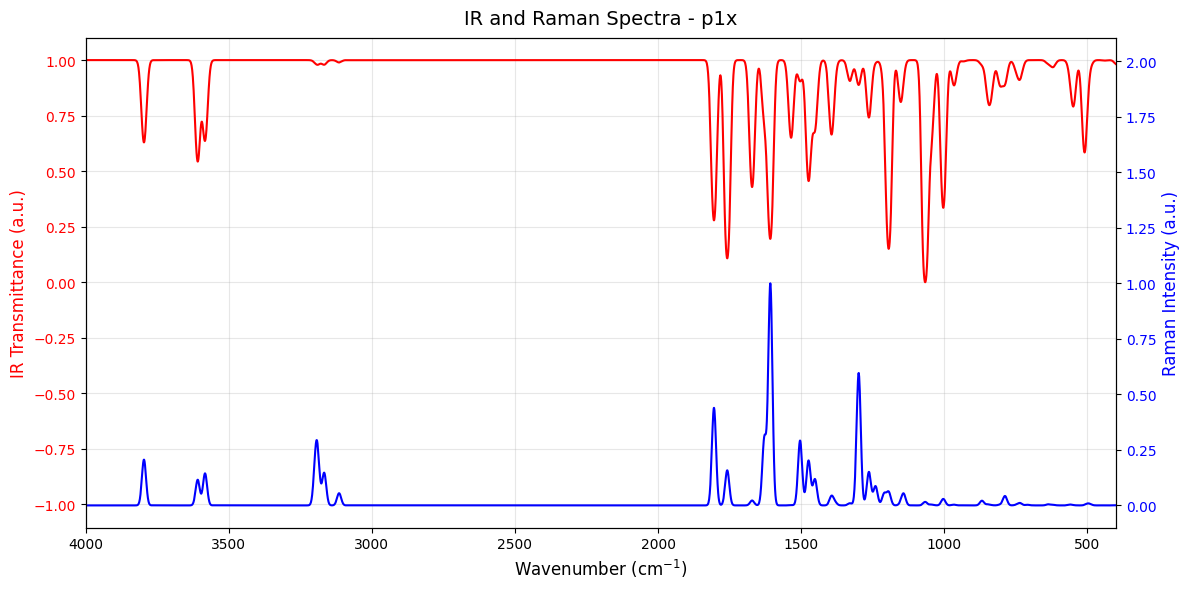

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0]
labels_input = ["p1x"]

# === IR Parameters ===
x = np.linspace(400, 4000, 5000)  # cm⁻¹
fwhm_ir = 20.0
sigma_ir = fwhm_ir / (2 * np.sqrt(2 * np.log(2)))
c = 0.01  # mol/L
l = 1.0   # cm

# === Raman Parameters ===
fwhm_raman = 17.0
sigma_raman = fwhm_raman / (2 * np.sqrt(2 * np.log(2)))

# === Create single figure ===
fig, ax = plt.subplots(figsize=(12, 6))

# ========== IR SPECTRUM ==========
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[datasets[0]])
df_ir["Absorbance"] = df_ir["eps"] * c * l

# Build Gaussian-broadened IR spectrum
absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    freq = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma_ir) ** 2)

# Normalize
if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

# Convert to transmittance (0–1 scale)
transmittance_curve = 10**(-absorbance_curve)
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# ========== RAMAN SPECTRUM ==========
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[datasets[0]])

# Build continuous Raman spectrum
raman_spectrum = np.zeros_like(x)
for _, row in df_raman.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["activity"]
    raman_spectrum += inten * np.exp(-0.5 * ((x - nu0) / sigma_raman) ** 2)

# Normalize
if raman_spectrum.max() > 0:
    raman_spectrum = raman_spectrum / raman_spectrum.max()

# ========== CALCULATE DISTANCE BETWEEN BASELINES ==========
# Add both spectra to find maximum overlap
# IR goes DOWN from 1.0, so low values = peaks
# Raman goes UP from 0.0, so high values = peaks
# Sum shows where they would overlap most
combined = (1.0 - transmittance_curve) + raman_spectrum  # Convert IR to "peak height" then add

# Maximum combined value shows the biggest overlap
max_combined = combined.max()

# Distance needed = max overlap + gap
gap = 0.2
distance = max_combined + gap

print(f"Maximum overlap: {max_combined:.3f}")
print(f"Required distance between baselines: {distance:.3f}")

# ========== CALCULATE Y-AXIS RANGES ==========
padding = 0.1
# Raman axis
raman_y_min = 0.0 - padding
raman_y_max = distance + padding

# IR axis
ir_y_max = 1.0 + padding
ir_y_min = 1.0 - distance - padding

print(f"Raman y-axis: [{raman_y_min:.3f}, {raman_y_max:.3f}]")
print(f"IR y-axis: [{ir_y_min:.3f}, {ir_y_max:.3f}]")

# ========== PLOTTING ==========
# Plot IR on primary y-axis
ax.plot(x, transmittance_curve, color='red', lw=1.5, label='IR')
ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("IR Transmittance (a.u.)", fontsize=12, color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylim(ir_y_min, ir_y_max)

# Plot Raman on secondary y-axis
ax2 = ax.twinx()
ax2.plot(x, raman_spectrum, color='blue', lw=1.5, label='Raman')
ax2.set_ylabel("Raman Intensity (a.u.)", fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(raman_y_min, raman_y_max)

# Invert x-axis
ax.invert_xaxis()
ax.set_xlim(4000, 400)

# Title and grid
ax.set_title(f"IR and Raman Spectra - {labels_input[0]}", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy data...")
    df = pd.DataFrame(index=[0])

# Ensure columns exist
if 'ir_spectrum' not in df.columns: df['ir_spectrum'] = [None]
if 'raman_spectrum' not in df.columns: df['raman_spectrum'] = [None]

# Generate dummy IR
if df['ir_spectrum'].iloc[0] is None:
    # IR Peaks: High frequency (OH/CH), Fingerprint
    wn_ir = np.array([3600, 2900, 1700, 1200, 800])
    eps_ir = np.array([100, 300, 500, 200, 150])
    # Simulating data stored as a dictionary (common pandas behavior)
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

# Generate dummy Raman
if df['raman_spectrum'].iloc[0] is None:
    # Raman Peaks: Often complementary to IR
    wn_ram = np.array([3600, 2900, 1600, 1000, 450])
    act_ram = np.array([50, 400, 100, 300, 100])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ram, "activity": act_ram}

# ==============================================================================
# 2. CONFIGURATION & PHYSICS
# ==============================================================================
datasets = [0]
labels_input = ["p1x"]

# IR Parameters
x = np.linspace(400, 4000, 5000)
fwhm_ir = 20.0
sigma_ir = fwhm_ir / (2 * np.sqrt(2 * np.log(2)))
c = 0.01
l = 1.0

# Raman Parameters
fwhm_raman = 17.0
sigma_raman = fwhm_raman / (2 * np.sqrt(2 * np.log(2)))

# ==============================================================================
# 3. CALCULATIONS (FIXED SECTION)
# ==============================================================================

# Helper function to handle List vs Dict vs DataFrame
def secure_data_load(data):
    if isinstance(data, list):
        return pd.DataFrame(data)
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, pd.DataFrame):
        return data
    else:
        # Fallback dummy if None/Empty to prevent crash
        return pd.DataFrame({"freq_cm-1": [1000], "eps": [0], "activity": [0]})

# --- A. Calculate IR Spectrum ---
raw_data_ir = df["ir_spectrum"].iloc[datasets[0]]
df_ir = secure_data_load(raw_data_ir) # <--- THE FIX

# Ensure columns exist (handle naming variations)
col_freq = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * c * l

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    freq = row[col_freq]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma_ir) ** 2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
# Normalize IR to 0-1
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- B. Calculate Raman Spectrum ---
raw_data_ram = df["raman_spectrum"].iloc[datasets[0]]
df_raman = secure_data_load(raw_data_ram) # <--- THE FIX

# Ensure columns exist
col_freq_r = "freq_cm-1" if "freq_cm-1" in df_raman.columns else df_raman.columns[0]
col_act_r = "activity" if "activity" in df_raman.columns else df_raman.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_raman.iterrows():
    nu0 = row[col_freq_r]
    inten = row[col_act_r]
    raman_spectrum += inten * np.exp(-0.5 * ((x - nu0) / sigma_raman) ** 2)

if raman_spectrum.max() > 0:
    raman_spectrum = raman_spectrum / raman_spectrum.max()

# --- C. Calculate Distance & Limits (Your exact logic) ---
# Combined height to determine overlap
combined = (1.0 - transmittance_curve) + raman_spectrum
max_combined = combined.max()

gap = 0.2
distance = max_combined + gap

print(f"Max Overlap: {max_combined:.3f} | Distance: {distance:.3f}")

# Calculate Axis Limits
padding = 0.1

# Raman Axis (Standard 0 to 1+distance)
raman_y_min = 0.0 - padding
raman_y_max = distance + padding

# IR Axis (Shifted so 1.0 is at top, 0.0 drops down)
# Note: In Matplotlib, limits were [1.0 - distance - padding, 1.0 + padding]
ir_y_min = 1.0 - distance - padding
ir_y_max = 1.0 + padding

# ==============================================================================
# 4. PLOTLY VISUALIZATION
# ==============================================================================

fig = go.Figure()

# Trace 1: IR Spectrum (Red, Primary Y)
fig.add_trace(go.Scatter(
    x=x,
    y=transmittance_curve,
    mode='lines',
    line=dict(color='red', width=2),
    name='IR Transmittance',
    hovertemplate="WN: %{x:.0f} cm⁻¹<br>IR: %{y:.2f}<extra></extra>"
))

# Trace 2: Raman Spectrum (Blue, Secondary Y)
fig.add_trace(go.Scatter(
    x=x,
    y=raman_spectrum,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Raman Intensity',
    yaxis='y2', # Assign to secondary axis
    hovertemplate="WN: %{x:.0f} cm⁻¹<br>Raman: %{y:.2f}<extra></extra>"
))

# Layout
fig.update_layout(
    title=f"<b>IR and Raman Spectra - {labels_input[0]}</b>",
    template="simple_white",
    width=1000,
    height=600,

    # X-Axis
    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        range=[4000, 400], # Inverted
        showgrid=True,
        gridcolor='rgba(0,0,0,0.1)' # Light grid
    ),

    # Y-Axis 1: IR (Left, Red)
    yaxis=dict(
        title="IR Transmittance (a.u.)",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        range=[ir_y_min, ir_y_max], # Your calculated limits
        showgrid=False
    ),

    # Y-Axis 2: Raman (Right, Blue)
    yaxis2=dict(
        title="Raman Intensity (a.u.)",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
        range=[raman_y_min, raman_y_max], # Your calculated limits
        anchor="x",
        overlaying="y", # Critical: Places it on top of the first axis
        side="right",
        showgrid=False
    ),

    margin=dict(l=60, r=60, t=60, b=60),
    showlegend=True,
    legend=dict(x=0.5, y=1.1, orientation="h", xanchor="center")
)

fig.show()

Max Overlap: 1.805 | Distance: 2.005


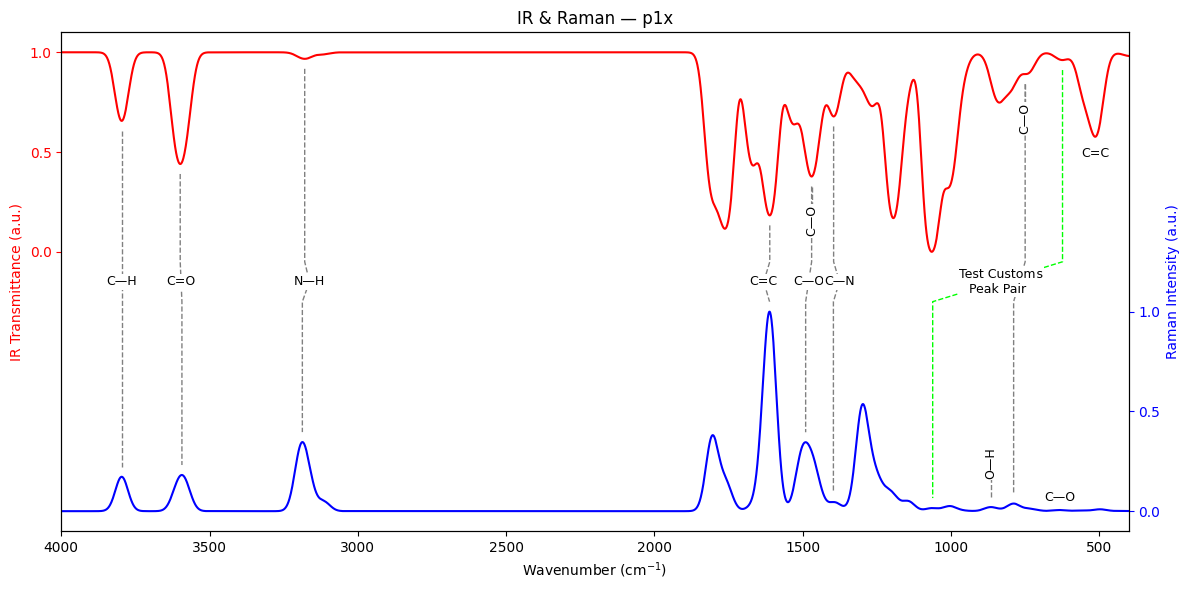

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-20"],
    [3, "C=C", "dx: 20"],
    [4, "C—O"],
    [5, "C—N", "dx:-20"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir",
        [0, "C=C", 0],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.2, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None

    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"

    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param

    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue

    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue

        result = parse_label_params(item)

        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs):
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# =====================================================
# DRAW CONNECTORS
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0)

    ax.text(mid_x, mid_y, label_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor', multialignment=alignment,
            bbox=dict(facecolor="white", edgecolor="none", pad=1.0))

# =====================================================
# DRAW FORCED PAIRS
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0)

    if label is not None:
        ax.text(mid_x, mid_y, label,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor', multialignment=alignment,
                bbox=dict(facecolor="white", edgecolor="none", pad=1.0))

# =====================================================
# LABEL UNPAIRED PEAKS - COLOR FIX APPLIED HERE
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            # With line: always black
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0)
            va_align = 'center' if abs(rotation - 90) < 5 else 'top'
            ax.text(fx, line_end_y - 0.02, label,
                   ha='center', va=va_align, fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
        else:
            # Without line: always black (FIXED)
            va_align = 'center' if abs(rotation - 90) < 5 else 'top'
            ax.text(fx, py - 0.05, label,
                   ha='center', va=va_align, color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - 0.05, str(i),
               ha='center', va='top', color='darkred', fontsize=9,
               bbox=dict(facecolor="white", edgecolor="none", pad=0.6))

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            # With line: always black
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0)
            va_align = 'center' if abs(rotation - 90) < 5 else 'bottom'
            ax.text(fx, line_end_y + 0.02, label,
                   ha='center', va=va_align, fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
        else:
            # Without line: always black (FIXED)
            va_align = 'center' if abs(rotation - 90) < 5 else 'bottom'
            ax.text(fx, shifted_py + 0.03, label,
                   ha='center', va=va_align, color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + 0.03, str(i),
               ha='center', va='bottom', color='darkblue', fontsize=9,
               bbox=dict(facecolor="white", edgecolor="none", pad=0.6))

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately with dummy data if needed)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy IR/Raman data for demonstration...")
    df = pd.DataFrame(index=[0])

# Generate Dummy Data
if 'ir_spectrum' not in df.columns or df['ir_spectrum'].iloc[0] is None:
    # Dictionary format (common source of the previous error)
    wn_ir = np.array([3050, 2950, 1720, 1600, 1450, 1200, 1000, 800, 600])
    eps_ir = np.array([100, 200, 500, 50, 150, 300, 50, 100, 50])
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    wn_ra = np.array([3055, 2945, 1725, 1595, 1445, 1205, 995, 805, 605])
    act_ra = np.array([50, 300, 50, 200, 100, 400, 50, 50, 200])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ra, "activity": act_ra}

# ==============================================================================
# 2. HELPER: DATA LOADER (Fixes the TypeError)
# ==============================================================================
def secure_data_load(data):
    """Converts List or Dict to DataFrame safely"""
    if isinstance(data, pd.DataFrame):
        return data
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, list):
        # Assuming list of records or single dict in list
        return pd.DataFrame(data) if len(data) > 0 else pd.DataFrame()
    return pd.DataFrame()

# ==============================================================================
# 3. USER SETTINGS & CONSTANTS
# ==============================================================================
dataset_index = 0
title_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak Detection params
cluster_tol_cm = 8.0
min_distance_cm = 0.0
max_pair_delta = 40.0

# Geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Label offsets
peak_label_offset = 0.05
line_label_y_offset = 0.02

# ==============================================================================
# 4. BUILD SPECTRA
# ==============================================================================

# --- IR ---
raw_ir = df["ir_spectrum"].iloc[dataset_index]
df_ir = secure_data_load(raw_ir) # <--- DATA LOADING FIX

# Normalize columns if needed
col_freq_ir = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row[col_freq_ir])/sigma_ir)**2)

if absorbance_curve.max() > 0: absorbance_curve /= absorbance_curve.max()

# Transmittance (1 -> 0)
transmittance_curve = 10**(-absorbance_curve)
# Normalize to 0-1 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- Raman ---
raw_ra = df["raman_spectrum"].iloc[dataset_index]
df_ra = secure_data_load(raw_ra) # <--- DATA LOADING FIX

col_freq_ra = "freq_cm-1" if "freq_cm-1" in df_ra.columns else df_ra.columns[0]
col_act = "activity" if "activity" in df_ra.columns else df_ra.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row[col_act] * np.exp(-0.5 * ((x - row[col_freq_ra])/sigma_raman)**2)

if raman_spectrum.max() > 0: raman_spectrum /= raman_spectrum.max()

# ==============================================================================
# 5. PEAK DETECTION & CLUSTERING
# ==============================================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve # Peaks are dips
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0: return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        if ints.sum() > 0: centroid = (freqs * ints).sum()/ints.sum()
        else: centroid = freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

# Info: (index, peak_index, x, y_plot, intensity)
ir_info = [(i,p,x[p],transmittance_curve[p], 1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p], raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# ==============================================================================
# 6. PARSE MANUAL LABELS
# ==============================================================================
manual_labels = [
    [0, "C—H"], [1, "C=O"], [2, "N—H", "dx:-20"], [3, "C=C", "dx: 20"],
    [4, "C—O"], [5, "C—N", "dx:-20"], [[1, 6], "Custom Pair", "#00ff00"],
    [6, 0], [7, 0], [8, "What Is\nThis?"],
    ["ir", [0, "C=C", 0.05], [2, "C—O", 0.2, "rot:90"], [8, "C—O", 0.35, "rot:90"]],
    ["raman", [4, "O—H", 0.2, "rot:90"], [2, "C—O", 0.05]],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
        return ("forced", ir_idx, ra_idx, label, parse_style(item, start_idx))
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        return ("override", pair_idx, label, parse_style(item, start_idx))

def parse_style(item, start_idx):
    color = connector_color
    dx = 0.0
    rot = 0
    align = "center"
    for i in range(start_idx, len(item)):
        p = item[i]
        if isinstance(p, str):
            if p.startswith("dx:"): dx = float(p[3:])
            elif p.startswith("rot:"): rot = float(p[4:])
            elif p in ["center", "left", "right"]: align = p
            elif p.startswith("#") or p in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]: color = p
            elif i == start_idx: color = p
    return (color, dx, rot, align)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                ir_peak_labels[p[0]] = (label, off, rot)
        elif item[0] == "raman":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                raman_peak_labels[p[0]] = (label, off, rot)
        else:
            res = parse_label_params(item)
            if res[0] == "forced": forced_pairs.append([res[1], res[2], res[3]] + list(res[4]))
            elif res[0] == "override": pair_label_overrides[res[1]] = (res[2],) + res[3]

# ==============================================================================
# 7. PAIRING LOGIC
# ==============================================================================
assigned_ir = set()
assigned_ra = set()

# Process Forced
for ir_i, ra_i, _, _, _, _, _ in forced_pairs:
    if ir_i < len(ir_info) and ra_i < len(ra_info):
        assigned_ir.add(ir_i); assigned_ra.add(ra_i)

# Process Automatic
candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_i, _, ir_f, _, ir_int = ir
        ra_i, _, ra_f, _, ra_int = ra
        if ir_i in assigned_ir or ra_i in assigned_ra: continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_i, ra_i, ir_f, ra_f))

candidates.sort(key=lambda t: (t[0], t[1]))

pairs = []
for delta, _, ir_i, ra_i, ir_f, ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_i in assigned_ir or ra_i in assigned_ra: continue
    assigned_ir.add(ir_i); assigned_ra.add(ra_i)
    ir_p = ir_map[ir_i][1]
    ra_p = ra_map[ra_i][1]
    pairs.append([ir_i, ra_i, ir_p, ra_p, ir_f, ra_f])

pairs.sort(key=lambda p: p[4], reverse=True)
pairs = [p + [i] for i, p in enumerate(pairs)]

# ==============================================================================
# 8. GEOMETRY PREP
# ==============================================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y = -vert_height
diag_bottom_y = -(vert_height + diag_height)
snap = vertical_snap_frac * (y_top - y_bottom)

# ==============================================================================
# 9. PLOTLY VISUALIZATION
# ==============================================================================
fig = go.Figure()

# --- A. Connector Lines (Drawn First) ---
def draw_connector(ir_px, ir_py, r_px, r_py, label, color, dx_off, rot):
    mid_x = (ir_px + r_px)/2 + dx_off
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Path
    path_x = [ir_px, ir_px, mid_x, r_px, r_px]
    path_y = [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y]

    fig.add_trace(go.Scatter(
        x=path_x, y=path_y, mode='lines',
        line=dict(color=color, width=1, dash=connector_style),
        hoverinfo='skip', showlegend=False
    ))

    if label:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=str(label),
            showarrow=False,
            font=dict(color="black", size=10),
            bgcolor="white", textangle=rot
        )

# Automatic Pairs
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides and pair_label_overrides[pidx][0] == 0: should_hide = True
    elif hide_unlisted: should_hide = True

    if should_hide: continue

    if pidx in pair_label_overrides:
        lbl, col, dx, rot, _ = pair_label_overrides[pidx]
    else:
        lbl, col, dx, rot = str(pidx), connector_color, 0.0, 0

    draw_connector(x[ir_pidx], transmittance_curve[ir_pidx], x[ra_pidx], raman_shifted[ra_pidx], lbl, col, dx, rot)

# Forced Pairs
for ir_idx, ra_idx, lbl, col, dx, rot, _ in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info): continue
    ir_p = ir_map[ir_idx][1]; ra_p = ra_map[ra_idx][1]
    draw_connector(x[ir_p], transmittance_curve[ir_p], x[ra_p], raman_shifted[ra_p], lbl, col, dx, rot)

# --- B. Unpaired Labels ---
# IR
for i, p, fx, py, _ in ir_info:
    if i in ir_peak_labels:
        lbl, off, rot = ir_peak_labels[i]
        if off > 0:
            line_end = py - off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py - snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end - line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkred', size=9))

# Raman
for i, p, fx, py_orig, _ in ra_info:
    py = raman_shifted[p]
    if i in raman_peak_labels:
        lbl, off, rot = raman_peak_labels[i]
        if off > 0:
            line_end = py + off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py + snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end + line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ra and not hide_unlisted:
        fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkblue', size=9))

# --- C. Spectra Traces (On Top) ---
fig.add_trace(go.Scatter(x=x, y=transmittance_curve, mode='lines', line=dict(color='red', width=1.5), name='IR'))
fig.add_trace(go.Scatter(x=x, y=raman_shifted, mode='lines', line=dict(color='blue', width=1.5), name='Raman'))

# --- D. Layout ---
fig.update_layout(
    title=f"<b>IR & Raman — {title_text}</b>",
    template="simple_white",
    width=1000, height=700,
    xaxis=dict(title="Wavenumber (cm⁻¹)", range=[x_max, x_min], showgrid=False), # INVERTED
    yaxis=dict(
        title="IR Transmittance / Raman Intensity",
        range=[y_bottom, y_top], showgrid=False, zeroline=False,
        tickmode='array',
        tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0, 0, 0.5, 1.0],
        ticktext=["0.0", "0.5", "1.0", "0.0", "0.5", "1.0"]
    ),
    annotations=[
        dict(x=0, y=0.5, xref="paper", yref="y", text="IR (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="red", size=12), textangle=-90, xshift=-45),
        dict(x=0, y=raman_baseline+0.5, xref="paper", yref="y", text="Raman (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="blue", size=12), textangle=-90, xshift=-45)
    ],
    margin=dict(l=80, r=20, t=50, b=50),
    showlegend=True
)

fig.show()

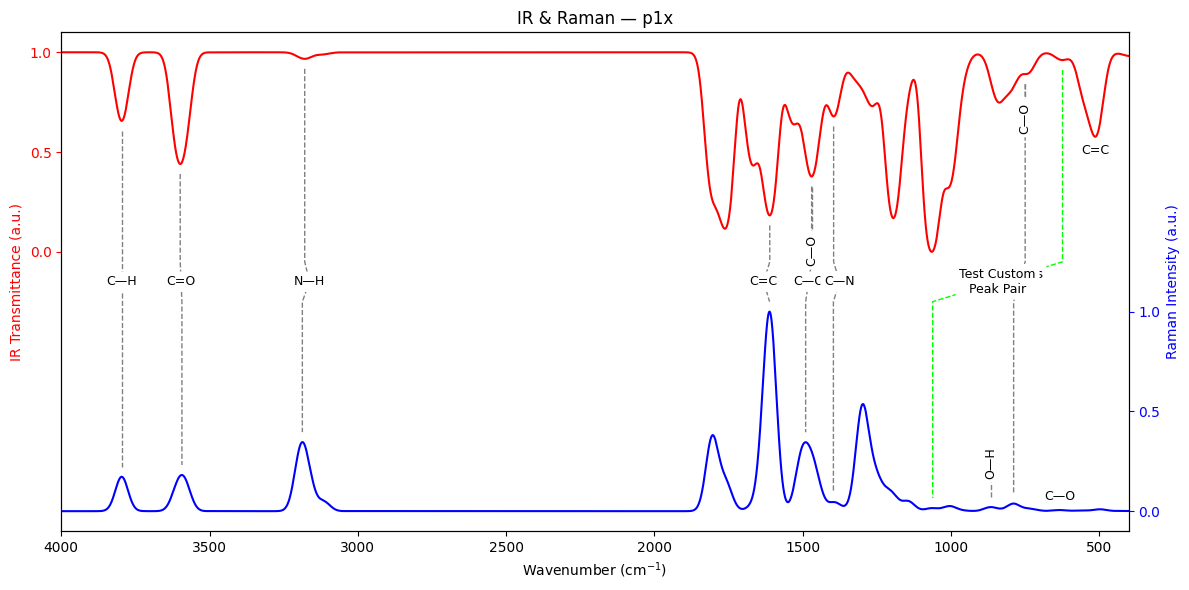

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Text box styling
peak_label_offset = 0.05  # Distance from peak point to text box
line_label_y_offset = 0.02  # Distance from line end to text box

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-20"],
    [3, "C=C", "dx: 20"],
    [4, "C—O"],
    [5, "C—N", "dx:-20"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir",
        [0, "C=C", 0.05],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.35, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0.05],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None

    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"

    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param

    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue

    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue

        result = parse_label_params(item)

        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs):
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# Disable grid
ax.grid(False)
ax2.grid(False)

# =====================================================
# DRAW CONNECTORS
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0)

    ax.text(mid_x, mid_y, label_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor',
            bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

# =====================================================
# DRAW FORCED PAIRS
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0)

    if label is not None:
        ax.text(mid_x, mid_y, label,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor',
                bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

# =====================================================
# LABEL UNPAIRED PEAKS
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0)
            ax.text(fx, line_end_y - line_label_y_offset, label,
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
        else:
            ax.text(fx, py - peak_label_offset, label,
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - peak_label_offset, str(i),
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0)
            ax.text(fx, line_end_y + line_label_y_offset, label,
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
        else:
            ax.text(fx, shifted_py + peak_label_offset, label,
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + peak_label_offset, str(i),
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately with dummy data if needed)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy IR/Raman data for demonstration...")
    df = pd.DataFrame(index=[0])

# Generate Dummy Data
if 'ir_spectrum' not in df.columns or df['ir_spectrum'].iloc[0] is None:
    # Dictionary format (common source of the previous error)
    wn_ir = np.array([3050, 2950, 1720, 1600, 1450, 1200, 1000, 800, 600])
    eps_ir = np.array([100, 200, 500, 50, 150, 300, 50, 100, 50])
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    wn_ra = np.array([3055, 2945, 1725, 1595, 1445, 1205, 995, 805, 605])
    act_ra = np.array([50, 300, 50, 200, 100, 400, 50, 50, 200])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ra, "activity": act_ra}

# ==============================================================================
# 2. HELPER: DATA LOADER (Fixes the TypeError)
# ==============================================================================
def secure_data_load(data):
    """Converts List or Dict to DataFrame safely"""
    if isinstance(data, pd.DataFrame):
        return data
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, list):
        # Assuming list of records or single dict in list
        return pd.DataFrame(data) if len(data) > 0 else pd.DataFrame()
    return pd.DataFrame()

# ==============================================================================
# 3. USER SETTINGS & CONSTANTS
# ==============================================================================
dataset_index = 0
title_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak Detection params
cluster_tol_cm = 8.0
min_distance_cm = 0.0
max_pair_delta = 40.0

# Geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Label offsets
peak_label_offset = 0.05
line_label_y_offset = 0.02

# ==============================================================================
# 4. BUILD SPECTRA
# ==============================================================================

# --- IR ---
raw_ir = df["ir_spectrum"].iloc[dataset_index]
df_ir = secure_data_load(raw_ir) # <--- DATA LOADING FIX

# Normalize columns if needed
col_freq_ir = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row[col_freq_ir])/sigma_ir)**2)

if absorbance_curve.max() > 0: absorbance_curve /= absorbance_curve.max()

# Transmittance (1 -> 0)
transmittance_curve = 10**(-absorbance_curve)
# Normalize to 0-1 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- Raman ---
raw_ra = df["raman_spectrum"].iloc[dataset_index]
df_ra = secure_data_load(raw_ra) # <--- DATA LOADING FIX

col_freq_ra = "freq_cm-1" if "freq_cm-1" in df_ra.columns else df_ra.columns[0]
col_act = "activity" if "activity" in df_ra.columns else df_ra.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row[col_act] * np.exp(-0.5 * ((x - row[col_freq_ra])/sigma_raman)**2)

if raman_spectrum.max() > 0: raman_spectrum /= raman_spectrum.max()

# ==============================================================================
# 5. PEAK DETECTION & CLUSTERING
# ==============================================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve # Peaks are dips
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0: return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        if ints.sum() > 0: centroid = (freqs * ints).sum()/ints.sum()
        else: centroid = freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

# Info: (index, peak_index, x, y_plot, intensity)
ir_info = [(i,p,x[p],transmittance_curve[p], 1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p], raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# ==============================================================================
# 6. PARSE MANUAL LABELS
# ==============================================================================
manual_labels = [
    [0, "C—H"], [1, "C=O"], [2, "N—H", "dx:-20"], [3, "C=C", "dx: 20"],
    [4, "C—O"], [5, "C—N", "dx:-20"], [[1, 6], "Custom Pair", "#00ff00"],
    [6, 0], [7, 0], [8, "What Is\nThis?"],
    ["ir", [0, "C=C", 0.05], [2, "C—O", 0.2, "rot:90"], [8, "C—O", 0.35, "rot:90"]],
    ["raman", [4, "O—H", 0.2, "rot:90"], [2, "C—O", 0.05]],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
        return ("forced", ir_idx, ra_idx, label, parse_style(item, start_idx))
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        return ("override", pair_idx, label, parse_style(item, start_idx))

def parse_style(item, start_idx):
    color = connector_color
    dx = 0.0
    rot = 0
    align = "center"
    for i in range(start_idx, len(item)):
        p = item[i]
        if isinstance(p, str):
            if p.startswith("dx:"): dx = float(p[3:])
            elif p.startswith("rot:"): rot = float(p[4:])
            elif p in ["center", "left", "right"]: align = p
            elif p.startswith("#") or p in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]: color = p
            elif i == start_idx: color = p
    return (color, dx, rot, align)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                ir_peak_labels[p[0]] = (label, off, rot)
        elif item[0] == "raman":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                raman_peak_labels[p[0]] = (label, off, rot)
        else:
            res = parse_label_params(item)
            if res[0] == "forced": forced_pairs.append([res[1], res[2], res[3]] + list(res[4]))
            elif res[0] == "override": pair_label_overrides[res[1]] = (res[2],) + res[3]

# ==============================================================================
# 7. PAIRING LOGIC
# ==============================================================================
assigned_ir = set()
assigned_ra = set()

# Process Forced
for ir_i, ra_i, _, _, _, _, _ in forced_pairs:
    if ir_i < len(ir_info) and ra_i < len(ra_info):
        assigned_ir.add(ir_i); assigned_ra.add(ra_i)

# Process Automatic
candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_i, _, ir_f, _, ir_int = ir
        ra_i, _, ra_f, _, ra_int = ra
        if ir_i in assigned_ir or ra_i in assigned_ra: continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_i, ra_i, ir_f, ra_f))

candidates.sort(key=lambda t: (t[0], t[1]))

pairs = []
for delta, _, ir_i, ra_i, ir_f, ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_i in assigned_ir or ra_i in assigned_ra: continue
    assigned_ir.add(ir_i); assigned_ra.add(ra_i)
    ir_p = ir_map[ir_i][1]
    ra_p = ra_map[ra_i][1]
    pairs.append([ir_i, ra_i, ir_p, ra_p, ir_f, ra_f])

pairs.sort(key=lambda p: p[4], reverse=True)
pairs = [p + [i] for i, p in enumerate(pairs)]

# ==============================================================================
# 8. GEOMETRY PREP
# ==============================================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y = -vert_height
diag_bottom_y = -(vert_height + diag_height)
snap = vertical_snap_frac * (y_top - y_bottom)

# ==============================================================================
# 9. PLOTLY VISUALIZATION
# ==============================================================================
fig = go.Figure()

# --- A. Connector Lines (Drawn First) ---
def draw_connector(ir_px, ir_py, r_px, r_py, label, color, dx_off, rot):
    mid_x = (ir_px + r_px)/2 + dx_off
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Path
    path_x = [ir_px, ir_px, mid_x, r_px, r_px]
    path_y = [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y]

    fig.add_trace(go.Scatter(
        x=path_x, y=path_y, mode='lines',
        line=dict(color=color, width=1, dash=connector_style),
        hoverinfo='skip', showlegend=False
    ))

    if label:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=str(label),
            showarrow=False,
            font=dict(color="black", size=10),
            bgcolor="white", textangle=rot
        )

# Automatic Pairs
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides and pair_label_overrides[pidx][0] == 0: should_hide = True
    elif hide_unlisted: should_hide = True

    if should_hide: continue

    if pidx in pair_label_overrides:
        lbl, col, dx, rot, _ = pair_label_overrides[pidx]
    else:
        lbl, col, dx, rot = str(pidx), connector_color, 0.0, 0

    draw_connector(x[ir_pidx], transmittance_curve[ir_pidx], x[ra_pidx], raman_shifted[ra_pidx], lbl, col, dx, rot)

# Forced Pairs
for ir_idx, ra_idx, lbl, col, dx, rot, _ in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info): continue
    ir_p = ir_map[ir_idx][1]; ra_p = ra_map[ra_idx][1]
    draw_connector(x[ir_p], transmittance_curve[ir_p], x[ra_p], raman_shifted[ra_p], lbl, col, dx, rot)

# --- B. Unpaired Labels ---
# IR
for i, p, fx, py, _ in ir_info:
    if i in ir_peak_labels:
        lbl, off, rot = ir_peak_labels[i]
        if off > 0:
            line_end = py - off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py - snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end - line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkred', size=9))

# Raman
for i, p, fx, py_orig, _ in ra_info:
    py = raman_shifted[p]
    if i in raman_peak_labels:
        lbl, off, rot = raman_peak_labels[i]
        if off > 0:
            line_end = py + off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py + snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end + line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ra and not hide_unlisted:
        fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkblue', size=9))

# --- C. Spectra Traces (On Top) ---
fig.add_trace(go.Scatter(x=x, y=transmittance_curve, mode='lines', line=dict(color='red', width=1.5), name='IR'))
fig.add_trace(go.Scatter(x=x, y=raman_shifted, mode='lines', line=dict(color='blue', width=1.5), name='Raman'))

# --- D. Layout ---
fig.update_layout(
    title=f"<b>IR & Raman — {title_text}</b>",
    template="simple_white",
    width=1000, height=700,
    xaxis=dict(title="Wavenumber (cm⁻¹)", range=[x_max, x_min], showgrid=False), # INVERTED
    yaxis=dict(
        title="IR Transmittance / Raman Intensity",
        range=[y_bottom, y_top], showgrid=False, zeroline=False,
        tickmode='array',
        tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0, 0, 0.5, 1.0],
        ticktext=["0.0", "0.5", "1.0", "0.0", "0.5", "1.0"]
    ),
    annotations=[
        dict(x=0, y=0.5, xref="paper", yref="y", text="IR (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="red", size=12), textangle=-90, xshift=-45),
        dict(x=0, y=raman_baseline+0.5, xref="paper", yref="y", text="Raman (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="blue", size=12), textangle=-90, xshift=-45)
    ],
    margin=dict(l=80, r=20, t=50, b=50),
    showlegend=True
)

fig.show()

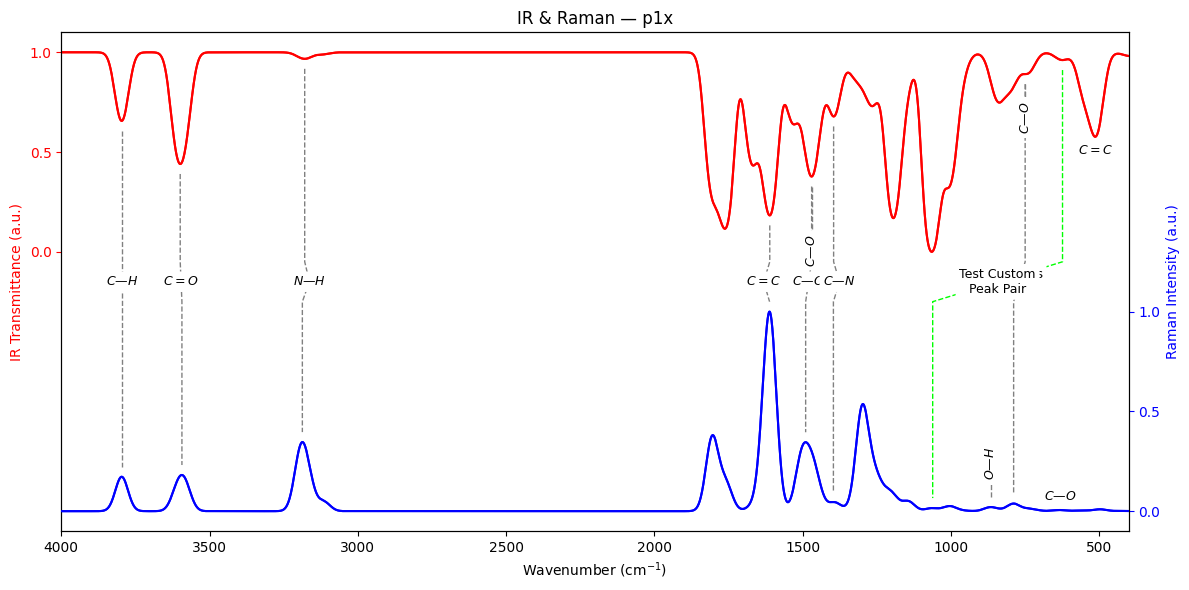

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Text box styling
peak_label_offset = 0.05  # Distance from peak point to text box
line_label_y_offset = 0.02  # Distance from line end to text box

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-20"],
    [3, "C=C", "dx: 20"],
    [4, "C—O"],
    [5, "C—N", "dx:-20"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir",
        [0, "C=C", 0.05],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.35, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0.05],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None

    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"

    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param

    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue

    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue

        result = parse_label_params(item)

        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs):
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# Disable grid
ax.grid(False)
ax2.grid(False)

# =====================================================
# DRAW CONNECTORS (Layer 3)
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=3)

# =====================================================
# DRAW FORCED PAIRS (Layer 4)
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=4)

# =====================================================
# PAIR LABELS (Layer 5)
# =====================================================
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    # Wrap in math mode, handling multiline labels
    if '\n' in label_text:
        display_text = label_text  # Keep multiline as-is
    else:
        display_text = f"${label_text}$"  # Math mode for single line

    ax.text(mid_x, mid_y, display_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor',
            bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
            zorder=5)

for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    if label is not None:
        # Wrap in math mode, handling multiline labels
        if '\n' in label:
            display_text = label  # Keep multiline as-is
        else:
            display_text = f"${label}$"  # Math mode for single line

        ax.text(mid_x, mid_y, display_text,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor',
                bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                zorder=5)

# =====================================================
# PEAK GRID LINES (Layer 6)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

# =====================================================
# PEAK LABELS (Layer 12 - Top)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.text(fx, line_end_y - line_label_y_offset, f"${label}$",  # Math mode
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
        else:
            ax.text(fx, py - peak_label_offset, f"${label}$",  # Math mode
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - peak_label_offset, f"${str(i)}$",  # Math mode
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
               zorder=12)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.text(fx, line_end_y + line_label_y_offset, f"${label}$",  # Math mode
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
        else:
            ax.text(fx, shifted_py + peak_label_offset, f"${label}$",  # Math mode
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + peak_label_offset, f"${str(i)}$",  # Math mode
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
               zorder=12)

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

# =====================================================
# IR SPECTRUM (Layer 1 - Top)
# =====================================================
ax.plot(x, transmittance_curve, color="red", lw=1.5, zorder=100)

# =====================================================
# RAMAN SPECTRUM (Layer 2 - Top)
# =====================================================
ax2.plot(x, raman_shifted, color="blue", lw=1.5, zorder=101)

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately with dummy data if needed)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy IR/Raman data for demonstration...")
    df = pd.DataFrame(index=[0])

# Generate Dummy Data
if 'ir_spectrum' not in df.columns or df['ir_spectrum'].iloc[0] is None:
    # Dictionary format (common source of the previous error)
    wn_ir = np.array([3050, 2950, 1720, 1600, 1450, 1200, 1000, 800, 600])
    eps_ir = np.array([100, 200, 500, 50, 150, 300, 50, 100, 50])
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    wn_ra = np.array([3055, 2945, 1725, 1595, 1445, 1205, 995, 805, 605])
    act_ra = np.array([50, 300, 50, 200, 100, 400, 50, 50, 200])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ra, "activity": act_ra}

# ==============================================================================
# 2. HELPER: DATA LOADER (Fixes the TypeError)
# ==============================================================================
def secure_data_load(data):
    """Converts List or Dict to DataFrame safely"""
    if isinstance(data, pd.DataFrame):
        return data
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, list):
        # Assuming list of records or single dict in list
        return pd.DataFrame(data) if len(data) > 0 else pd.DataFrame()
    return pd.DataFrame()

# ==============================================================================
# 3. USER SETTINGS & CONSTANTS
# ==============================================================================
dataset_index = 0
title_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak Detection params
cluster_tol_cm = 8.0
min_distance_cm = 0.0
max_pair_delta = 40.0

# Geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Label offsets
peak_label_offset = 0.05
line_label_y_offset = 0.02

# ==============================================================================
# 4. BUILD SPECTRA
# ==============================================================================

# --- IR ---
raw_ir = df["ir_spectrum"].iloc[dataset_index]
df_ir = secure_data_load(raw_ir) # <--- DATA LOADING FIX

# Normalize columns if needed
col_freq_ir = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row[col_freq_ir])/sigma_ir)**2)

if absorbance_curve.max() > 0: absorbance_curve /= absorbance_curve.max()

# Transmittance (1 -> 0)
transmittance_curve = 10**(-absorbance_curve)
# Normalize to 0-1 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- Raman ---
raw_ra = df["raman_spectrum"].iloc[dataset_index]
df_ra = secure_data_load(raw_ra) # <--- DATA LOADING FIX

col_freq_ra = "freq_cm-1" if "freq_cm-1" in df_ra.columns else df_ra.columns[0]
col_act = "activity" if "activity" in df_ra.columns else df_ra.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row[col_act] * np.exp(-0.5 * ((x - row[col_freq_ra])/sigma_raman)**2)

if raman_spectrum.max() > 0: raman_spectrum /= raman_spectrum.max()

# ==============================================================================
# 5. PEAK DETECTION & CLUSTERING
# ==============================================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve # Peaks are dips
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0: return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        if ints.sum() > 0: centroid = (freqs * ints).sum()/ints.sum()
        else: centroid = freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

# Info: (index, peak_index, x, y_plot, intensity)
ir_info = [(i,p,x[p],transmittance_curve[p], 1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p], raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# ==============================================================================
# 6. PARSE MANUAL LABELS
# ==============================================================================
manual_labels = [
    [0, "C—H"], [1, "C=O"], [2, "N—H", "dx:-20"], [3, "C=C", "dx: 20"],
    [4, "C—O"], [5, "C—N", "dx:-20"], [[1, 6], "Custom Pair", "#00ff00"],
    [6, 0], [7, 0], [8, "What Is\nThis?"],
    ["ir", [0, "C=C", 0.05], [2, "C—O", 0.2, "rot:90"], [8, "C—O", 0.35, "rot:90"]],
    ["raman", [4, "O—H", 0.2, "rot:90"], [2, "C—O", 0.05]],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
        return ("forced", ir_idx, ra_idx, label, parse_style(item, start_idx))
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        return ("override", pair_idx, label, parse_style(item, start_idx))

def parse_style(item, start_idx):
    color = connector_color
    dx = 0.0
    rot = 0
    align = "center"
    for i in range(start_idx, len(item)):
        p = item[i]
        if isinstance(p, str):
            if p.startswith("dx:"): dx = float(p[3:])
            elif p.startswith("rot:"): rot = float(p[4:])
            elif p in ["center", "left", "right"]: align = p
            elif p.startswith("#") or p in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]: color = p
            elif i == start_idx: color = p
    return (color, dx, rot, align)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                ir_peak_labels[p[0]] = (label, off, rot)
        elif item[0] == "raman":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                raman_peak_labels[p[0]] = (label, off, rot)
        else:
            res = parse_label_params(item)
            if res[0] == "forced": forced_pairs.append([res[1], res[2], res[3]] + list(res[4]))
            elif res[0] == "override": pair_label_overrides[res[1]] = (res[2],) + res[3]

# ==============================================================================
# 7. PAIRING LOGIC
# ==============================================================================
assigned_ir = set()
assigned_ra = set()

# Process Forced
for ir_i, ra_i, _, _, _, _, _ in forced_pairs:
    if ir_i < len(ir_info) and ra_i < len(ra_info):
        assigned_ir.add(ir_i); assigned_ra.add(ra_i)

# Process Automatic
candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_i, _, ir_f, _, ir_int = ir
        ra_i, _, ra_f, _, ra_int = ra
        if ir_i in assigned_ir or ra_i in assigned_ra: continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_i, ra_i, ir_f, ra_f))

candidates.sort(key=lambda t: (t[0], t[1]))

pairs = []
for delta, _, ir_i, ra_i, ir_f, ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_i in assigned_ir or ra_i in assigned_ra: continue
    assigned_ir.add(ir_i); assigned_ra.add(ra_i)
    ir_p = ir_map[ir_i][1]
    ra_p = ra_map[ra_i][1]
    pairs.append([ir_i, ra_i, ir_p, ra_p, ir_f, ra_f])

pairs.sort(key=lambda p: p[4], reverse=True)
pairs = [p + [i] for i, p in enumerate(pairs)]

# ==============================================================================
# 8. GEOMETRY PREP
# ==============================================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y = -vert_height
diag_bottom_y = -(vert_height + diag_height)
snap = vertical_snap_frac * (y_top - y_bottom)

# ==============================================================================
# 9. PLOTLY VISUALIZATION
# ==============================================================================
fig = go.Figure()

# --- A. Connector Lines (Drawn First) ---
def draw_connector(ir_px, ir_py, r_px, r_py, label, color, dx_off, rot):
    mid_x = (ir_px + r_px)/2 + dx_off
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Path
    path_x = [ir_px, ir_px, mid_x, r_px, r_px]
    path_y = [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y]

    fig.add_trace(go.Scatter(
        x=path_x, y=path_y, mode='lines',
        line=dict(color=color, width=1, dash=connector_style),
        hoverinfo='skip', showlegend=False
    ))

    if label:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=str(label),
            showarrow=False,
            font=dict(color="black", size=10),
            bgcolor="white", textangle=rot
        )

# Automatic Pairs
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides and pair_label_overrides[pidx][0] == 0: should_hide = True
    elif hide_unlisted: should_hide = True

    if should_hide: continue

    if pidx in pair_label_overrides:
        lbl, col, dx, rot, _ = pair_label_overrides[pidx]
    else:
        lbl, col, dx, rot = str(pidx), connector_color, 0.0, 0

    draw_connector(x[ir_pidx], transmittance_curve[ir_pidx], x[ra_pidx], raman_shifted[ra_pidx], lbl, col, dx, rot)

# Forced Pairs
for ir_idx, ra_idx, lbl, col, dx, rot, _ in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info): continue
    ir_p = ir_map[ir_idx][1]; ra_p = ra_map[ra_idx][1]
    draw_connector(x[ir_p], transmittance_curve[ir_p], x[ra_p], raman_shifted[ra_p], lbl, col, dx, rot)

# --- B. Unpaired Labels ---
# IR
for i, p, fx, py, _ in ir_info:
    if i in ir_peak_labels:
        lbl, off, rot = ir_peak_labels[i]
        if off > 0:
            line_end = py - off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py - snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end - line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkred', size=9))

# Raman
for i, p, fx, py_orig, _ in ra_info:
    py = raman_shifted[p]
    if i in raman_peak_labels:
        lbl, off, rot = raman_peak_labels[i]
        if off > 0:
            line_end = py + off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py + snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end + line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ra and not hide_unlisted:
        fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkblue', size=9))

# --- C. Spectra Traces (On Top) ---
fig.add_trace(go.Scatter(x=x, y=transmittance_curve, mode='lines', line=dict(color='red', width=1.5), name='IR'))
fig.add_trace(go.Scatter(x=x, y=raman_shifted, mode='lines', line=dict(color='blue', width=1.5), name='Raman'))

# --- D. Layout ---
fig.update_layout(
    title=f"<b>IR & Raman — {title_text}</b>",
    template="simple_white",
    width=1000, height=700,
    xaxis=dict(title="Wavenumber (cm⁻¹)", range=[x_max, x_min], showgrid=False), # INVERTED
    yaxis=dict(
        title="IR Transmittance / Raman Intensity",
        range=[y_bottom, y_top], showgrid=False, zeroline=False,
        tickmode='array',
        tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0, 0, 0.5, 1.0],
        ticktext=["0.0", "0.5", "1.0", "0.0", "0.5", "1.0"]
    ),
    annotations=[
        dict(x=0, y=0.5, xref="paper", yref="y", text="IR (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="red", size=12), textangle=-90, xshift=-45),
        dict(x=0, y=raman_baseline+0.5, xref="paper", yref="y", text="Raman (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="blue", size=12), textangle=-90, xshift=-45)
    ],
    margin=dict(l=80, r=20, t=50, b=50),
    showlegend=True
)

fig.show()

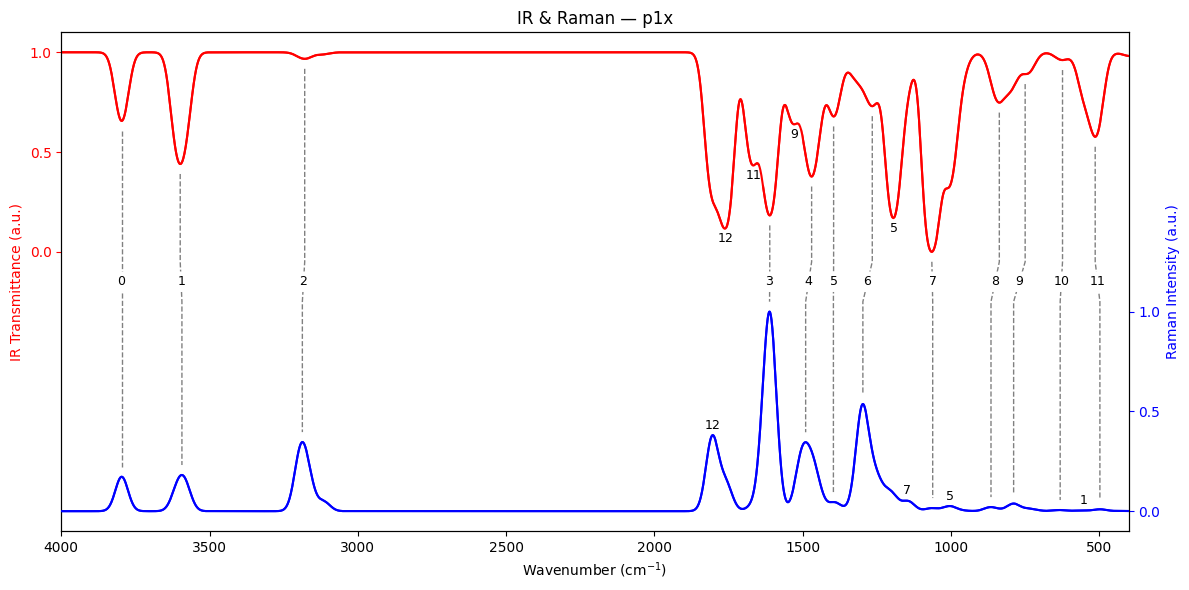

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Text box styling
peak_label_offset = 0.05  # Distance from peak point to text box
line_label_y_offset = 0.02  # Distance from line end to text box

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None

    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"

    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param

    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue

    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue

        result = parse_label_params(item)

        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs):
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# Disable grid
ax.grid(False)
ax2.grid(False)

# =====================================================
# DRAW CONNECTORS (Layer 3)
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=3)

# =====================================================
# DRAW FORCED PAIRS (Layer 4)
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=4)

# =====================================================
# PAIR LABELS (Layer 5)
# =====================================================
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    # Wrap in math mode, handling multiline labels
    if '\n' in label_text:
        display_text = label_text  # Keep multiline as-is
    else:
        display_text = f"${label_text}$"  # Math mode for single line

    ax.text(mid_x, mid_y, display_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor',
            bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
            zorder=5)

for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    if label is not None:
        # Wrap in math mode, handling multiline labels
        if '\n' in label:
            display_text = label  # Keep multiline as-is
        else:
            display_text = f"${label}$"  # Math mode for single line

        ax.text(mid_x, mid_y, display_text,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor',
                bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                zorder=5)

# =====================================================
# PEAK GRID LINES (Layer 6)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

# =====================================================
# PEAK LABELS (Layer 12 - Top)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.text(fx, line_end_y - line_label_y_offset, f"${label}$",  # Math mode
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
        else:
            ax.text(fx, py - peak_label_offset, f"${label}$",  # Math mode
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - peak_label_offset, f"${str(i)}$",  # Math mode
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
               zorder=12)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.text(fx, line_end_y + line_label_y_offset, f"${label}$",  # Math mode
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
        else:
            ax.text(fx, shifted_py + peak_label_offset, f"${label}$",  # Math mode
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
                   zorder=12)
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + peak_label_offset, f"${str(i)}$",  # Math mode
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"),
               zorder=12)

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

# =====================================================
# IR SPECTRUM (Layer 1 - Top)
# =====================================================
ax.plot(x, transmittance_curve, color="red", lw=1.5, zorder=100)

# =====================================================
# RAMAN SPECTRUM (Layer 2 - Top)
# =====================================================
ax2.plot(x, raman_shifted, color="blue", lw=1.5, zorder=101)

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately with dummy data if needed)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy IR/Raman data...")
    df = pd.DataFrame(index=[0])

# Generate Dummy Data (Dictionary format)
if 'ir_spectrum' not in df.columns or df['ir_spectrum'].iloc[0] is None:
    wn_ir = np.array([3050, 2950, 1720, 1600, 1450, 1200, 1000, 800, 600])
    eps_ir = np.array([100, 200, 500, 50, 150, 300, 50, 100, 50])
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    wn_ra = np.array([3055, 2945, 1725, 1595, 1445, 1205, 995, 805, 605])
    act_ra = np.array([50, 300, 50, 200, 100, 400, 50, 50, 200])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ra, "activity": act_ra}

# ==============================================================================
# 2. HELPER: DATA LOADER (Fixes the TypeError)
# ==============================================================================
def secure_data_load(data):
    """Converts List or Dict to DataFrame safely"""
    if isinstance(data, pd.DataFrame):
        return data.copy()
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, list):
        # Handle list of dicts or empty list
        return pd.DataFrame(data) if len(data) > 0 else pd.DataFrame()
    return pd.DataFrame()

# ==============================================================================
# 3. USER SETTINGS & CONSTANTS
# ==============================================================================
dataset_index = 0
title_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak Detection params
cluster_tol_cm = 8.0
min_distance_cm = 0.0
max_pair_delta = 40.0

# Geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Label offsets
peak_label_offset = 0.05
line_label_y_offset = 0.02

# ==============================================================================
# 4. BUILD SPECTRA
# ==============================================================================

# --- IR ---
raw_ir = df["ir_spectrum"].iloc[dataset_index]
df_ir = secure_data_load(raw_ir) # <--- DATA LOADING FIX

# Normalize columns if needed
col_freq_ir = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row[col_freq_ir])/sigma_ir)**2)

if absorbance_curve.max() > 0: absorbance_curve /= absorbance_curve.max()

# Transmittance (1 -> 0)
transmittance_curve = 10**(-absorbance_curve)
# Normalize to 0-1 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- Raman ---
raw_ra = df["raman_spectrum"].iloc[dataset_index]
df_ra = secure_data_load(raw_ra) # <--- DATA LOADING FIX

col_freq_ra = "freq_cm-1" if "freq_cm-1" in df_ra.columns else df_ra.columns[0]
col_act = "activity" if "activity" in df_ra.columns else df_ra.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row[col_act] * np.exp(-0.5 * ((x - row[col_freq_ra])/sigma_raman)**2)

if raman_spectrum.max() > 0: raman_spectrum /= raman_spectrum.max()

# ==============================================================================
# 5. PEAK DETECTION & CLUSTERING
# ==============================================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve # Peaks are dips
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0: return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        if ints.sum() > 0: centroid = (freqs * ints).sum()/ints.sum()
        else: centroid = freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

# Info: (index, peak_index, x, y_plot, intensity)
ir_info = [(i,p,x[p],transmittance_curve[p], 1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p], raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# ==============================================================================
# 6. PARSE MANUAL LABELS
# ==============================================================================
manual_labels = [
    [0, "C—H"], [1, "C=O"], [2, "N—H", "dx:-20"], [3, "C=C", "dx: 20"],
    [4, "C—O"], [5, "C—N", "dx:-20"], [[1, 6], "Custom Pair", "#00ff00"],
    [6, 0], [7, 0], [8, "What Is\nThis?"],
    ["ir", [0, "C=C", 0.05], [2, "C—O", 0.2, "rot:90"], [8, "C—O", 0.35, "rot:90"]],
    ["raman", [4, "O—H", 0.2, "rot:90"], [2, "C—O", 0.05]],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
        return ("forced", ir_idx, ra_idx, label, parse_style(item, start_idx))
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        return ("override", pair_idx, label, parse_style(item, start_idx))

def parse_style(item, start_idx):
    color = connector_color
    dx = 0.0
    rot = 0
    align = "center"
    for i in range(start_idx, len(item)):
        p = item[i]
        if isinstance(p, str):
            if p.startswith("dx:"): dx = float(p[3:])
            elif p.startswith("rot:"): rot = float(p[4:])
            elif p in ["center", "left", "right"]: align = p
            elif p.startswith("#") or p in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]: color = p
            elif i == start_idx: color = p
    return (color, dx, rot, align)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                ir_peak_labels[p[0]] = (label, off, rot)
        elif item[0] == "raman":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                raman_peak_labels[p[0]] = (label, off, rot)
        else:
            res = parse_label_params(item)
            if res[0] == "forced": forced_pairs.append([res[1], res[2], res[3]] + list(res[4]))
            elif res[0] == "override": pair_label_overrides[res[1]] = (res[2],) + res[3]

# ==============================================================================
# 7. PAIRING LOGIC
# ==============================================================================
assigned_ir = set()
assigned_ra = set()

# Process Forced
for ir_i, ra_i, _, _, _, _, _ in forced_pairs:
    if ir_i < len(ir_info) and ra_i < len(ra_info):
        assigned_ir.add(ir_i); assigned_ra.add(ra_i)

# Process Automatic
candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_i, _, ir_f, _, ir_int = ir
        ra_i, _, ra_f, _, ra_int = ra
        if ir_i in assigned_ir or ra_i in assigned_ra: continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_i, ra_i, ir_f, ra_f))

candidates.sort(key=lambda t: (t[0], t[1]))

pairs = []
for delta, _, ir_i, ra_i, ir_f, ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_i in assigned_ir or ra_i in assigned_ra: continue
    assigned_ir.add(ir_i); assigned_ra.add(ra_i)
    ir_p = ir_map[ir_i][1]
    ra_p = ra_map[ra_i][1]
    pairs.append([ir_i, ra_i, ir_p, ra_p, ir_f, ra_f])

pairs.sort(key=lambda p: p[4], reverse=True)
pairs = [p + [i] for i, p in enumerate(pairs)]

# ==============================================================================
# 8. GEOMETRY PREP
# ==============================================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y = -vert_height
diag_bottom_y = -(vert_height + diag_height)
snap = vertical_snap_frac * (y_top - y_bottom)

# ==============================================================================
# 9. PLOTLY VISUALIZATION
# ==============================================================================
fig = go.Figure()

# --- A. Connector Lines (Drawn First) ---
def draw_connector_plotly(ir_px, ir_py, r_px, r_py, label, color, dx_off, rot):
    mid_x = (ir_px + r_px)/2 + dx_off
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Path
    path_x = [ir_px, ir_px, mid_x, r_px, r_px]
    path_y = [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y]

    fig.add_trace(go.Scatter(
        x=path_x, y=path_y, mode='lines',
        line=dict(color=color, width=1, dash=connector_style),
        hoverinfo='skip', showlegend=False
    ))

    if label:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=str(label),
            showarrow=False,
            font=dict(color="black", size=10),
            bgcolor="white", textangle=rot
        )

# Automatic Pairs
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides and pair_label_overrides[pidx][0] == 0: should_hide = True
    elif hide_unlisted: should_hide = True

    if should_hide: continue

    if pidx in pair_label_overrides:
        lbl, col, dx, rot, _ = pair_label_overrides[pidx]
    else:
        lbl, col, dx, rot = str(pidx), connector_color, 0.0, 0

    draw_connector_plotly(x[ir_pidx], transmittance_curve[ir_pidx], x[ra_pidx], raman_shifted[ra_pidx], lbl, col, dx, rot)

# Forced Pairs
for ir_idx, ra_idx, lbl, col, dx, rot, _ in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info): continue
    ir_p = ir_map[ir_idx][1]; ra_p = ra_map[ra_idx][1]
    draw_connector_plotly(x[ir_p], transmittance_curve[ir_p], x[ra_p], raman_shifted[ra_p], lbl, col, dx, rot)

# --- B. Unpaired Labels ---
# IR
for i, p, fx, py, _ in ir_info:
    if i in ir_peak_labels:
        lbl, off, rot = ir_peak_labels[i]
        if off > 0:
            line_end = py - off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py - snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end - line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkred', size=9))

# Raman
for i, p, fx, py_orig, _ in ra_info:
    py = raman_shifted[p]
    if i in raman_peak_labels:
        lbl, off, rot = raman_peak_labels[i]
        if off > 0:
            line_end = py + off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py + snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end + line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ra and not hide_unlisted:
        fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkblue', size=9))

# --- C. Spectra Traces (On Top) ---
fig.add_trace(go.Scatter(x=x, y=transmittance_curve, mode='lines', line=dict(color='red', width=1.5), name='IR'))
fig.add_trace(go.Scatter(x=x, y=raman_shifted, mode='lines', line=dict(color='blue', width=1.5), name='Raman'))

# --- D. Layout ---
fig.update_layout(
    title=f"<b>IR & Raman — {title_text}</b>",
    template="simple_white",
    width=1000, height=700,
    xaxis=dict(title="Wavenumber (cm⁻¹)", range=[x_max, x_min], showgrid=False), # INVERTED
    yaxis=dict(
        title="IR Transmittance / Raman Intensity",
        range=[y_bottom, y_top], showgrid=False, zeroline=False,
        # Simulate dual axis ticks manually
        tickmode='array',
        tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0, 0, 0.5, 1.0],
        ticktext=["0.0", "0.5", "1.0", "0.0", "0.5", "1.0"]
    ),
    # Add colored axis labels
    annotations=[
        dict(x=0, y=0.5, xref="paper", yref="y", text="IR (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="red", size=12), textangle=-90, xshift=-40),
        dict(x=0, y=raman_baseline+0.5, xref="paper", yref="y", text="Raman (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="blue", size=12), textangle=-90, xshift=-40)
    ],
    margin=dict(l=80, r=20, t=50, b=50),
    showlegend=True
)

fig.show()

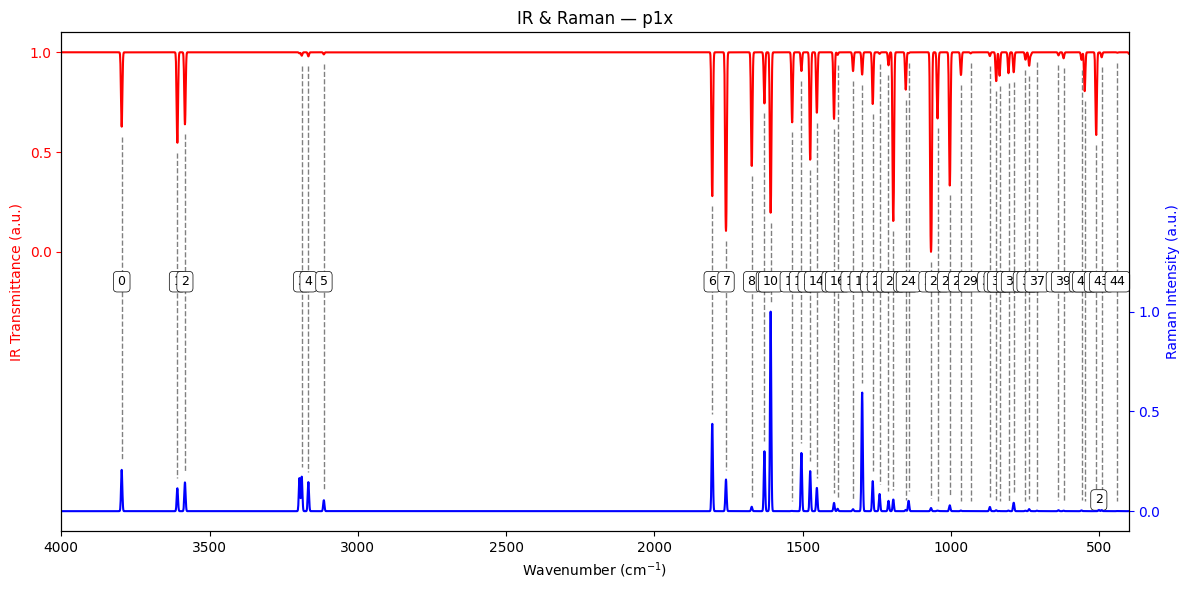

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 5
fwhm_raman = 5
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Text box styling
peak_label_offset = 0.05  # Distance from peak point to text box

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [

]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None

    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"

    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param

    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue

    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue

        result = parse_label_params(item)

        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs):
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# Disable grid
ax.grid(False)
ax2.grid(False)

# =====================================================
# DRAW CONNECTORS (Layer 3)
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=3)

# =====================================================
# DRAW FORCED PAIRS (Layer 4)
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px],
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
            ls=connector_style, color=line_color, lw=1.0, zorder=4)

# =====================================================
# PAIR LABELS (Layer 5)
# =====================================================
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True

    if should_hide:
        continue

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    # Wrap in math mode, handling multiline labels
    if '\n' in label_text:
        display_text = label_text  # Keep multiline as-is
    else:
        display_text = f"${label_text}$"  # Math mode for single line

    ax.text(mid_x, mid_y, display_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor',
            bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
            zorder=5)

for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue

    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    if label is not None:
        # Wrap in math mode, handling multiline labels
        if '\n' in label:
            display_text = label  # Keep multiline as-is
        else:
            display_text = f"${label}$"  # Math mode for single line

        ax.text(mid_x, mid_y, display_text,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor',
                bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                zorder=5)

# =====================================================
# PEAK GRID LINES (Layer 6)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y],
                   ls=connector_style, color=connector_color, lw=1.0, zorder=6)

# =====================================================
# PEAK LABELS (Layer 12 - Top)
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]

        if offset > 0:
            line_end_y = py - offset
            # For rotated text, use different alignment strategy
            if rotation == 90 or rotation == -90:
                ax.text(fx, line_end_y, f"${label}$",
                       ha='center', va='center', fontsize=9, color='black',
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
            else:
                ax.text(fx, line_end_y, f"${label}$",
                       ha='center', va='center', fontsize=9, color='black',
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
        else:
            if rotation == 90 or rotation == -90:
                ax.text(fx, py - peak_label_offset, f"${label}$",
                       ha='center', va='center', color='black', fontsize=9,
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
            else:
                ax.text(fx, py - peak_label_offset, f"${label}$",
                       ha='center', va='center', color='black', fontsize=9,
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - peak_label_offset, f"${str(i)}$",
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
               zorder=12)

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]

        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            # For rotated text, use different alignment strategy
            if rotation == 90 or rotation == -90:
                ax.text(fx, line_end_y, f"${label}$",
                       ha='center', va='center', fontsize=9, color='black',
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
            else:
                ax.text(fx, line_end_y, f"${label}$",
                       ha='center', va='center', fontsize=9, color='black',
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
        else:
            if rotation == 90 or rotation == -90:
                ax.text(fx, shifted_py + peak_label_offset, f"${label}$",
                       ha='center', va='center', color='black', fontsize=9,
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
            else:
                ax.text(fx, shifted_py + peak_label_offset, f"${label}$",
                       ha='center', va='center', color='black', fontsize=9,
                       rotation=rotation, rotation_mode='anchor',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
                       zorder=12)
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + peak_label_offset, f"${str(i)}$",
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="black", linewidth=0.5),
               zorder=12)

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# ==============================================================================
# 1. ROBUST DATA GENERATION
#    (Ensures code runs immediately with dummy data if needed)
# ==============================================================================
if 'df' not in locals():
    print("⚠️ 'df' missing. Generating dummy IR/Raman data for demonstration...")
    df = pd.DataFrame(index=[0])

# Generate Dummy Data
if 'ir_spectrum' not in df.columns or df['ir_spectrum'].iloc[0] is None:
    # Dictionary format (common source of the previous error)
    wn_ir = np.array([3050, 2950, 1720, 1600, 1450, 1200, 1000, 800, 600])
    eps_ir = np.array([100, 200, 500, 50, 150, 300, 50, 100, 50])
    df.at[0, 'ir_spectrum'] = {"freq_cm-1": wn_ir, "eps": eps_ir}

if 'raman_spectrum' not in df.columns or df['raman_spectrum'].iloc[0] is None:
    wn_ra = np.array([3055, 2945, 1725, 1595, 1445, 1205, 995, 805, 605])
    act_ra = np.array([50, 300, 50, 200, 100, 400, 50, 50, 200])
    df.at[0, 'raman_spectrum'] = {"freq_cm-1": wn_ra, "activity": act_ra}

# ==============================================================================
# 2. HELPER: DATA LOADER (Fixes the TypeError)
# ==============================================================================
def secure_data_load(data):
    """Converts List or Dict to DataFrame safely"""
    if isinstance(data, pd.DataFrame):
        return data.copy()
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    elif isinstance(data, list):
        # Handle list of dicts or empty list
        return pd.DataFrame(data) if len(data) > 0 else pd.DataFrame()
    return pd.DataFrame()

# ==============================================================================
# 3. USER SETTINGS & CONSTANTS
# ==============================================================================
dataset_index = 0
title_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak Detection params
cluster_tol_cm = 8.0
min_distance_cm = 0.0
max_pair_delta = 40.0

# Geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Label offsets
peak_label_offset = 0.05
line_label_y_offset = 0.02

# ==============================================================================
# 4. BUILD SPECTRA
# ==============================================================================

# --- IR ---
raw_ir = df["ir_spectrum"].iloc[dataset_index]
df_ir = secure_data_load(raw_ir) # <--- DATA LOADING FIX

# Normalize columns if needed
col_freq_ir = "freq_cm-1" if "freq_cm-1" in df_ir.columns else df_ir.columns[0]
col_eps = "eps" if "eps" in df_ir.columns else df_ir.columns[1]

df_ir["Absorbance"] = df_ir[col_eps] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row[col_freq_ir])/sigma_ir)**2)

if absorbance_curve.max() > 0: absorbance_curve /= absorbance_curve.max()

# Transmittance (1 -> 0)
transmittance_curve = 10**(-absorbance_curve)
# Normalize to 0-1 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# --- Raman ---
raw_ra = df["raman_spectrum"].iloc[dataset_index]
df_ra = secure_data_load(raw_ra) # <--- DATA LOADING FIX

col_freq_ra = "freq_cm-1" if "freq_cm-1" in df_ra.columns else df_ra.columns[0]
col_act = "activity" if "activity" in df_ra.columns else df_ra.columns[1]

raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row[col_act] * np.exp(-0.5 * ((x - row[col_freq_ra])/sigma_raman)**2)

if raman_spectrum.max() > 0: raman_spectrum /= raman_spectrum.max()

# ==============================================================================
# 5. PEAK DETECTION & CLUSTERING
# ==============================================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve # Peaks are dips
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0: return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        if ints.sum() > 0: centroid = (freqs * ints).sum()/ints.sum()
        else: centroid = freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

# Info: (index, peak_index, x, y_plot, intensity)
ir_info = [(i,p,x[p],transmittance_curve[p], 1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p], raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# ==============================================================================
# 6. PARSE MANUAL LABELS
# ==============================================================================
manual_labels = [
    # Add your manual labels here if needed, e.g.:
    # [0, "C—H"], [1, "C=O"], ["ir", [0, "C=C", 0.05]]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
        return ("forced", ir_idx, ra_idx, label, parse_style(item, start_idx))
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        return ("override", pair_idx, label, parse_style(item, start_idx))

def parse_style(item, start_idx):
    color = connector_color
    dx = 0.0
    rot = 0
    align = "center"
    for i in range(start_idx, len(item)):
        p = item[i]
        if isinstance(p, str):
            if p.startswith("dx:"): dx = float(p[3:])
            elif p.startswith("rot:"): rot = float(p[4:])
            elif p in ["center", "left", "right"]: align = p
            elif p.startswith("#") or p in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]: color = p
            elif i == start_idx: color = p
    return (color, dx, rot, align)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                ir_peak_labels[p[0]] = (label, off, rot)
        elif item[0] == "raman":
            for p in item[1:]:
                label = p[1]
                off = p[2] if len(p) >= 3 and isinstance(p[2], (int, float)) else 0
                rot = 0
                for x_param in p[3:]:
                    if isinstance(x_param, str) and x_param.startswith("rot:"):
                        rot = float(x_param[4:])
                raman_peak_labels[p[0]] = (label, off, rot)
        else:
            res = parse_label_params(item)
            if res[0] == "forced": forced_pairs.append([res[1], res[2], res[3]] + list(res[4]))
            elif res[0] == "override": pair_label_overrides[res[1]] = (res[2],) + res[3]

# ==============================================================================
# 7. PAIRING LOGIC
# ==============================================================================
assigned_ir = set()
assigned_ra = set()

# Process Forced
for ir_i, ra_i, _, _, _, _, _ in forced_pairs:
    if ir_i < len(ir_info) and ra_i < len(ra_info):
        assigned_ir.add(ir_i); assigned_ra.add(ra_i)

# Process Automatic
candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_i, _, ir_f, _, ir_int = ir
        ra_i, _, ra_f, _, ra_int = ra
        if ir_i in assigned_ir or ra_i in assigned_ra: continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_i, ra_i, ir_f, ra_f))

candidates.sort(key=lambda t: (t[0], t[1]))

pairs = []
for delta, _, ir_i, ra_i, ir_f, ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_i in assigned_ir or ra_i in assigned_ra: continue
    assigned_ir.add(ir_i); assigned_ra.add(ra_i)
    ir_p = ir_map[ir_i][1]
    ra_p = ra_map[ra_i][1]
    pairs.append([ir_i, ra_i, ir_p, ra_p, ir_f, ra_f])

pairs.sort(key=lambda p: p[4], reverse=True)
pairs = [p + [i] for i, p in enumerate(pairs)]

# ==============================================================================
# 8. GEOMETRY PREP
# ==============================================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y = -vert_height
diag_bottom_y = -(vert_height + diag_height)
snap = vertical_snap_frac * (y_top - y_bottom)

# ==============================================================================
# 9. PLOTLY VISUALIZATION
# ==============================================================================
fig = go.Figure()

# --- A. Connector Lines (Drawn First) ---
def draw_connector(ir_px, ir_py, r_px, r_py, label, color, dx_off, rot):
    mid_x = (ir_px + r_px)/2 + dx_off
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Path
    path_x = [ir_px, ir_px, mid_x, r_px, r_px]
    path_y = [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y]

    fig.add_trace(go.Scatter(
        x=path_x, y=path_y, mode='lines',
        line=dict(color=color, width=1, dash=connector_style),
        hoverinfo='skip', showlegend=False
    ))

    if label:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=str(label),
            showarrow=False,
            font=dict(color="black", size=10),
            bgcolor="white", textangle=rot
        )

# Automatic Pairs
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides and pair_label_overrides[pidx][0] == 0: should_hide = True
    elif hide_unlisted: should_hide = True

    if should_hide: continue

    if pidx in pair_label_overrides:
        lbl, col, dx, rot, _ = pair_label_overrides[pidx]
    else:
        lbl, col, dx, rot = str(pidx), connector_color, 0.0, 0

    draw_connector(x[ir_pidx], transmittance_curve[ir_pidx], x[ra_pidx], raman_shifted[ra_pidx], lbl, col, dx, rot)

# Forced Pairs
for ir_idx, ra_idx, lbl, col, dx, rot, _ in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info): continue
    ir_p = ir_map[ir_idx][1]; ra_p = ra_map[ra_idx][1]
    draw_connector(x[ir_p], transmittance_curve[ir_p], x[ra_p], raman_shifted[ra_p], lbl, col, dx, rot)

# --- B. Unpaired Labels ---
# IR
for i, p, fx, py, _ in ir_info:
    if i in ir_peak_labels:
        lbl, off, rot = ir_peak_labels[i]
        if off > 0:
            line_end = py - off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py - snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end - line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkred', size=9))

# Raman
for i, p, fx, py_orig, _ in ra_info:
    py = raman_shifted[p]
    if i in raman_peak_labels:
        lbl, off, rot = raman_peak_labels[i]
        if off > 0:
            line_end = py + off
            fig.add_trace(go.Scatter(x=[fx, fx], y=[py + snap, line_end], mode='lines',
                                     line=dict(color='gray', width=1, dash='dash'), showlegend=False))
            fig.add_annotation(x=fx, y=line_end + line_label_y_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
        else:
            fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(lbl), showarrow=False,
                               textangle=rot, bgcolor="white", font=dict(color='black', size=10))
    elif i not in assigned_ra and not hide_unlisted:
        fig.add_annotation(x=fx, y=py + peak_label_offset, text=str(i), showarrow=False,
                           bgcolor="rgba(255,255,255,0.7)", font=dict(color='darkblue', size=9))

# --- C. Spectra Traces (On Top) ---
fig.add_trace(go.Scatter(x=x, y=transmittance_curve, mode='lines', line=dict(color='red', width=1.5), name='IR'))
fig.add_trace(go.Scatter(x=x, y=raman_shifted, mode='lines', line=dict(color='blue', width=1.5), name='Raman'))

# --- D. Layout ---
fig.update_layout(
    title=f"<b>IR & Raman — {title_text}</b>",
    template="simple_white",
    width=1000, height=700,
    xaxis=dict(title="Wavenumber (cm⁻¹)", range=[x_max, x_min], showgrid=False), # INVERTED
    yaxis=dict(
        title="IR Transmittance / Raman Intensity",
        range=[y_bottom, y_top], showgrid=False, zeroline=False,
        tickmode='array',
        tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0, 0, 0.5, 1.0],
        ticktext=["0.0", "0.5", "1.0", "0.0", "0.5", "1.0"]
    ),
    annotations=[
        dict(x=0, y=0.5, xref="paper", yref="y", text="IR (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="red", size=12), textangle=-90, xshift=-45),
        dict(x=0, y=raman_baseline+0.5, xref="paper", yref="y", text="Raman (a.u.)", showarrow=False,
             xanchor="right", font=dict(color="blue", size=12), textangle=-90, xshift=-45)
    ],
    margin=dict(l=80, r=20, t=50, b=50),
    showlegend=True
)

fig.show()